# Assignment 1 goal
[Assignment PDF](http://rail.eecs.berkeley.edu/deeprlcourse/static/homeworks/hw1.pdf)

In [1]:
import os
import tensorflow as tf
import numpy as np
import pickle
import pandas as pd

# Set matplotlib environment
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 9000)
pd.options.display.max_colwidth = 9000

plt.style.use('bmh')
%pylab inline

# Reload python module by default
# https://iqbalnaved.wordpress.com/2013/10/18/ipython-tip-reloading-modified-code/
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys

def add_to_path(new_paths):
    for new_path in paths_to_add:
        if new_path not in sys.path:
            sys.path.append(new_path)


CWD = os.getcwd().replace('/hw1/notebooks', '')
os.chdir(CWD)
paths_to_add = [CWD]
add_to_path(paths_to_add)

## 1. Set Up environment with OpenAi Roboschool instead of MuJoCo
In my fork to this homework repository I have added instruction of how to set up the environment with virtualenv or with a prebuild docker image. First setup the environment and then you will be able to run this notebook.

## 2. Behavioral Cloning
The idea behind Behavioral Cloning is to apply Supervised Learning methods in order to learn a control policy. This basically means that we are not going to learn a state/action value function. Instead we will record a set of trajectories/rewards ran by an expert policy and try to imitate that continues action vector policy using a regretion model (in this case, an ANN with a regresion head).


### Generating the dataset

In [3]:
from hw1.consts import EXPERT_DIR, AVAILABLE_ENVS, EXPERT_DATA_DIR
from hw1.run_expert import run_expert_policy

In [4]:
#!rm -fr {EXPERT_DATA_DIR}
!mkdir -p {EXPERT_DATA_DIR}

In [18]:
import pickle


for env_name in AVAILABLE_ENVS:
    print("Running env %s" % env_name)
    %time expert_data = run_expert_policy(num_rollouts=50, env_name=env_name, verbose=False)
    with open(os.path.join(EXPERT_DATA_DIR, env_name + '.pkl'), 'wb') as f:
        pickle.dump(expert_data, f, pickle.HIGHEST_PROTOCOL)

Running env RoboschoolAnt-v1
Env description: Expert policy for module RoboschoolAnt-v1
mean return 1818.8292998516504
std of return 381.8678179633842
CPU times: user 40 s, sys: 1min 3s, total: 1min 43s
Wall time: 1min 44s
Running env RoboschoolHumanoid-v1
Env description: Expert policy for module RoboschoolHumanoid-v1
mean return 2848.910280488764
std of return 1033.9963047075728
CPU times: user 2min 55s, sys: 7min 5s, total: 10min
Wall time: 2min 30s
Running env RoboschoolHalfCheetah-v1
Env description: Expert policy for module RoboschoolHalfCheetah-v1
mean return 2271.29843854231
std of return 909.0033810184069
CPU times: user 25.2 s, sys: 47.3 s, total: 1min 12s
Wall time: 1min 12s
Running env RoboschoolReacher-v1
Env description: Expert policy for module RoboschoolReacher-v1
mean return 18.612237270160552
std of return 10.257759621234174
CPU times: user 1.49 s, sys: 3.15 s, total: 4.64 s
Wall time: 4.67 s
Running env RoboschoolHopper-v1
Env description: Expert policy for module Ro

# Helper modules/functions

## hw1/manage_datasets.py: Helper functions for loading the specific domain tasks Datasets
For example, load the train/test datasets with their labels, and show their input and output vectors

In [5]:
from hw1.manage_datasets import get_datasets
from hw1.consts import EXPERT_DATA_DIR


dataset_name = 'RoboschoolAnt-v1'
X_train, X_test, y_train, y_test = get_datasets(dataset_name=dataset_name, dataset_dir=EXPERT_DATA_DIR)

loading dataset RoboschoolAnt-v1
Domain name: RoboschoolAnt-v1
(45000, 28) (5000, 28) (45000, 8) (5000, 8)


In [6]:
X_train[1, :]

array([-0.12892047, -0.02399238,  0.99971217,  0.35790426,  0.30509418,
        0.058642  ,  0.1139003 , -0.11415579,  0.43144047, -0.75470674,
        1.0087281 , -0.03240158,  0.02628127,  0.6814454 , -0.2858721 ,
        0.01521853, -0.68756235,  0.23606583,  0.5452577 ,  0.26748422,
        0.42372003, -0.5583233 ,  0.58613735,  0.07699564,  0.        ,
        1.        ,  1.        ,  1.        ], dtype=float32)

In [7]:
y_train[0, :]

array([ 1.77629344, -0.11997891, -0.30649464, -1.7593687 ,  0.69761764,
        0.70613533, -0.05471253,  0.07859467])

The 'RoboschoolAnt-v1' domain has 28 input features (floats), and the actions vector (what we are trying to predict) have 8 features (floats)

## keras_helpers/model_helper.py: Helper function for defining a Fully Connected (FC) new Keras model.
For examople lets create a Fully connected network that has the input/output dimensions suitable for 'RoboschoolAnt-v1'

In [8]:
from keras_helpers.model_helper import create_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# Define model
config_dict = dict(
    input_dim=len(X_train[1, :]),
    output_dim=len(y_train[1, :]),
    units=100,
    layers = 3,
    l2_reg = 1e-04,
    lr = 1e-03,
    dropout=None,
    use_batchnorm=False)

model = create_model(**config_dict)

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


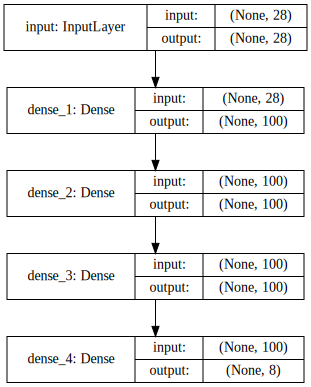

In [9]:
# Plot the model architecture
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

We can easily add dropout and batchnorm layers to this model

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


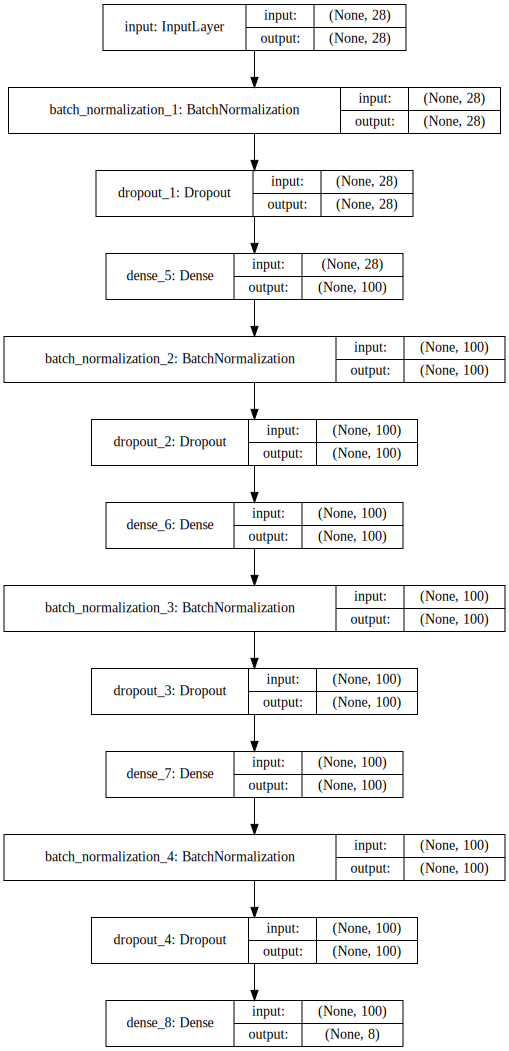

In [10]:
# Define model
config_dict = dict(
    input_dim=len(X_train[1, :]),
    output_dim=len(y_train[1, :]),
    units=100,
    layers = 3,
    l2_reg = 1e-04,
    lr = 1e-03,
    dropout=0.1,
    use_batchnorm=True)

model = create_model(**config_dict)
# Plot the model architecture
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# Training a FC ANN for each domain
For each domain, we will train an ANN with the same network architecture. I did not perform hyperparameters tunning because it is not the main scope of the task. However, you can try resizing the network or add  regularization/dropout/batchnorm layers in order to improve the loss of each of the networks.

In [11]:
import os

def create_dir_if_not_exists(name):
    if not os.path.exists(name):
        os.makedirs(name)

In [44]:
from keras.callbacks import Callback, LambdaCallback, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from hw1.manage_datasets import get_datasets
from keras_helpers.model_helper import create_model, get_model_name, calc_mse
from keras_helpers.keras_train_stats import KerasTrainStats


SAVED_MODELS_DIR = 'hw1/models'
MODEL_FILE_NAME = "base.hdf5"
create_dir_if_not_exists(SAVED_MODELS_DIR)

model_mse = []

for env_name in AVAILABLE_ENVS:
    print("Training a FC ANN for env %s" % env_name)
    
    # Load the datasets
    X_train, X_test, y_train, y_test = get_datasets(dataset_name=env_name, dataset_dir=EXPERT_DATA_DIR)
    
    # Define the model params
    config_dict = dict(
        input_dim=len(X_train[1, :]),
        output_dim=len(y_train[1, :]),
        units=100,
        num_hidden=3,
        l2_reg=1e-04,
        optimizer_cls=keras.optimizers.Adam,
        lr = 1e-03,
        dropout=0.1,
        use_batchnorm=True)
    
    # Create the model
    model = create_model(**config_dict)
    
    # Compile the model
    optimizer = config_dict['optimizer_cls'](lr=config_dict['lr'])
    model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])
    
    # Set a unique name/directory for the model
    model_name = get_model_name(base_name=env_name, **config_dict)
    model_path = os.path.join(SAVED_MODELS_DIR, model_name)
    print("model_name='%s'" % model_name)
    print("model_path='%s'" % model_path)
    create_dir_if_not_exists(model_path)
    model_filename = os.path.join(model_path, MODEL_FILE_NAME)
    
    
    # Train the model
    reduce_lr = ReduceLROnPlateau(monitor='val_mean_squared_error', factor=0.5, patience=5, verbose=1)
    tf_board = TensorBoard()

    # Define a train_stats object
    train_stats = KerasTrainStats(model_name=model_name, history_dir=model_path)


    # Train the model
    batch_size = 64
    epochs = 100

    _ = model.fit([X_train], y_train,
              batch_size=batch_size,
              epochs=epochs,
              callbacks=[train_stats.print_callback, reduce_lr, tf_board],
              validation_data=([X_test], y_test)
              )
    
    
    # Save the model
    model.save(model_filename)
    print(model_filename)
    
    # Calculate the MSE for each 
    res = calc_mse(model, env_name, X_train, X_test, y_train, y_test)
    res['model_name'] = model_name
    res['model_path'] = model_path
    model_mse.append(res)
    print("Done training model for %s" % env_name)
    #print("KerasTrainStats(model_name=model_name, history_dir=model_path).plt_history(start_epoch=5, metric_str='mean_squared_error', title='%s MSE')" % dataset_name)
    print(res)
    

Training a FC ANN for env RoboschoolAnt-v1
loading dataset RoboschoolAnt-v1
Domain name: RoboschoolAnt-v1
(45000, 28) (5000, 28) (45000, 8) (5000, 8)
model_name='model_RoboschoolAnt-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_0.1_dropout_with_batchnorm'
model_path='hw1/models/model_RoboschoolAnt-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_0.1_dropout_with_batchnorm'
Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 5s 108us/step - loss: 0.7790 - mean_squared_error: 0.7545 - val_loss: 0.3454 - val_mean_squared_error: 0.3211
Epoch 2/100
45000/45000 [==============================] - 3s 77us/step - loss: 0.5092 - mean_squared_error: 0.4851 - val_loss: 0.2928 - val_mean_squared_error: 0.2689
Epoch 3/100
45000/45000 [==============================] - 4s 81us/step - loss: 0.4559 - mean_squared_error: 0.4324 - val_loss: 0.2733 - val_mean_squared_error: 0.2501
Epoch 4/100
45000/45000 [========================

45000/45000 [==============================] - 3s 76us/step - loss: 0.3195 - mean_squared_error: 0.3047 - val_loss: 0.1784 - val_mean_squared_error: 0.1638
Epoch 46/100
45000/45000 [==============================] - 3s 77us/step - loss: 0.3207 - mean_squared_error: 0.3061 - val_loss: 0.1734 - val_mean_squared_error: 0.1589
Epoch 47/100
45000/45000 [==============================] - 3s 77us/step - loss: 0.3184 - mean_squared_error: 0.3040 - val_loss: 0.1752 - val_mean_squared_error: 0.1608
Epoch 48/100
45000/45000 [==============================] - 3s 76us/step - loss: 0.3182 - mean_squared_error: 0.3039 - val_loss: 0.1740 - val_mean_squared_error: 0.1598
Epoch 49/100
45000/45000 [==============================] - 3s 76us/step - loss: 0.3171 - mean_squared_error: 0.3030 - val_loss: 0.1730 - val_mean_squared_error: 0.1590
Epoch 50/100
45000/45000 [==============================] - 3s 75us/step - loss: 0.3185 - mean_squared_error: 0.3046 - val_loss: 0.1742 - val_mean_squared_error: 0.1604

45000/45000 [==============================] - 4s 83us/step - loss: 0.3085 - mean_squared_error: 0.2969 - val_loss: 0.1669 - val_mean_squared_error: 0.1553
Epoch 92/100
45000/45000 [==============================] - 4s 81us/step - loss: 0.3090 - mean_squared_error: 0.2974 - val_loss: 0.1660 - val_mean_squared_error: 0.1544

Epoch 00092: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Epoch 93/100
45000/45000 [==============================] - 3s 76us/step - loss: 0.3069 - mean_squared_error: 0.2954 - val_loss: 0.1658 - val_mean_squared_error: 0.1543
Epoch 94/100
45000/45000 [==============================] - 3s 75us/step - loss: 0.3066 - mean_squared_error: 0.2951 - val_loss: 0.1650 - val_mean_squared_error: 0.1535
Epoch 95/100
45000/45000 [==============================] - 3s 76us/step - loss: 0.3081 - mean_squared_error: 0.2966 - val_loss: 0.1663 - val_mean_squared_error: 0.1547
Epoch 96/100
45000/45000 [==============================] - 3s 75us/step - loss: 0.3066

Epoch 33/100
39999/39999 [==============================] - 3s 81us/step - loss: 0.0501 - mean_squared_error: 0.0461 - val_loss: 0.0332 - val_mean_squared_error: 0.0292
Epoch 34/100
39999/39999 [==============================] - 3s 79us/step - loss: 0.0502 - mean_squared_error: 0.0462 - val_loss: 0.0332 - val_mean_squared_error: 0.0292

Epoch 00034: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 35/100
39999/39999 [==============================] - 3s 77us/step - loss: 0.0479 - mean_squared_error: 0.0441 - val_loss: 0.0306 - val_mean_squared_error: 0.0269
Epoch 36/100
39999/39999 [==============================] - 3s 79us/step - loss: 0.0473 - mean_squared_error: 0.0438 - val_loss: 0.0312 - val_mean_squared_error: 0.0278
Epoch 37/100
39999/39999 [==============================] - 3s 79us/step - loss: 0.0474 - mean_squared_error: 0.0441 - val_loss: 0.0302 - val_mean_squared_error: 0.0269
Epoch 38/100
39999/39999 [==============================] - 3s 78us/step -

39999/39999 [==============================] - 3s 77us/step - loss: 0.0419 - mean_squared_error: 0.0402 - val_loss: 0.0255 - val_mean_squared_error: 0.0238
Epoch 79/100
39999/39999 [==============================] - 3s 82us/step - loss: 0.0425 - mean_squared_error: 0.0408 - val_loss: 0.0255 - val_mean_squared_error: 0.0238
Epoch 80/100
39999/39999 [==============================] - 3s 82us/step - loss: 0.0419 - mean_squared_error: 0.0402 - val_loss: 0.0255 - val_mean_squared_error: 0.0238
Epoch 81/100
39999/39999 [==============================] - 3s 77us/step - loss: 0.0419 - mean_squared_error: 0.0402 - val_loss: 0.0255 - val_mean_squared_error: 0.0238
Epoch 82/100
39999/39999 [==============================] - 3s 76us/step - loss: 0.0419 - mean_squared_error: 0.0402 - val_loss: 0.0255 - val_mean_squared_error: 0.0238

Epoch 00082: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epoch 83/100
39999/39999 [==============================] - 3s 80us/step - loss: 0.0420

38341/38341 [==============================] - 3s 78us/step - loss: 0.1902 - mean_squared_error: 0.1765 - val_loss: 0.0933 - val_mean_squared_error: 0.0797
Epoch 19/100
38341/38341 [==============================] - 3s 79us/step - loss: 0.1875 - mean_squared_error: 0.1739 - val_loss: 0.1008 - val_mean_squared_error: 0.0874
Epoch 20/100
38341/38341 [==============================] - 3s 78us/step - loss: 0.1883 - mean_squared_error: 0.1748 - val_loss: 0.1054 - val_mean_squared_error: 0.0920
Epoch 21/100
38341/38341 [==============================] - 3s 80us/step - loss: 0.1841 - mean_squared_error: 0.1707 - val_loss: 0.0972 - val_mean_squared_error: 0.0840
Epoch 22/100
38341/38341 [==============================] - 3s 80us/step - loss: 0.1825 - mean_squared_error: 0.1693 - val_loss: 0.1079 - val_mean_squared_error: 0.0948
Epoch 23/100
38341/38341 [==============================] - 3s 78us/step - loss: 0.1829 - mean_squared_error: 0.1697 - val_loss: 0.1122 - val_mean_squared_error: 0.0991

Epoch 64/100
38341/38341 [==============================] - 3s 79us/step - loss: 0.1572 - mean_squared_error: 0.1487 - val_loss: 0.0838 - val_mean_squared_error: 0.0753
Epoch 65/100
38341/38341 [==============================] - 3s 78us/step - loss: 0.1567 - mean_squared_error: 0.1482 - val_loss: 0.0827 - val_mean_squared_error: 0.0742

Epoch 00065: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 66/100
38341/38341 [==============================] - 3s 77us/step - loss: 0.1571 - mean_squared_error: 0.1486 - val_loss: 0.0806 - val_mean_squared_error: 0.0721
Epoch 67/100
38341/38341 [==============================] - 3s 78us/step - loss: 0.1579 - mean_squared_error: 0.1494 - val_loss: 0.0802 - val_mean_squared_error: 0.0717
Epoch 68/100
38341/38341 [==============================] - 3s 78us/step - loss: 0.1551 - mean_squared_error: 0.1467 - val_loss: 0.0813 - val_mean_squared_error: 0.0729
Epoch 69/100
38341/38341 [==============================] - 3s 77us/step 

6750/6750 [==============================] - 1s 80us/step - loss: 0.3034 - mean_squared_error: 0.2817 - val_loss: 0.1124 - val_mean_squared_error: 0.0907
Epoch 3/100
6750/6750 [==============================] - 1s 79us/step - loss: 0.2238 - mean_squared_error: 0.2021 - val_loss: 0.1042 - val_mean_squared_error: 0.0824
Epoch 4/100
6750/6750 [==============================] - 1s 83us/step - loss: 0.1781 - mean_squared_error: 0.1564 - val_loss: 0.0964 - val_mean_squared_error: 0.0747
Epoch 5/100
6750/6750 [==============================] - 1s 80us/step - loss: 0.1609 - mean_squared_error: 0.1393 - val_loss: 0.0929 - val_mean_squared_error: 0.0713
Epoch 6/100
6750/6750 [==============================] - 1s 79us/step - loss: 0.1395 - mean_squared_error: 0.1179 - val_loss: 0.0910 - val_mean_squared_error: 0.0694
Epoch 7/100
6750/6750 [==============================] - 1s 77us/step - loss: 0.1297 - mean_squared_error: 0.1082 - val_loss: 0.0900 - val_mean_squared_error: 0.0685
Epoch 8/100
6750

6750/6750 [==============================] - 1s 80us/step - loss: 0.0733 - mean_squared_error: 0.0605 - val_loss: 0.0547 - val_mean_squared_error: 0.0420
Epoch 52/100
6750/6750 [==============================] - 1s 81us/step - loss: 0.0694 - mean_squared_error: 0.0568 - val_loss: 0.0584 - val_mean_squared_error: 0.0459
Epoch 53/100
6750/6750 [==============================] - 1s 82us/step - loss: 0.0736 - mean_squared_error: 0.0612 - val_loss: 0.0538 - val_mean_squared_error: 0.0415

Epoch 00053: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 54/100
6750/6750 [==============================] - 1s 82us/step - loss: 0.0713 - mean_squared_error: 0.0590 - val_loss: 0.0527 - val_mean_squared_error: 0.0406
Epoch 55/100
6750/6750 [==============================] - 1s 80us/step - loss: 0.0661 - mean_squared_error: 0.0540 - val_loss: 0.0512 - val_mean_squared_error: 0.0392
Epoch 56/100
6750/6750 [==============================] - 1s 83us/step - loss: 0.0657 - mean_squa

Epoch 98/100
6750/6750 [==============================] - 1s 85us/step - loss: 0.0577 - mean_squared_error: 0.0481 - val_loss: 0.0392 - val_mean_squared_error: 0.0296
Epoch 99/100
6750/6750 [==============================] - 1s 80us/step - loss: 0.0544 - mean_squared_error: 0.0449 - val_loss: 0.0394 - val_mean_squared_error: 0.0298
Epoch 100/100
6750/6750 [==============================] - 1s 77us/step - loss: 0.0561 - mean_squared_error: 0.0465 - val_loss: 0.0396 - val_mean_squared_error: 0.0300

Epoch 00100: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
hw1/models/model_RoboschoolReacher-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_0.1_dropout_with_batchnorm/base.hdf5
Done training model for RoboschoolReacher-v1
{'model_name': 'model_RoboschoolReacher-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_0.1_dropout_with_batchnorm', 'dataset_name': 'RoboschoolReacher-v1', 'model_path': 'hw1/models/model_RoboschoolReacher-v1_layers_100_3_neurons_

Epoch 38/100
32200/32200 [==============================] - 3s 80us/step - loss: 0.1793 - mean_squared_error: 0.1654 - val_loss: 0.1221 - val_mean_squared_error: 0.1082
Epoch 39/100
32200/32200 [==============================] - 3s 80us/step - loss: 0.1798 - mean_squared_error: 0.1659 - val_loss: 0.1189 - val_mean_squared_error: 0.1050
Epoch 40/100
32200/32200 [==============================] - 3s 82us/step - loss: 0.1753 - mean_squared_error: 0.1614 - val_loss: 0.1199 - val_mean_squared_error: 0.1061
Epoch 41/100
32200/32200 [==============================] - 3s 89us/step - loss: 0.1723 - mean_squared_error: 0.1585 - val_loss: 0.1099 - val_mean_squared_error: 0.0961

Epoch 00041: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 42/100
32200/32200 [==============================] - 3s 81us/step - loss: 0.1732 - mean_squared_error: 0.1594 - val_loss: 0.1122 - val_mean_squared_error: 0.0984
Epoch 43/100
32200/32200 [==============================] - 3s 81us/step 

32200/32200 [==============================] - 3s 82us/step - loss: 0.1723 - mean_squared_error: 0.1586 - val_loss: 0.1143 - val_mean_squared_error: 0.1006
Epoch 83/100
32200/32200 [==============================] - 3s 81us/step - loss: 0.1737 - mean_squared_error: 0.1600 - val_loss: 0.1163 - val_mean_squared_error: 0.1026
Epoch 84/100
32200/32200 [==============================] - 3s 80us/step - loss: 0.1771 - mean_squared_error: 0.1634 - val_loss: 0.1133 - val_mean_squared_error: 0.0996
Epoch 85/100
32200/32200 [==============================] - 3s 81us/step - loss: 0.1752 - mean_squared_error: 0.1615 - val_loss: 0.1121 - val_mean_squared_error: 0.0984
Epoch 86/100
32200/32200 [==============================] - 3s 80us/step - loss: 0.1736 - mean_squared_error: 0.1599 - val_loss: 0.1131 - val_mean_squared_error: 0.0994

Epoch 00086: ReduceLROnPlateau reducing learning rate to 3.051757957450718e-08.
Epoch 87/100
32200/32200 [==============================] - 3s 81us/step - loss: 0.1728

45000/45000 [==============================] - 4s 85us/step - loss: 0.0731 - mean_squared_error: 0.0666 - val_loss: 0.0351 - val_mean_squared_error: 0.0287
Epoch 24/100
45000/45000 [==============================] - 4s 83us/step - loss: 0.0719 - mean_squared_error: 0.0657 - val_loss: 0.0361 - val_mean_squared_error: 0.0300
Epoch 25/100
45000/45000 [==============================] - 4s 85us/step - loss: 0.0710 - mean_squared_error: 0.0650 - val_loss: 0.0346 - val_mean_squared_error: 0.0288
Epoch 26/100
45000/45000 [==============================] - 4s 90us/step - loss: 0.0703 - mean_squared_error: 0.0646 - val_loss: 0.0356 - val_mean_squared_error: 0.0300
Epoch 27/100
45000/45000 [==============================] - 4s 91us/step - loss: 0.0706 - mean_squared_error: 0.0650 - val_loss: 0.0350 - val_mean_squared_error: 0.0295
Epoch 28/100
45000/45000 [==============================] - 4s 83us/step - loss: 0.0693 - mean_squared_error: 0.0639 - val_loss: 0.0341 - val_mean_squared_error: 0.0288

45000/45000 [==============================] - 4s 84us/step - loss: 0.0614 - mean_squared_error: 0.0581 - val_loss: 0.0277 - val_mean_squared_error: 0.0244
Epoch 70/100
45000/45000 [==============================] - 4s 85us/step - loss: 0.0614 - mean_squared_error: 0.0581 - val_loss: 0.0278 - val_mean_squared_error: 0.0245
Epoch 71/100
45000/45000 [==============================] - 4s 84us/step - loss: 0.0615 - mean_squared_error: 0.0582 - val_loss: 0.0277 - val_mean_squared_error: 0.0244
Epoch 72/100
45000/45000 [==============================] - 4s 86us/step - loss: 0.0616 - mean_squared_error: 0.0583 - val_loss: 0.0278 - val_mean_squared_error: 0.0245

Epoch 00072: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Epoch 73/100
45000/45000 [==============================] - 4s 86us/step - loss: 0.0621 - mean_squared_error: 0.0588 - val_loss: 0.0280 - val_mean_squared_error: 0.0247
Epoch 74/100
45000/45000 [==============================] - 4s 90us/step - loss: 0.0621

In [51]:
# Show the MSE error on both train/test sets
df = pd.DataFrame(model_mse)
df[['dataset_name', 'test_mse', 'train_mse']]

,dataset_name,test_mse,train_mse
0,RoboschoolAnt-v1,0.154266,0.148387
1,RoboschoolHumanoid-v1,0.023702,0.022663
2,RoboschoolHalfCheetah-v1,0.072689,0.072195
3,RoboschoolReacher-v1,0.030032,0.018739
4,RoboschoolHopper-v1,0.100430,0.092627
5,RoboschoolWalker2d-v1,0.024358,0.023572


In [216]:
df.to_dict('records')

[{'dataset_name': 'RoboschoolAnt-v1',
  'model_name': 'model_RoboschoolAnt-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_0.1_dropout_with_batchnorm',
  'model_path': 'hw1/models/model_RoboschoolAnt-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_0.1_dropout_with_batchnorm',
  'test_mse': 0.15426578611820307,
  'train_mse': 0.1483872233621715},
 {'dataset_name': 'RoboschoolHumanoid-v1',
  'model_name': 'model_RoboschoolHumanoid-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_0.1_dropout_with_batchnorm',
  'model_path': 'hw1/models/model_RoboschoolHumanoid-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_0.1_dropout_with_batchnorm',
  'test_mse': 0.023701544806814134,
  'train_mse': 0.022663329521807992},
 {'dataset_name': 'RoboschoolHalfCheetah-v1',
  'model_name': 'model_RoboschoolHalfCheetah-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_0.1_dropout_with_batchnorm',
  'model_path': 'hw1/models/model_RoboschoolHalfCheetah-v1_layers_10

## Try without dropout and batchnorm

In [13]:
import keras
from keras.callbacks import Callback, LambdaCallback, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from hw1.manage_datasets import get_datasets
from keras_helpers.model_helper import create_model, get_model_name, calc_mse
from keras_helpers.keras_train_stats import KerasTrainStats


SAVED_MODELS_DIR = 'hw1/models'
MODEL_FILE_NAME = "base.hdf5"
create_dir_if_not_exists(SAVED_MODELS_DIR)

model_mse = []

for env_name in AVAILABLE_ENVS:
    print("Training a FC ANN for env %s" % env_name)
    
    # Load the datasets
    X_train, X_test, y_train, y_test = get_datasets(dataset_name=env_name, dataset_dir=EXPERT_DATA_DIR)
    
    # Define the model params    
    config_dict = dict(
        input_dim=len(X_train[1, :]),
        output_dim=len(y_train[1, :]),
        units=100,
        layers = 3,
        l2_reg = 1e-04,
        optimizer_cls=keras.optimizers.Adam,
        lr = 1e-03,
        dropout=None,
        use_batchnorm=False)
    
    # Create the model
    model = create_model(**config_dict)
    
    # Compile the model
    optimizer = config_dict['optimizer_cls'](lr=config_dict['lr'])
    model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])
    
    # Set a unique name/directory for the model
    model_name = get_model_name(base_name=env_name, **config_dict)
    model_path = os.path.join(SAVED_MODELS_DIR, model_name)
    print("model_name='%s'" % model_name)
    print("model_path='%s'" % model_path)
    create_dir_if_not_exists(model_path)
    model_filename = os.path.join(model_path, MODEL_FILE_NAME)
    
    
    # Train the model
    reduce_lr = ReduceLROnPlateau(monitor='val_mean_squared_error', factor=0.5, patience=5, verbose=1)
    tf_board = TensorBoard()

    # Define a train_stats object
    train_stats = KerasTrainStats(model_name=model_name, history_dir=model_path)


    # Train the model
    batch_size = 64
    epochs = 100

    _ = model.fit([X_train], y_train,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[train_stats.print_callback, reduce_lr, tf_board],
        validation_data=([X_test], y_test)
        )
    
    
    # Save the model
    model.save(model_filename)
    print(model_filename)
    
    # Calculate the MSE for each 
    res = calc_mse(model, env_name, X_train, X_test, y_train, y_test)
    res['model_name'] = model_name
    res['model_path'] = model_path
    model_mse.append(res)
    print("Done training model for %s" % env_name)
    #print("KerasTrainStats(model_name=model_name, history_dir=model_path).plt_history(start_epoch=5, metric_str='mean_squared_error', title='%s MSE')" % dataset_name)
    print(res)
    

Training a FC ANN for env RoboschoolAnt-v1
loading dataset RoboschoolAnt-v1
Domain name: RoboschoolAnt-v1
(45000, 28) (5000, 28) (45000, 8) (5000, 8)
model_name='model_RoboschoolAnt-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_None_dropout_without_batchnorm'
model_path='hw1/models/model_RoboschoolAnt-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_None_dropout_without_batchnorm'
Instructions for updating:
Use tf.cast instead.
Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 1s 32us/step - loss: 0.3689 - mean_squared_error: 0.3411 - val_loss: 0.2209 - val_mean_squared_error: 0.1907
Epoch 2/100
45000/45000 [==============================] - 1s 27us/step - loss: 0.1969 - mean_squared_error: 0.1657 - val_loss: 0.1777 - val_mean_squared_error: 0.1457
Epoch 3/100
45000/45000 [==============================] - 1s 28us/step - loss: 0.1652 - mean_squared_error: 0.1329 - val_loss: 0.1656 - val_mean_squared_error: 0

Epoch 45/100
45000/45000 [==============================] - 1s 28us/step - loss: 0.0716 - mean_squared_error: 0.0485 - val_loss: 0.0784 - val_mean_squared_error: 0.0554
Epoch 46/100
45000/45000 [==============================] - 1s 27us/step - loss: 0.0715 - mean_squared_error: 0.0485 - val_loss: 0.0767 - val_mean_squared_error: 0.0538
Epoch 47/100
45000/45000 [==============================] - 1s 27us/step - loss: 0.0711 - mean_squared_error: 0.0483 - val_loss: 0.0785 - val_mean_squared_error: 0.0558

Epoch 00047: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 48/100
45000/45000 [==============================] - 1s 29us/step - loss: 0.0677 - mean_squared_error: 0.0449 - val_loss: 0.0737 - val_mean_squared_error: 0.0510
Epoch 49/100
45000/45000 [==============================] - 1s 27us/step - loss: 0.0675 - mean_squared_error: 0.0448 - val_loss: 0.0730 - val_mean_squared_error: 0.0504
Epoch 50/100
45000/45000 [==============================] - 1s 27us/step -

45000/45000 [==============================] - 1s 28us/step - loss: 0.0609 - mean_squared_error: 0.0395 - val_loss: 0.0676 - val_mean_squared_error: 0.0462
Epoch 92/100
45000/45000 [==============================] - 1s 28us/step - loss: 0.0609 - mean_squared_error: 0.0395 - val_loss: 0.0676 - val_mean_squared_error: 0.0462
Epoch 93/100
45000/45000 [==============================] - 1s 27us/step - loss: 0.0608 - mean_squared_error: 0.0395 - val_loss: 0.0676 - val_mean_squared_error: 0.0462

Epoch 00093: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Epoch 94/100
45000/45000 [==============================] - 1s 29us/step - loss: 0.0607 - mean_squared_error: 0.0393 - val_loss: 0.0675 - val_mean_squared_error: 0.0461
Epoch 95/100
45000/45000 [==============================] - 1s 29us/step - loss: 0.0607 - mean_squared_error: 0.0393 - val_loss: 0.0675 - val_mean_squared_error: 0.0461
Epoch 96/100
45000/45000 [==============================] - 1s 30us/step - loss: 0.0607

39999/39999 [==============================] - 1s 30us/step - loss: 0.0250 - mean_squared_error: 0.0165 - val_loss: 0.0255 - val_mean_squared_error: 0.0170
Epoch 34/100
39999/39999 [==============================] - 1s 30us/step - loss: 0.0248 - mean_squared_error: 0.0163 - val_loss: 0.0265 - val_mean_squared_error: 0.0181

Epoch 00034: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 35/100
39999/39999 [==============================] - 1s 31us/step - loss: 0.0235 - mean_squared_error: 0.0150 - val_loss: 0.0240 - val_mean_squared_error: 0.0156
Epoch 36/100
39999/39999 [==============================] - 1s 30us/step - loss: 0.0234 - mean_squared_error: 0.0149 - val_loss: 0.0244 - val_mean_squared_error: 0.0160
Epoch 37/100
39999/39999 [==============================] - 1s 30us/step - loss: 0.0233 - mean_squared_error: 0.0149 - val_loss: 0.0240 - val_mean_squared_error: 0.0157
Epoch 38/100
39999/39999 [==============================] - 1s 29us/step - loss: 0.0232

39999/39999 [==============================] - 1s 33us/step - loss: 0.0203 - mean_squared_error: 0.0124 - val_loss: 0.0215 - val_mean_squared_error: 0.0137
Epoch 79/100
39999/39999 [==============================] - 1s 31us/step - loss: 0.0203 - mean_squared_error: 0.0124 - val_loss: 0.0215 - val_mean_squared_error: 0.0136
Epoch 80/100
39999/39999 [==============================] - 1s 30us/step - loss: 0.0203 - mean_squared_error: 0.0124 - val_loss: 0.0215 - val_mean_squared_error: 0.0137
Epoch 81/100
39999/39999 [==============================] - 1s 30us/step - loss: 0.0203 - mean_squared_error: 0.0124 - val_loss: 0.0215 - val_mean_squared_error: 0.0136
Epoch 82/100
39999/39999 [==============================] - 1s 32us/step - loss: 0.0203 - mean_squared_error: 0.0124 - val_loss: 0.0215 - val_mean_squared_error: 0.0136

Epoch 00082: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epoch 83/100
39999/39999 [==============================] - 1s 31us/step - loss: 0.0203

38341/38341 [==============================] - 1s 30us/step - loss: 0.0376 - mean_squared_error: 0.0209 - val_loss: 0.0404 - val_mean_squared_error: 0.0238
Epoch 19/100
38341/38341 [==============================] - 1s 29us/step - loss: 0.0365 - mean_squared_error: 0.0201 - val_loss: 0.0376 - val_mean_squared_error: 0.0214
Epoch 20/100
38341/38341 [==============================] - 1s 29us/step - loss: 0.0359 - mean_squared_error: 0.0198 - val_loss: 0.0403 - val_mean_squared_error: 0.0243
Epoch 21/100
38341/38341 [==============================] - 1s 31us/step - loss: 0.0357 - mean_squared_error: 0.0198 - val_loss: 0.0390 - val_mean_squared_error: 0.0233
Epoch 22/100
38341/38341 [==============================] - 1s 30us/step - loss: 0.0345 - mean_squared_error: 0.0190 - val_loss: 0.0380 - val_mean_squared_error: 0.0226
Epoch 23/100
38341/38341 [==============================] - 1s 30us/step - loss: 0.0341 - mean_squared_error: 0.0187 - val_loss: 0.0362 - val_mean_squared_error: 0.0210

38341/38341 [==============================] - 1s 30us/step - loss: 0.0228 - mean_squared_error: 0.0113 - val_loss: 0.0237 - val_mean_squared_error: 0.0123

Epoch 00065: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 66/100
38341/38341 [==============================] - 1s 31us/step - loss: 0.0221 - mean_squared_error: 0.0106 - val_loss: 0.0234 - val_mean_squared_error: 0.0119
Epoch 67/100
38341/38341 [==============================] - 1s 33us/step - loss: 0.0220 - mean_squared_error: 0.0106 - val_loss: 0.0234 - val_mean_squared_error: 0.0120
Epoch 68/100
38341/38341 [==============================] - 1s 34us/step - loss: 0.0220 - mean_squared_error: 0.0105 - val_loss: 0.0236 - val_mean_squared_error: 0.0122
Epoch 69/100
38341/38341 [==============================] - 1s 32us/step - loss: 0.0220 - mean_squared_error: 0.0106 - val_loss: 0.0232 - val_mean_squared_error: 0.0118
Epoch 70/100
38341/38341 [==============================] - 1s 33us/step - loss: 0.0219

6750/6750 [==============================] - 0s 32us/step - loss: 0.0614 - mean_squared_error: 0.0455 - val_loss: 0.0623 - val_mean_squared_error: 0.0463
Epoch 6/100
6750/6750 [==============================] - 0s 31us/step - loss: 0.0540 - mean_squared_error: 0.0380 - val_loss: 0.0571 - val_mean_squared_error: 0.0410
Epoch 7/100
6750/6750 [==============================] - 0s 31us/step - loss: 0.0495 - mean_squared_error: 0.0335 - val_loss: 0.0512 - val_mean_squared_error: 0.0351
Epoch 8/100
6750/6750 [==============================] - 0s 35us/step - loss: 0.0453 - mean_squared_error: 0.0293 - val_loss: 0.0511 - val_mean_squared_error: 0.0350
Epoch 9/100
6750/6750 [==============================] - 0s 35us/step - loss: 0.0416 - mean_squared_error: 0.0254 - val_loss: 0.0436 - val_mean_squared_error: 0.0275
Epoch 10/100
6750/6750 [==============================] - 0s 33us/step - loss: 0.0392 - mean_squared_error: 0.0231 - val_loss: 0.0475 - val_mean_squared_error: 0.0314
Epoch 11/100
67

Epoch 53/100
6750/6750 [==============================] - 0s 29us/step - loss: 0.0151 - mean_squared_error: 0.0037 - val_loss: 0.0214 - val_mean_squared_error: 0.0101

Epoch 00053: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 54/100
6750/6750 [==============================] - 0s 32us/step - loss: 0.0149 - mean_squared_error: 0.0036 - val_loss: 0.0210 - val_mean_squared_error: 0.0097
Epoch 55/100
6750/6750 [==============================] - 0s 33us/step - loss: 0.0148 - mean_squared_error: 0.0035 - val_loss: 0.0210 - val_mean_squared_error: 0.0097
Epoch 56/100
6750/6750 [==============================] - 0s 35us/step - loss: 0.0148 - mean_squared_error: 0.0036 - val_loss: 0.0211 - val_mean_squared_error: 0.0098
Epoch 57/100
6750/6750 [==============================] - 0s 35us/step - loss: 0.0148 - mean_squared_error: 0.0035 - val_loss: 0.0210 - val_mean_squared_error: 0.0098
Epoch 58/100
6750/6750 [==============================] - 0s 32us/step - loss: 0.0148

Epoch 98/100
6750/6750 [==============================] - 0s 29us/step - loss: 0.0144 - mean_squared_error: 0.0032 - val_loss: 0.0208 - val_mean_squared_error: 0.0097
Epoch 99/100
6750/6750 [==============================] - 0s 31us/step - loss: 0.0144 - mean_squared_error: 0.0032 - val_loss: 0.0208 - val_mean_squared_error: 0.0097

Epoch 00099: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.
Epoch 100/100
6750/6750 [==============================] - 0s 30us/step - loss: 0.0144 - mean_squared_error: 0.0032 - val_loss: 0.0208 - val_mean_squared_error: 0.0097
hw1/models/model_RoboschoolReacher-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_None_dropout_without_batchnorm/base.hdf5
Done training model for RoboschoolReacher-v1
{'model_path': 'hw1/models/model_RoboschoolReacher-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_None_dropout_without_batchnorm', 'train_mse': 0.0032350545394820955, 'model_name': 'model_RoboschoolReacher-v1_layers_100_3_neur

32200/32200 [==============================] - 1s 34us/step - loss: 0.0216 - mean_squared_error: 0.0084 - val_loss: 0.0222 - val_mean_squared_error: 0.0090
Epoch 40/100
32200/32200 [==============================] - 1s 34us/step - loss: 0.0214 - mean_squared_error: 0.0082 - val_loss: 0.0224 - val_mean_squared_error: 0.0093
Epoch 41/100
32200/32200 [==============================] - 1s 31us/step - loss: 0.0213 - mean_squared_error: 0.0082 - val_loss: 0.0215 - val_mean_squared_error: 0.0084
Epoch 42/100
32200/32200 [==============================] - 1s 32us/step - loss: 0.0211 - mean_squared_error: 0.0081 - val_loss: 0.0221 - val_mean_squared_error: 0.0092
Epoch 43/100
32200/32200 [==============================] - 1s 31us/step - loss: 0.0210 - mean_squared_error: 0.0081 - val_loss: 0.0215 - val_mean_squared_error: 0.0086
Epoch 44/100
32200/32200 [==============================] - 1s 33us/step - loss: 0.0208 - mean_squared_error: 0.0079 - val_loss: 0.0210 - val_mean_squared_error: 0.0082

Epoch 85/100
32200/32200 [==============================] - 1s 30us/step - loss: 0.0179 - mean_squared_error: 0.0060 - val_loss: 0.0188 - val_mean_squared_error: 0.0069
Epoch 86/100
32200/32200 [==============================] - 1s 29us/step - loss: 0.0179 - mean_squared_error: 0.0060 - val_loss: 0.0188 - val_mean_squared_error: 0.0069
Epoch 87/100
32200/32200 [==============================] - 1s 30us/step - loss: 0.0179 - mean_squared_error: 0.0060 - val_loss: 0.0188 - val_mean_squared_error: 0.0069
Epoch 88/100
32200/32200 [==============================] - 1s 30us/step - loss: 0.0179 - mean_squared_error: 0.0060 - val_loss: 0.0188 - val_mean_squared_error: 0.0069

Epoch 00088: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
Epoch 89/100
32200/32200 [==============================] - 1s 30us/step - loss: 0.0179 - mean_squared_error: 0.0060 - val_loss: 0.0188 - val_mean_squared_error: 0.0069
Epoch 90/100
32200/32200 [==============================] - 1s 29us/step 

Epoch 26/100
45000/45000 [==============================] - 2s 33us/step - loss: 0.0197 - mean_squared_error: 0.0102 - val_loss: 0.0204 - val_mean_squared_error: 0.0109
Epoch 27/100
45000/45000 [==============================] - 2s 35us/step - loss: 0.0195 - mean_squared_error: 0.0101 - val_loss: 0.0213 - val_mean_squared_error: 0.0119
Epoch 28/100
45000/45000 [==============================] - 1s 33us/step - loss: 0.0193 - mean_squared_error: 0.0100 - val_loss: 0.0204 - val_mean_squared_error: 0.0111
Epoch 29/100
45000/45000 [==============================] - 2s 35us/step - loss: 0.0191 - mean_squared_error: 0.0099 - val_loss: 0.0206 - val_mean_squared_error: 0.0114
Epoch 30/100
45000/45000 [==============================] - 2s 38us/step - loss: 0.0190 - mean_squared_error: 0.0099 - val_loss: 0.0191 - val_mean_squared_error: 0.0101
Epoch 31/100
45000/45000 [==============================] - 2s 35us/step - loss: 0.0187 - mean_squared_error: 0.0097 - val_loss: 0.0189 - val_mean_squared_

Epoch 73/100
45000/45000 [==============================] - 1s 30us/step - loss: 0.0130 - mean_squared_error: 0.0057 - val_loss: 0.0136 - val_mean_squared_error: 0.0063
Epoch 74/100
45000/45000 [==============================] - 1s 30us/step - loss: 0.0130 - mean_squared_error: 0.0057 - val_loss: 0.0136 - val_mean_squared_error: 0.0063
Epoch 75/100
45000/45000 [==============================] - 1s 30us/step - loss: 0.0130 - mean_squared_error: 0.0057 - val_loss: 0.0136 - val_mean_squared_error: 0.0063
Epoch 76/100
45000/45000 [==============================] - 1s 30us/step - loss: 0.0130 - mean_squared_error: 0.0057 - val_loss: 0.0136 - val_mean_squared_error: 0.0062
Epoch 77/100
45000/45000 [==============================] - 1s 29us/step - loss: 0.0130 - mean_squared_error: 0.0057 - val_loss: 0.0136 - val_mean_squared_error: 0.0063
Epoch 78/100
45000/45000 [==============================] - 1s 30us/step - loss: 0.0130 - mean_squared_error: 0.0057 - val_loss: 0.0136 - val_mean_squared_

In [15]:
# Show the MSE error on both train/test sets
df = pd.DataFrame(model_mse)
df[['dataset_name', 'test_mse', 'train_mse']]

,dataset_name,test_mse,train_mse
0,RoboschoolAnt-v1,0.046053,0.039205
1,RoboschoolHumanoid-v1,0.013617,0.012397
2,RoboschoolHalfCheetah-v1,0.010912,0.009463
3,RoboschoolReacher-v1,0.009662,0.003235
4,RoboschoolHopper-v1,0.006888,0.006005
5,RoboschoolWalker2d-v1,0.006073,0.005414


In [16]:
df.to_dict("records")

[{'dataset_name': 'RoboschoolAnt-v1',
  'model_name': 'model_RoboschoolAnt-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_None_dropout_without_batchnorm',
  'model_path': 'hw1/models/model_RoboschoolAnt-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_None_dropout_without_batchnorm',
  'test_mse': 0.046053225442220666,
  'train_mse': 0.03920499955367748},
 {'dataset_name': 'RoboschoolHumanoid-v1',
  'model_name': 'model_RoboschoolHumanoid-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_None_dropout_without_batchnorm',
  'model_path': 'hw1/models/model_RoboschoolHumanoid-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_None_dropout_without_batchnorm',
  'test_mse': 0.013617273586400507,
  'train_mse': 0.012396673013696149},
 {'dataset_name': 'RoboschoolHalfCheetah-v1',
  'model_name': 'model_RoboschoolHalfCheetah-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_None_dropout_without_batchnorm',
  'model_path': 'hw1/models/model_RoboschoolHa

## Now lets define a policy based on the models

In [18]:
# Define a mapping between environment name to the model's full path
env_to_model = {i['dataset_name']: os.path.join(i['model_path'], MODEL_FILE_NAME) for i in df.to_dict("records")}
env_to_model

{'RoboschoolAnt-v1': 'hw1/models/model_RoboschoolAnt-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_None_dropout_without_batchnorm/base.hdf5',
 'RoboschoolHalfCheetah-v1': 'hw1/models/model_RoboschoolHalfCheetah-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_None_dropout_without_batchnorm/base.hdf5',
 'RoboschoolHopper-v1': 'hw1/models/model_RoboschoolHopper-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_None_dropout_without_batchnorm/base.hdf5',
 'RoboschoolHumanoid-v1': 'hw1/models/model_RoboschoolHumanoid-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_None_dropout_without_batchnorm/base.hdf5',
 'RoboschoolReacher-v1': 'hw1/models/model_RoboschoolReacher-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_None_dropout_without_batchnorm/base.hdf5',
 'RoboschoolWalker2d-v1': 'hw1/models/model_RoboschoolWalker2d-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_None_dropout_without_batchnorm/base.hdf5'}

In [104]:
# class SupervisedModelPolicy():
#     """
#     A policy class that is based on the ANN trained for each environment
#     """
#     def __init__(self, env_name, model_filename=None):
#         self._env_name = env_name
        
#         if model_filename is None:
#             model_filename = env_to_model[env_name]
#         self._model = tf.keras.models.load_model(model_filename)
        
#     def act(self, ob):
#         action = self._model.predict(ob.reshape(1, ob.shape[0]))
#         return action[0]
    
#     @property
#     def model(self):
#         return self._model
    
    
# import gym
# import roboschool
# from hw1.run_expert import run_policy

# def run_supervised_model_policy(num_rollouts, env_name, max_timesteps=None, render=False, verbose=True):
#     assert env_name in AVAILABLE_ENVS
#     env = gym.make(env_name)
#     policy = SupervisedModelPolicy(env_name)
#     description = "Supervised model policy for module %s" % env_name
#     return run_policy(env=env, policy=policy, num_rollouts=num_rollouts, description=description, max_timesteps=max_timesteps, render=render, verbose=verbose)
    

In [ ]:
import tensorflow as tf


class SupervisedModelPolicy():
    """
    A policy class that is based on a pre trained Keras model for the specific environment
    """
    def __init__(self, env_name, model_filename):
        self._env_name = env_name  
        self._model = tf.keras.models.load_model(model_filename)

    def act(self, ob):
        action = self._model.predict(ob.reshape(1, ob.shape[0]))
        return action[0]

    @property
    def model(self):
        return self._model


import gym
import roboschool
from hw1.run_expert import run_policy


def run_supervised_model_policy(num_rollouts, env_name, max_timesteps=None, render=False, verbose=True):
    assert env_name in AVAILABLE_ENVS
    model_filename = env_to_model[env_name]
    env = gym.make(env_name)
    policy = SupervisedModelPolicy(env_name, model_filename)
    description = "Supervised model policy for module %s" % env_name
    return run_policy(env=env, policy=policy, num_rollouts=num_rollouts, description=description,
                      max_timesteps=max_timesteps, render=render, verbose=verbose)

def run_supervised_model_policy(num_rollouts, env_name, model_filename, max_timesteps=None, render=False, verbose=True):
    env = gym.make(env_name)
    policy = SupervisedModelPolicy(env_name, model_filename)
    description = "Supervised model policy for module %s" % env_name
    return run_policy(env=env, policy=policy, num_rollouts=num_rollouts, description=description,
                      max_timesteps=max_timesteps, render=render, verbose=verbose)

### We can now run the trajectories for each environment based on our model based policies 

In [ ]:
#%time expert_data = run_expert_policy(num_rollouts=50, env_name=env_name, verbose=False)

In [20]:
#SUPERVISED_MODELD_DATA_DIR = 'hw1/supervised_modeled_data'
SUPERVISED_MODELD_DATA_DIR = 'hw1/supervised_modeled_data2'
!mkdir -p {SUPERVISED_MODELD_DATA_DIR}

In [21]:
import pickle


for env_name in AVAILABLE_ENVS:
    print("Running env %s on supervised modeled data" % env_name)
    model_filename = env_to_model[env_name]
    %time supervised_modeled_data = run_supervised_model_policy(num_rollouts=50, env_name=env_name, model_filename=model_filename, verbose=False)
    with open(os.path.join(SUPERVISED_MODELD_DATA_DIR, env_name + '.pkl'), 'wb') as f:
        pickle.dump(supervised_modeled_data, f, pickle.HIGHEST_PROTOCOL)

Running env RoboschoolAnt-v1 on supervised modeled data


/usr/local/lib/python3.5/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Instructions for updating:
Use tf.cast instead.
Env description: Supervised model policy for module RoboschoolAnt-v1
mean return 1844.2839543155878
std of return 307.36087352377564
CPU times: user 2min 28s, sys: 1min 8s, total: 3min 37s
Wall time: 3min 29s
Running env RoboschoolHumanoid-v1 on supervised modeled data
Env description: Supervised model policy for module RoboschoolHumanoid-v1
mean return 54.54620379127341
std of return 14.689183234600167
CPU times: user 11.7 s, sys: 4.41 s, total: 16.1 s
Wall time: 15.8 s
Running env RoboschoolHalfCheetah-v1 on supervised modeled data
Env description: Supervised model policy for module RoboschoolHalfCheetah-v1
mean return 2243.4067376308208
std of return 947.1486822476894
CPU times: user 2min, sys: 51.9 s, total: 2min 52s
Wall time: 2min 45s
Running env RoboschoolReacher-v1 on supervised modeled data
Env description: Supervised model policy for module RoboschoolReacher-v1
mean return 20.090711362381356
std of return 8.078745416517629
CPU t

### with dropout and batchnorm....

In [99]:
import pickle


for env_name in AVAILABLE_ENVS:
    print("Running env %s on supervised modeled data" % env_name)
    model_filename = env_to_model[env_name]
    %time supervised_modeled_data = run_supervised_model_policy(num_rollouts=50, env_name=env_name, model_filename=model_filename, verbose=False)
    with open(os.path.join(SUPERVISED_MODELD_DATA_DIR, env_name + '.pkl'), 'wb') as f:
        pickle.dump(supervised_modeled_data, f, pickle.HIGHEST_PROTOCOL)

Running env RoboschoolAnt-v1 on supervised modeled data
Env description: Supervised model policy for module RoboschoolAnt-v1
mean return 1155.2994265112447
std of return 549.2614299613704
CPU times: user 4min 28s, sys: 1min 18s, total: 5min 47s
Wall time: 5min 27s
Running env RoboschoolHumanoid-v1 on supervised modeled data
Env description: Supervised model policy for module RoboschoolHumanoid-v1
mean return 20.5863684169896
std of return 7.856814573700111
CPU times: user 38.2 s, sys: 2.66 s, total: 40.8 s
Wall time: 40.1 s
Running env RoboschoolHalfCheetah-v1 on supervised modeled data
Env description: Supervised model policy for module RoboschoolHalfCheetah-v1
mean return 139.41710379712438
std of return 125.29263427061986
CPU times: user 49.5 s, sys: 5.93 s, total: 55.5 s
Wall time: 53.7 s
Running env RoboschoolReacher-v1 on supervised modeled data
Env description: Supervised model policy for module RoboschoolReacher-v1
mean return 10.669455088047755
std of return 10.375653339859674

In [100]:
!ls {SUPERVISED_MODELD_DATA_DIR}

RoboschoolAnt-v1.pkl	      RoboschoolHumanoid-v1.pkl
RoboschoolHalfCheetah-v1.pkl  RoboschoolReacher-v1.pkl
RoboschoolHopper-v1.pkl       RoboschoolWalker2d-v1.pkl


# Analyze the Model vs Expert performance

### Load the returns for expert/model for each environment

In [22]:
from hw1.manage_datasets import load_dataset

returns = {}
for env_name in AVAILABLE_ENVS:
    returns[env_name] = {}
    returns[env_name]['expert'] = load_dataset(dataset_name=env_name, dataset_dir=EXPERT_DATA_DIR)['returns']
    returns[env_name]['model'] = load_dataset(dataset_name=env_name, dataset_dir=SUPERVISED_MODELD_DATA_DIR)['returns']

loading dataset RoboschoolAnt-v1
loading dataset RoboschoolAnt-v1
loading dataset RoboschoolHumanoid-v1
loading dataset RoboschoolHumanoid-v1
loading dataset RoboschoolHalfCheetah-v1
loading dataset RoboschoolHalfCheetah-v1
loading dataset RoboschoolReacher-v1
loading dataset RoboschoolReacher-v1
loading dataset RoboschoolHopper-v1
loading dataset RoboschoolHopper-v1
loading dataset RoboschoolWalker2d-v1
loading dataset RoboschoolWalker2d-v1


### Plot the returns histograms

In [23]:
import matplotlib.gridspec as gridspec


def grid_iterator(n_rows, n_cols, axis_size=2.5, total=None, fig_title=None):
    fig = plt.figure()
    gs = gridspec.GridSpec(n_rows, n_cols, top=1., bottom=0., right=1., left=0., hspace=0.15, wspace=0.1)
    
    count = 0
    for r in range(n_rows):
        for c in range(n_cols):
            ax = fig.add_subplot(gs[r, c])
            yield ax
            
            count+=1
            # Allowing for not filling all spots
            if total and count>=total:
                break
    
    width, height = n_cols * axis_size, n_rows * axis_size
    fig.set_size_inches(width, height)
    
    # Add title to the figure
    if fig_title is not None:
        fig.suptitle(fig_title, fontsize=16, y=1.05)
    

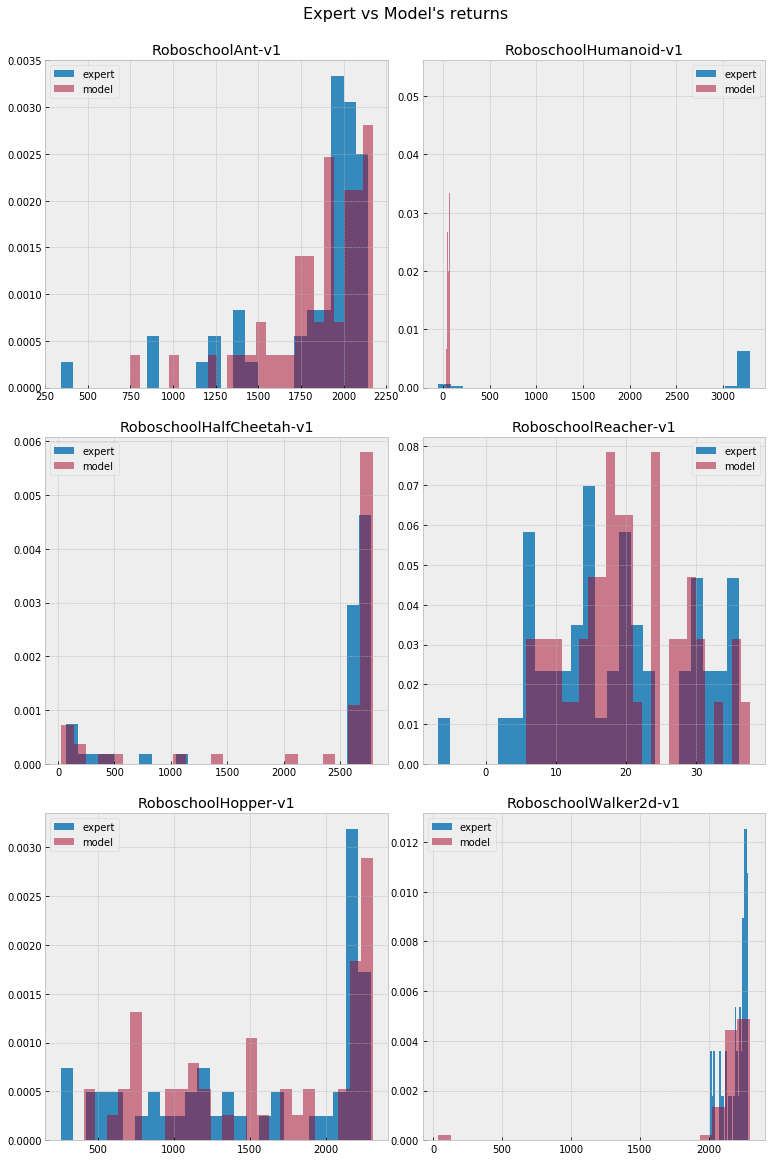

In [24]:
env_index = 0
fig_title = "Expert vs Model's returns"
density = True # If true, than the histogram's integral sums up to 1

for ax in grid_iterator(n_rows=3, n_cols=2, axis_size=5, fig_title=fig_title):
    env_name = AVAILABLE_ENVS[env_index]
    env_index+=1
    
    ax.hist(returns[env_name]['expert'], label='expert', density=density, bins=25)
    ax.hist(returns[env_name]['model'], label='model', density=density, bins=25, alpha=0.5)
    ax.set_aspect('auto')
    ax.set_title(env_name)
    ax.legend()


### With dropout and batchnorm

In [ ]:
env_index = 0
fig_title = "Expert vs Model's returns"
density = True # If true, than the histogram's integral sums up to 1

for ax in grid_iterator(n_rows=3, n_cols=2, axis_size=5, fig_title=fig_title):
    env_name = AVAILABLE_ENVS[env_index]
    env_index+=1
    
    ax.hist(returns[env_name]['expert'], label='expert', density=density, bins=25)
    ax.hist(returns[env_name]['model'], label='model', density=density, bins=25, alpha=0.5)
    ax.set_aspect('auto')
    ax.set_title(env_name)
    ax.legend()


## Calculate the stats

In [25]:
from hw1.manage_datasets import load_dataset

envs_stats = []
for env_name in AVAILABLE_ENVS:
    expert_data = load_dataset(dataset_name=env_name, dataset_dir=EXPERT_DATA_DIR)
    dataset_size = len(expert_data['observations'])
    expert_returns = expert_data['returns']
    model_returns = load_dataset(dataset_name=env_name, dataset_dir=SUPERVISED_MODELD_DATA_DIR)['returns']
    
    env_stats = {
        'env_name': env_name,
        'dataset_size': dataset_size,
        'expert_mean': expert_returns.mean(),
        'expert_std': expert_returns.std(),
        'model_mean': model_returns.mean(),
        'model_std': model_returns.std(),
    }
    envs_stats.append(env_stats)
    

loading dataset RoboschoolAnt-v1
loading dataset RoboschoolAnt-v1
loading dataset RoboschoolHumanoid-v1
loading dataset RoboschoolHumanoid-v1
loading dataset RoboschoolHalfCheetah-v1
loading dataset RoboschoolHalfCheetah-v1
loading dataset RoboschoolReacher-v1
loading dataset RoboschoolReacher-v1
loading dataset RoboschoolHopper-v1
loading dataset RoboschoolHopper-v1
loading dataset RoboschoolWalker2d-v1
loading dataset RoboschoolWalker2d-v1


In [26]:
cols = ['env_name', 'dataset_size','expert_mean', 'model_mean', 'expert_std', 'model_std']
df2 = pd.DataFrame(envs_stats)[cols]
df2['model_to_expert'] = df2['model_mean'] / df2['expert_mean']
df2.sort_values(['dataset_size', 'model_to_expert'], ascending=False, inplace=True)

In [27]:
df2

,env_name,dataset_size,expert_mean,model_mean,expert_std,model_std,model_to_expert
0,RoboschoolAnt-v1,50000,1818.829300,1844.283954,381.867818,307.360874,1.013995
5,RoboschoolWalker2d-v1,50000,2205.412558,2146.176260,81.940065,309.945304,0.973140
1,RoboschoolHumanoid-v1,44444,2848.910280,54.546204,1033.996305,14.689183,0.019146
2,RoboschoolHalfCheetah-v1,42602,2271.298439,2243.406738,909.003381,947.148682,0.987720
4,RoboschoolHopper-v1,35778,1541.857022,1581.175253,687.020552,634.960057,1.025501
3,RoboschoolReacher-v1,7500,18.612237,20.090711,10.257760,8.078745,1.079436


# Comparing RoboschoolAnt-v1 and RoboschoolHumanoid-v1
1. Dataset size: train dataset was about the same size, 45K for the RoboschoolAnt-v1 (90% of 50K) vs 40K for the RoboschoolHumanoid-v1. 
2. Model architecture: the same model arcitecture was used for both tasks: 3 Fully Connected layers with 100 neurons each. L2 regularization of 1e-04 was used with no dropout nor Batch Normalization. 
3. Optimizer, Epochs and Learning rate: both models were trained for 100 epochs with Adam optimizer with initial learning rate of 1e-03. The learning rate was halved after every five cosecutive epochs with no Validation MSE improvement.
4. Performance: for the RoboschoolAnt-v1, the model performance outperformed the expert by ~1.3%. For the RoboschoolHumanoid-v1 task the model achived less than %2 (~1.9%) of the expert mean reward. For the RoboschoolAnt-v1 task, the return std was also decreased (expert std of ~382, vs model's std of ~307)

## Check model performance vs number of epochs for RoboschoolAnt-v1
The RoboschoolAnt-v1 model significantly outperformed RoboschoolHumanoid-v1 model's performance against the expert. It would be interesting to see the the amount of training data needed in order to reach these performance. Another objective is to validate that the perfomance gap between the two tasks was not couse by the fact that RoboschoolHumanoid-v1 was train on a smaller dataset (45K for RoboschoolAnt-v1 vs 40K for RoboschoolHumanoid-v1).

Note - we will plot the performance in terms of validation loss instead of model_mean/expert_mean in order to avoid running the full 50 trajectories on all training set sizes. In addition, we will report the model_mean/expert_mean specifically for the specific case of training over 40K examples, in order to assure that the performance difference with RoboschoolHumanoid-v1 was not cause by the training set size.


In [40]:
import keras
from keras.callbacks import Callback, LambdaCallback, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from hw1.manage_datasets import get_datasets
from keras_helpers.model_helper import create_model, get_model_name, calc_mse
from keras_helpers.keras_train_stats import KerasTrainStats



ANT_SAVED_MODELS_DIR = 'hw1/ant_models'
MODEL_FILE_NAME = "base.hdf5"
create_dir_if_not_exists(SAVED_MODELS_DIR)

model_mse = []
env_name = 'RoboschoolAnt-v1'
# Load the datasets once
X_train, X_test, y_train, y_test = get_datasets(dataset_name=env_name, dataset_dir=EXPERT_DATA_DIR)

for train_size in range(10000, 50000, 10000):  # [10000, 20000, 30000, 40000]
    print("Training a FC ANN for env %s over a training set size %d " % (env_name, train_size))
    
    # Define the model params   
    config_dict = dict(
        input_dim=len(X_train[1, :]),
        output_dim=len(y_train[1, :]),
        units=100,
        layers = 3,
        l2_reg = 1e-04,
        optimizer_cls=keras.optimizers.Adam,
        lr = 1e-03,
        dropout=None,
        use_batchnorm=False)
    
    # Create the model
    model = create_model(**config_dict)
    
    # Compile the model
    optimizer = config_dict['optimizer_cls'](lr=config_dict['lr'])
    model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])
    
    # Set a unique name/directory for the model
    base_name = "%s_training_set_size_%d" % (env_name, train_size)
    model_name = get_model_name(base_name=base_name, **config_dict)
    model_path = os.path.join(SAVED_MODELS_DIR, model_name)
    print("model_name='%s'" % model_name)
    print("model_path='%s'" % model_path)
    create_dir_if_not_exists(model_path)
    model_filename = os.path.join(model_path, MODEL_FILE_NAME)
    
    
    # Train the model
    reduce_lr = ReduceLROnPlateau(monitor='val_mean_squared_error', factor=0.5, patience=5, verbose=1)
    tf_board = TensorBoard()

    # Define a train_stats object
    train_stats = KerasTrainStats(model_name=model_name, history_dir=model_path)


    # Train the model
    batch_size = 64
    epochs = 100

    _ = model.fit([X_train[0:train_size]], y_train[0:train_size],
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[train_stats.print_callback, reduce_lr, tf_board],
        validation_data=([X_test], y_test)
        )
    
    # Save the model
    model.save(model_filename)
    print(model_filename)
    
    # Calculate the MSE for each 
    res = calc_mse(model, env_name, X_train, X_test, y_train, y_test)
    res['model_name'] = model_name
    res['model_path'] = model_path
    model_mse.append(res)
    print("Done training model for %s" % env_name)
    #print("KerasTrainStats(model_name=model_name, history_dir=model_path).plt_history(start_epoch=5, metric_str='mean_squared_error', title='%s MSE')" % dataset_name)
    print(res)

loading dataset RoboschoolAnt-v1
Domain name: RoboschoolAnt-v1
(45000, 28) (5000, 28) (45000, 8) (5000, 8)
Training a FC ANN for env RoboschoolAnt-v1 over a training set size 10000 
model_name='model_RoboschoolAnt-v1_training_set_size_10000_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_None_dropout_without_batchnorm'
model_path='hw1/models/model_RoboschoolAnt-v1_training_set_size_10000_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_None_dropout_without_batchnorm'
Train on 10000 samples, validate on 5000 samples
Epoch 1/100
10000/10000 [==============================] - 1s 99us/step - loss: 0.6922 - mean_squared_error: 0.6680 - val_loss: 0.4279 - val_mean_squared_error: 0.4028
Epoch 2/100
10000/10000 [==============================] - 0s 46us/step - loss: 0.3670 - mean_squared_error: 0.3410 - val_loss: 0.3179 - val_mean_squared_error: 0.2910
Epoch 3/100
10000/10000 [==============================] - 0s 47us/step - loss: 0.2843 - mean_squared_error: 0.2566 - val_loss: 0.

Epoch 46/100
10000/10000 [==============================] - 0s 43us/step - loss: 0.0964 - mean_squared_error: 0.0654 - val_loss: 0.1168 - val_mean_squared_error: 0.0858
Epoch 47/100
10000/10000 [==============================] - 0s 47us/step - loss: 0.0956 - mean_squared_error: 0.0647 - val_loss: 0.1164 - val_mean_squared_error: 0.0855
Epoch 48/100
10000/10000 [==============================] - 0s 45us/step - loss: 0.0960 - mean_squared_error: 0.0651 - val_loss: 0.1151 - val_mean_squared_error: 0.0842
Epoch 49/100
10000/10000 [==============================] - 0s 46us/step - loss: 0.0956 - mean_squared_error: 0.0647 - val_loss: 0.1164 - val_mean_squared_error: 0.0855
Epoch 50/100
10000/10000 [==============================] - 0s 48us/step - loss: 0.0949 - mean_squared_error: 0.0641 - val_loss: 0.1143 - val_mean_squared_error: 0.0835
Epoch 51/100
10000/10000 [==============================] - 0s 41us/step - loss: 0.0943 - mean_squared_error: 0.0635 - val_loss: 0.1158 - val_mean_squared_

10000/10000 [==============================] - 0s 47us/step - loss: 0.0815 - mean_squared_error: 0.0519 - val_loss: 0.1049 - val_mean_squared_error: 0.0753
Epoch 93/100
10000/10000 [==============================] - 0s 46us/step - loss: 0.0814 - mean_squared_error: 0.0519 - val_loss: 0.1049 - val_mean_squared_error: 0.0753
Epoch 94/100
10000/10000 [==============================] - 0s 44us/step - loss: 0.0814 - mean_squared_error: 0.0518 - val_loss: 0.1048 - val_mean_squared_error: 0.0753
Epoch 95/100
10000/10000 [==============================] - 0s 42us/step - loss: 0.0814 - mean_squared_error: 0.0518 - val_loss: 0.1049 - val_mean_squared_error: 0.0753
Epoch 96/100
10000/10000 [==============================] - 0s 43us/step - loss: 0.0814 - mean_squared_error: 0.0518 - val_loss: 0.1048 - val_mean_squared_error: 0.0752
Epoch 97/100
10000/10000 [==============================] - 0s 42us/step - loss: 0.0813 - mean_squared_error: 0.0518 - val_loss: 0.1050 - val_mean_squared_error: 0.0754

Epoch 34/100
20000/20000 [==============================] - 1s 37us/step - loss: 0.0971 - mean_squared_error: 0.0689 - val_loss: 0.1069 - val_mean_squared_error: 0.0788
Epoch 35/100
20000/20000 [==============================] - 1s 36us/step - loss: 0.0958 - mean_squared_error: 0.0677 - val_loss: 0.1072 - val_mean_squared_error: 0.0792
Epoch 36/100
20000/20000 [==============================] - 1s 38us/step - loss: 0.0950 - mean_squared_error: 0.0670 - val_loss: 0.1039 - val_mean_squared_error: 0.0760
Epoch 37/100
20000/20000 [==============================] - 1s 36us/step - loss: 0.0953 - mean_squared_error: 0.0675 - val_loss: 0.1032 - val_mean_squared_error: 0.0754
Epoch 38/100
20000/20000 [==============================] - 1s 36us/step - loss: 0.0934 - mean_squared_error: 0.0657 - val_loss: 0.1047 - val_mean_squared_error: 0.0770
Epoch 39/100
20000/20000 [==============================] - ETA: 0s - loss: 0.0935 - mean_squared_error: 0.06 - 1s 36us/step - loss: 0.0936 - mean_squared_

20000/20000 [==============================] - 1s 38us/step - loss: 0.0700 - mean_squared_error: 0.0456 - val_loss: 0.0833 - val_mean_squared_error: 0.0589
Epoch 82/100
20000/20000 [==============================] - 1s 37us/step - loss: 0.0698 - mean_squared_error: 0.0455 - val_loss: 0.0851 - val_mean_squared_error: 0.0608
Epoch 83/100
20000/20000 [==============================] - 1s 37us/step - loss: 0.0696 - mean_squared_error: 0.0453 - val_loss: 0.0830 - val_mean_squared_error: 0.0587
Epoch 84/100
20000/20000 [==============================] - 1s 38us/step - loss: 0.0696 - mean_squared_error: 0.0453 - val_loss: 0.0831 - val_mean_squared_error: 0.0589
Epoch 85/100
20000/20000 [==============================] - 1s 38us/step - loss: 0.0693 - mean_squared_error: 0.0450 - val_loss: 0.0838 - val_mean_squared_error: 0.0595
Epoch 86/100
20000/20000 [==============================] - 1s 38us/step - loss: 0.0694 - mean_squared_error: 0.0452 - val_loss: 0.0837 - val_mean_squared_error: 0.0595

30000/30000 [==============================] - 2s 56us/step - loss: 0.0982 - mean_squared_error: 0.0691 - val_loss: 0.1034 - val_mean_squared_error: 0.0745
Epoch 23/100
30000/30000 [==============================] - 1s 50us/step - loss: 0.0970 - mean_squared_error: 0.0682 - val_loss: 0.1003 - val_mean_squared_error: 0.0716
Epoch 24/100
30000/30000 [==============================] - 1s 41us/step - loss: 0.0959 - mean_squared_error: 0.0673 - val_loss: 0.1015 - val_mean_squared_error: 0.0730
Epoch 25/100
30000/30000 [==============================] - 1s 40us/step - loss: 0.0951 - mean_squared_error: 0.0667 - val_loss: 0.1022 - val_mean_squared_error: 0.0739
Epoch 26/100
30000/30000 [==============================] - 1s 40us/step - loss: 0.0940 - mean_squared_error: 0.0658 - val_loss: 0.0997 - val_mean_squared_error: 0.0716
Epoch 27/100
30000/30000 [==============================] - 1s 42us/step - loss: 0.0929 - mean_squared_error: 0.0649 - val_loss: 0.0999 - val_mean_squared_error: 0.0720

30000/30000 [==============================] - 1s 37us/step - loss: 0.0695 - mean_squared_error: 0.0451 - val_loss: 0.0783 - val_mean_squared_error: 0.0540
Epoch 70/100
30000/30000 [==============================] - 1s 36us/step - loss: 0.0693 - mean_squared_error: 0.0450 - val_loss: 0.0789 - val_mean_squared_error: 0.0545
Epoch 71/100
30000/30000 [==============================] - 1s 40us/step - loss: 0.0693 - mean_squared_error: 0.0450 - val_loss: 0.0782 - val_mean_squared_error: 0.0539
Epoch 72/100
30000/30000 [==============================] - 1s 39us/step - loss: 0.0691 - mean_squared_error: 0.0449 - val_loss: 0.0782 - val_mean_squared_error: 0.0540
Epoch 73/100
30000/30000 [==============================] - 1s 35us/step - loss: 0.0690 - mean_squared_error: 0.0448 - val_loss: 0.0780 - val_mean_squared_error: 0.0538
Epoch 74/100
30000/30000 [==============================] - 1s 36us/step - loss: 0.0690 - mean_squared_error: 0.0448 - val_loss: 0.0788 - val_mean_squared_error: 0.0546

40000/40000 [==============================] - 2s 42us/step - loss: 0.1163 - mean_squared_error: 0.0854 - val_loss: 0.1185 - val_mean_squared_error: 0.0877
Epoch 11/100
40000/40000 [==============================] - 2s 41us/step - loss: 0.1128 - mean_squared_error: 0.0822 - val_loss: 0.1126 - val_mean_squared_error: 0.0822
Epoch 12/100
40000/40000 [==============================] - 2s 41us/step - loss: 0.1101 - mean_squared_error: 0.0799 - val_loss: 0.1119 - val_mean_squared_error: 0.0818
Epoch 13/100
40000/40000 [==============================] - 1s 37us/step - loss: 0.1077 - mean_squared_error: 0.0778 - val_loss: 0.1108 - val_mean_squared_error: 0.0811
Epoch 14/100
40000/40000 [==============================] - 2s 42us/step - loss: 0.1049 - mean_squared_error: 0.0754 - val_loss: 0.1113 - val_mean_squared_error: 0.0819
Epoch 15/100
40000/40000 [==============================] - 2s 41us/step - loss: 0.1035 - mean_squared_error: 0.0743 - val_loss: 0.1060 - val_mean_squared_error: 0.0770

40000/40000 [==============================] - 2s 38us/step - loss: 0.0706 - mean_squared_error: 0.0480 - val_loss: 0.0750 - val_mean_squared_error: 0.0524
Epoch 59/100
40000/40000 [==============================] - 2s 40us/step - loss: 0.0702 - mean_squared_error: 0.0477 - val_loss: 0.0755 - val_mean_squared_error: 0.0530
Epoch 60/100
40000/40000 [==============================] - 2s 38us/step - loss: 0.0701 - mean_squared_error: 0.0477 - val_loss: 0.0761 - val_mean_squared_error: 0.0536
Epoch 61/100
40000/40000 [==============================] - 2s 38us/step - loss: 0.0697 - mean_squared_error: 0.0473 - val_loss: 0.0747 - val_mean_squared_error: 0.0523
Epoch 62/100
40000/40000 [==============================] - 2s 38us/step - loss: 0.0698 - mean_squared_error: 0.0475 - val_loss: 0.0749 - val_mean_squared_error: 0.0526
Epoch 63/100
40000/40000 [==============================] - 2s 39us/step - loss: 0.0696 - mean_squared_error: 0.0473 - val_loss: 0.0753 - val_mean_squared_error: 0.0531

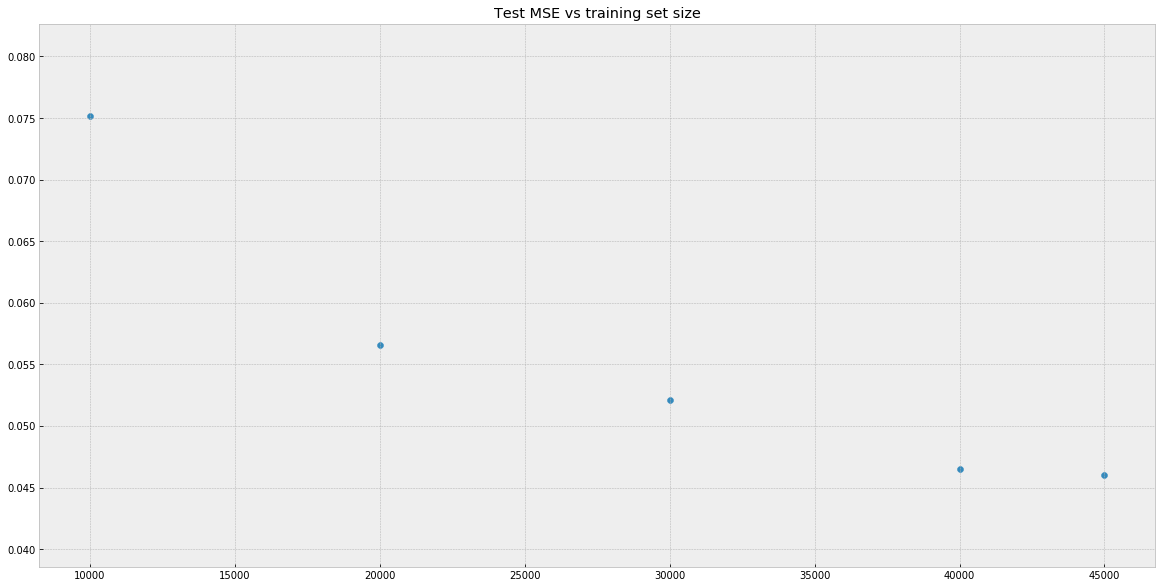

In [53]:
# get the test MSE error for each of the models
roboschool_ant_df = pd.DataFrame(model_mse)
test_mse = roboschool_ant_df['test_mse'].tolist()

# Add the test MSE error we previously got for the training set size of 45K
test_mse_45k = 0.046053225442220666
test_mse.append(test_mse_45k)

# Scatter plot
plt.figure(figsize=(20,10))
scatter(x=[1e+4, 2e+4, 3e+4, 4e+4, 45000], y=test_mse)
_ = plt.title("Test MSE vs training set size")

There is a significant improvement in terms of MSE when increasing the dataset size upto 40K. On the contrary, there seems to be a very subtle performance improvement between 40K and 45K (0.0465 MSE vs 0.04605 respectively). We will also calculate the 40K model mean return vs the expert return. 

### Generate the trajectories using the 40K model and compare the results

In [69]:
ant_40k_model_filename = 'hw1/models/model_RoboschoolAnt-v1_training_set_size_40000_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_None_dropout_without_batchnorm/base.hdf5'
policy = SupervisedModelPolicy(env_name, model_filename=ant_40k_model_filename)
env = gym.make(env_name)
description = "Supervised model policy for module %s with a smaller training set of 40K examples" % env_name
%time supervised_modeled_data = run_policy(env=env, policy=policy, num_rollouts=50, \
                                           description=description, verbose=False)

env.close()

Env description: Supervised model policy for module RoboschoolAnt-v1 with a smaller training set of 40K examples
mean return 1906.4720582679638
std of return 338.23867998992245
CPU times: user 2min 56s, sys: 1min 13s, total: 4min 10s
Wall time: 4min 2s


In [72]:
returns = supervised_modeled_data['returns']
returns.mean(), returns.std()

(1906.4720582679638, 338.23867998992245)

The models returns were even better than the expert and the model trained over 45K examples. 


Maybe this means that the expert model is overfitted?

# DAgger
We will run the DAgger algorithm on the RoboschoolHumanoid-v1 task for which our model had the worst returns. 

## Pseudo code

Initial ANN model (we already did this part)
1. Generate trajectories from an expert policy and build a dataset $D=$ {$o_1, a_1...,o_n, a_n$}
2. Train a function approximator (ANN) $\pi_\theta(o_t|a_t)$ over $D$

Improving the model with expert data:  
Loop:
1. Generate k trajectories using $\pi_\theta(o_t|a_t)$: for each observasion ($o_t$) in each trajectory, "ask" the expert policy for the appropriate action for each observation and use it as a label for a new dataset $D_\pi$
2. Aggregate: $D\leftarrow D \cup D_\pi$
3. Train a function approximator (ANN) $\pi_\theta(o_t|a_t)$ over $D$

In [149]:
class DAgagger():
    def __init__(self, env_name, dest_model_dir, model_filename=None, update_epoch_num=5, 
                 saved_iterations=5, batch_size=64, dataset_dir=EXPERT_DATA_DIR):
        """
        saved_iterations: int or None - save model after nuber of iterations 
        """
        # Create the environment and the policy object
        self.env_name = env_name
        self.env = gym.make(env_name)
        self.policy = SupervisedModelPolicy(env_name, model_filename=model_filename)
        # Set a reference to the policy model
        self._model = self.policy.model
        
        # Load train/test set
        X_train, X_test, y_train, y_test = get_datasets(dataset_name=env_name, dataset_dir=dataset_dir)
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        self.update_epoch_num = update_epoch_num
        self._num_epdates = 0
        self.batch_size = batch_size
        self.saved_iterations = saved_iterations
        
        self.dest_model_dir = dest_model_dir
        create_dir_if_not_exists(dest_model_dir)
        
        self._steps_data = []
        self.calc_step_data()
        
    
    def get_steps_data(self):
        return pd.DataFrame(self._steps_data)
        
    
    def _update_datasets(self, X_new, y_new, aggregate=True):
        """Add the additional trajectories dataset to the training set"""
        # Concatenate the previous training set with the new samples
        if aggregate:
            self.X_train = np.concatenate((self.X_train, X_new), axis=0)
            self.y_train = np.concatenate((self.y_train, y_new), axis=0)
        
        # Replace the entire training set with the new samples
        else:
            self.X_train = X_new
            self.y_train = y_new
    
    def update_policy(self, X_new, y_new, update_epoch_num=None, batch_size=None, aggregate=True):
        # Update the saved datasets
        self._update_datasets(X_new, y_new, aggregate=aggregate)
        
        # Run update_epoch_num iterations
        if update_epoch_num is None:
            update_epoch_num = self.update_epoch_num
        
        # TODO: add batch_size as a parameter
        if batch_size is None:
            batch_size = self.batch_size
        
        # Train additional 'epochs' number of epochs on the new dataset
        _ = self._model.fit([self.X_train], self.y_train,
                batch_size=batch_size,
                epochs=update_epoch_num,
                validation_data=([self.X_test], self.y_test)
            )
        
#         # Calculate the MSE for each 
#         res = calc_mse(model, env_name, self.X_train, self.X_test, self.y_train, self.y_test)
#         res['model_name'] = model_name
#         res['model_path'] = model_path
#         model_mse.append(res)
#         print("Done training model for %s" % env_name)
#         #print("KerasTrainStats(model_name=model_name, history_dir=model_path).plt_history(start_epoch=5, metric_str='mean_squared_error', title='%s MSE')" % dataset_name)
#         print(res)
        
    
    def create_trajectories(self, k, max_timesteps=None):
        # Run k trajectories using the current policy
        description = "Runnig DAgger iteration %d on env %s" % (self._num_epdates, env_name)
        model_data = run_policy(env=self.env, policy=self.policy, num_rollouts=k, description=description, 
                                render=False, verbose=False, max_timesteps=max_timesteps)
        
        X_new = model_data['observations']
        y_new = model_data['actions']
        returns = model_data['returns']
        return X_new, y_new, returns
    
    
    def step(self, k, update_epoch_num=None, max_timesteps=None, aggregate=True):
        # Generate trajectories using corrent policy
        X_new, y_new, returns = self.create_trajectories(k=k, max_timesteps=max_timesteps)
        # Update policy
        self.update_policy(X_new, y_new, update_epoch_num=update_epoch_num, aggregate=aggregate)
        
        # Increase the internal update count
        self._num_epdates +=1
        
        # Save the model
        saved_iterations = self.saved_iterations
        if saved_iterations and not self._num_epdates % saved_iterations:
            model_name = "%s_DAgger_update_%d.hdf5" % (env_name, self._num_epdates)
            model_path = os.path.join(self.dest_model_dir, model_name)
            model.save(model_path)
            print("Saving model %s after update number %d" % (model_name, self._num_epdates))
            
        self.calc_step_data()

    def calc_step_data(self):
        # Update the steps statistics
        step_data = calc_mse(self._model, self.env_name, self.X_train, self.X_test, self.y_train, self.y_test)
        step_data['iteration'] = self._num_epdates
        self._steps_data.append(step_data)
        print("step_data: %s" % step_data)
    
        

In [150]:
initial_model_filename = 'hw1/models/model_RoboschoolHumanoid-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_None_dropout_without_batchnorm/base.hdf5'
env_name = 'RoboschoolHumanoid-v1'

dest_model_dir = 'hw1/models/DAgger/%s' % env_name

dagger = DAgagger(env_name=env_name, model_filename=initial_model_filename, update_epoch_num=25, saved_iterations=5, batch_size=64, dest_model_dir=dest_model_dir)



/usr/local/lib/python3.5/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


KeyboardInterrupt: 

In [143]:
for i in range(50):
    dagger.step(k=40)

Env description: Runnig DAgger iteration 0 on env RoboschoolHumanoid-v1
mean return 52.27372984527294
std of return 19.566098813105157
Train on 42056 samples, validate on 4445 samples
Epoch 1/25
42056/42056 [==============================] - 4s 94us/sample - loss: 0.0196 - mean_squared_error: 0.0118 - val_loss: 0.0215 - val_mean_squared_error: 0.0136
Epoch 2/25
42056/42056 [==============================] - 2s 48us/sample - loss: 0.0196 - mean_squared_error: 0.0118 - val_loss: 0.0215 - val_mean_squared_error: 0.0136
Epoch 3/25
42056/42056 [==============================] - 2s 48us/sample - loss: 0.0196 - mean_squared_error: 0.0118 - val_loss: 0.0215 - val_mean_squared_error: 0.0136
Epoch 4/25
42056/42056 [==============================] - 2s 48us/sample - loss: 0.0196 - mean_squared_error: 0.0118 - val_loss: 0.0215 - val_mean_squared_error: 0.0136
Epoch 5/25
42056/42056 [==============================] - 2s 54us/sample - loss: 0.0196 - mean_squared_error: 0.0118 - val_loss: 0.0215 - va

44139/44139 [==============================] - 2s 47us/sample - loss: 0.0191 - mean_squared_error: 0.0112 - val_loss: 0.0215 - val_mean_squared_error: 0.0136
Epoch 22/25
44139/44139 [==============================] - 2s 49us/sample - loss: 0.0191 - mean_squared_error: 0.0112 - val_loss: 0.0215 - val_mean_squared_error: 0.0136
Epoch 23/25
44139/44139 [==============================] - 2s 50us/sample - loss: 0.0191 - mean_squared_error: 0.0112 - val_loss: 0.0215 - val_mean_squared_error: 0.0136
Epoch 24/25
44139/44139 [==============================] - 2s 55us/sample - loss: 0.0191 - mean_squared_error: 0.0112 - val_loss: 0.0215 - val_mean_squared_error: 0.0136
Epoch 25/25
44139/44139 [==============================] - 2s 48us/sample - loss: 0.0191 - mean_squared_error: 0.0112 - val_loss: 0.0215 - val_mean_squared_error: 0.0136
step_data: {'train_mse': 0.011234887736525761, 'iteration': 2, 'dataset_name': 'RoboschoolHumanoid-v1', 'test_mse': 0.013618507683586018}
Env description: Runnig 

48343/48343 [==============================] - 2s 47us/sample - loss: 0.0181 - mean_squared_error: 0.0103 - val_loss: 0.0214 - val_mean_squared_error: 0.0136
Epoch 16/25
48343/48343 [==============================] - 3s 52us/sample - loss: 0.0181 - mean_squared_error: 0.0103 - val_loss: 0.0214 - val_mean_squared_error: 0.0136
Epoch 17/25
48343/48343 [==============================] - 2s 47us/sample - loss: 0.0181 - mean_squared_error: 0.0103 - val_loss: 0.0214 - val_mean_squared_error: 0.0136
Epoch 18/25
48343/48343 [==============================] - 4s 82us/sample - loss: 0.0181 - mean_squared_error: 0.0103 - val_loss: 0.0214 - val_mean_squared_error: 0.0136
Epoch 19/25
48343/48343 [==============================] - 2s 47us/sample - loss: 0.0181 - mean_squared_error: 0.0103 - val_loss: 0.0214 - val_mean_squared_error: 0.0136
Epoch 20/25
48343/48343 [==============================] - 2s 44us/sample - loss: 0.0181 - mean_squared_error: 0.0103 - val_loss: 0.0214 - val_mean_squared_error:

52487/52487 [==============================] - 3s 48us/sample - loss: 0.0173 - mean_squared_error: 0.0095 - val_loss: 0.0214 - val_mean_squared_error: 0.0136
Epoch 10/25
52487/52487 [==============================] - 2s 47us/sample - loss: 0.0173 - mean_squared_error: 0.0095 - val_loss: 0.0214 - val_mean_squared_error: 0.0136
Epoch 11/25
52487/52487 [==============================] - 3s 48us/sample - loss: 0.0173 - mean_squared_error: 0.0095 - val_loss: 0.0214 - val_mean_squared_error: 0.0136
Epoch 12/25
52487/52487 [==============================] - 2s 46us/sample - loss: 0.0173 - mean_squared_error: 0.0095 - val_loss: 0.0214 - val_mean_squared_error: 0.0136
Epoch 13/25
52487/52487 [==============================] - 2s 47us/sample - loss: 0.0173 - mean_squared_error: 0.0095 - val_loss: 0.0214 - val_mean_squared_error: 0.0136
Epoch 14/25
52487/52487 [==============================] - 3s 49us/sample - loss: 0.0173 - mean_squared_error: 0.0095 - val_loss: 0.0214 - val_mean_squared_error:

56563/56563 [==============================] - 3s 46us/sample - loss: 0.0166 - mean_squared_error: 0.0088 - val_loss: 0.0214 - val_mean_squared_error: 0.0136
Epoch 4/25
56563/56563 [==============================] - 3s 46us/sample - loss: 0.0166 - mean_squared_error: 0.0088 - val_loss: 0.0214 - val_mean_squared_error: 0.0136
Epoch 5/25
56563/56563 [==============================] - 3s 46us/sample - loss: 0.0166 - mean_squared_error: 0.0088 - val_loss: 0.0214 - val_mean_squared_error: 0.0136
Epoch 6/25
56563/56563 [==============================] - 3s 46us/sample - loss: 0.0166 - mean_squared_error: 0.0088 - val_loss: 0.0214 - val_mean_squared_error: 0.0136
Epoch 7/25
56563/56563 [==============================] - 3s 46us/sample - loss: 0.0166 - mean_squared_error: 0.0088 - val_loss: 0.0214 - val_mean_squared_error: 0.0136
Epoch 8/25
56563/56563 [==============================] - 3s 45us/sample - loss: 0.0166 - mean_squared_error: 0.0088 - val_loss: 0.0214 - val_mean_squared_error: 0.01

58552/58552 [==============================] - 3s 47us/sample - loss: 0.0163 - mean_squared_error: 0.0085 - val_loss: 0.0214 - val_mean_squared_error: 0.0137
Epoch 25/25
58552/58552 [==============================] - 3s 46us/sample - loss: 0.0163 - mean_squared_error: 0.0085 - val_loss: 0.0214 - val_mean_squared_error: 0.0137
step_data: {'train_mse': 0.008512026680249609, 'iteration': 9, 'dataset_name': 'RoboschoolHumanoid-v1', 'test_mse': 0.013669350538778104}
Env description: Runnig DAgger iteration 9 on env RoboschoolHumanoid-v1
mean return 56.214977592988745
std of return 10.167281780813811
Train on 60686 samples, validate on 4445 samples
Epoch 1/25
60686/60686 [==============================] - 3s 46us/sample - loss: 0.0160 - mean_squared_error: 0.0082 - val_loss: 0.0214 - val_mean_squared_error: 0.0137
Epoch 2/25
60686/60686 [==============================] - 3s 45us/sample - loss: 0.0160 - mean_squared_error: 0.0082 - val_loss: 0.0214 - val_mean_squared_error: 0.0137
Epoch 3/25


62724/62724 [==============================] - 3s 45us/sample - loss: 0.0157 - mean_squared_error: 0.0080 - val_loss: 0.0214 - val_mean_squared_error: 0.0137
Epoch 19/25
62724/62724 [==============================] - 3s 45us/sample - loss: 0.0157 - mean_squared_error: 0.0080 - val_loss: 0.0214 - val_mean_squared_error: 0.0137
Epoch 20/25
62724/62724 [==============================] - 3s 45us/sample - loss: 0.0157 - mean_squared_error: 0.0080 - val_loss: 0.0214 - val_mean_squared_error: 0.0137
Epoch 21/25
62724/62724 [==============================] - 3s 46us/sample - loss: 0.0157 - mean_squared_error: 0.0080 - val_loss: 0.0214 - val_mean_squared_error: 0.0137
Epoch 22/25
62724/62724 [==============================] - 3s 46us/sample - loss: 0.0157 - mean_squared_error: 0.0080 - val_loss: 0.0214 - val_mean_squared_error: 0.0137
Epoch 23/25
62724/62724 [==============================] - 3s 45us/sample - loss: 0.0157 - mean_squared_error: 0.0080 - val_loss: 0.0214 - val_mean_squared_error:

66796/66796 [==============================] - 3s 46us/sample - loss: 0.0152 - mean_squared_error: 0.0075 - val_loss: 0.0214 - val_mean_squared_error: 0.01370.0
Epoch 13/25
66796/66796 [==============================] - 3s 45us/sample - loss: 0.0152 - mean_squared_error: 0.0075 - val_loss: 0.0214 - val_mean_squared_error: 0.0137
Epoch 14/25
66796/66796 [==============================] - 3s 46us/sample - loss: 0.0152 - mean_squared_error: 0.0075 - val_loss: 0.0214 - val_mean_squared_error: 0.0137
Epoch 15/25
66796/66796 [==============================] - 3s 46us/sample - loss: 0.0152 - mean_squared_error: 0.0075 - val_loss: 0.0214 - val_mean_squared_error: 0.0137
Epoch 16/25
66796/66796 [==============================] - 3s 45us/sample - loss: 0.0152 - mean_squared_error: 0.0075 - val_loss: 0.0214 - val_mean_squared_error: 0.0137
Epoch 17/25
66796/66796 [==============================] - 3s 45us/sample - loss: 0.0152 - mean_squared_error: 0.0075 - val_loss: 0.0214 - val_mean_squared_err

70809/70809 [==============================] - 3s 44us/sample - loss: 0.0147 - mean_squared_error: 0.0071 - val_loss: 0.0214 - val_mean_squared_error: 0.0138
Epoch 7/25
70809/70809 [==============================] - 3s 45us/sample - loss: 0.0147 - mean_squared_error: 0.0071 - val_loss: 0.0214 - val_mean_squared_error: 0.0138
Epoch 8/25
70809/70809 [==============================] - 3s 43us/sample - loss: 0.0147 - mean_squared_error: 0.0071 - val_loss: 0.0214 - val_mean_squared_error: 0.0138
Epoch 9/25
70809/70809 [==============================] - 3s 43us/sample - loss: 0.0147 - mean_squared_error: 0.0071 - val_loss: 0.0214 - val_mean_squared_error: 0.0138
Epoch 10/25
70809/70809 [==============================] - 3s 44us/sample - loss: 0.0147 - mean_squared_error: 0.0071 - val_loss: 0.0214 - val_mean_squared_error: 0.0138
Epoch 11/25
70809/70809 [==============================] - 3s 45us/sample - loss: 0.0147 - mean_squared_error: 0.0071 - val_loss: 0.0214 - val_mean_squared_error: 0.

74875/74875 [==============================] - 3s 43us/sample - loss: 0.0143 - mean_squared_error: 0.0067 - val_loss: 0.0214 - val_mean_squared_error: 0.0138
Epoch 2/25
74875/74875 [==============================] - 3s 43us/sample - loss: 0.0143 - mean_squared_error: 0.0067 - val_loss: 0.0214 - val_mean_squared_error: 0.0138
Epoch 3/25
74875/74875 [==============================] - 3s 43us/sample - loss: 0.0143 - mean_squared_error: 0.0067 - val_loss: 0.0214 - val_mean_squared_error: 0.0138
Epoch 4/25
74875/74875 [==============================] - 3s 45us/sample - loss: 0.0143 - mean_squared_error: 0.0067 - val_loss: 0.0214 - val_mean_squared_error: 0.0138
Epoch 5/25
74875/74875 [==============================] - 3s 44us/sample - loss: 0.0143 - mean_squared_error: 0.0067 - val_loss: 0.0214 - val_mean_squared_error: 0.0138
Epoch 6/25
74875/74875 [==============================] - 3s 44us/sample - loss: 0.0143 - mean_squared_error: 0.0067 - val_loss: 0.0214 - val_mean_squared_error: 0.01

76994/76994 [==============================] - 3s 43us/sample - loss: 0.0141 - mean_squared_error: 0.0066 - val_loss: 0.0214 - val_mean_squared_error: 0.0138
Epoch 23/25
76994/76994 [==============================] - 3s 44us/sample - loss: 0.0141 - mean_squared_error: 0.0066 - val_loss: 0.0214 - val_mean_squared_error: 0.0138
Epoch 24/25
76994/76994 [==============================] - 3s 45us/sample - loss: 0.0141 - mean_squared_error: 0.0066 - val_loss: 0.0214 - val_mean_squared_error: 0.0138
Epoch 25/25
76994/76994 [==============================] - 3s 44us/sample - loss: 0.0141 - mean_squared_error: 0.0066 - val_loss: 0.0214 - val_mean_squared_error: 0.0138
step_data: {'train_mse': 0.006574817118709176, 'iteration': 18, 'dataset_name': 'RoboschoolHumanoid-v1', 'test_mse': 0.013830599356457206}
Env description: Runnig DAgger iteration 18 on env RoboschoolHumanoid-v1
mean return 59.39240267009579
std of return 14.107377623804242
Train on 79207 samples, validate on 4445 samples
Epoch 1/

Epoch 16/25
81237/81237 [==============================] - 3s 43us/sample - loss: 0.0138 - mean_squared_error: 0.0063 - val_loss: 0.0214 - val_mean_squared_error: 0.0139
Epoch 17/25
81237/81237 [==============================] - 4s 45us/sample - loss: 0.0138 - mean_squared_error: 0.0063 - val_loss: 0.0214 - val_mean_squared_error: 0.0139
Epoch 18/25
81237/81237 [==============================] - 4s 50us/sample - loss: 0.0138 - mean_squared_error: 0.0063 - val_loss: 0.0214 - val_mean_squared_error: 0.0139
Epoch 19/25
81237/81237 [==============================] - 3s 43us/sample - loss: 0.0138 - mean_squared_error: 0.0063 - val_loss: 0.0214 - val_mean_squared_error: 0.0139
Epoch 20/25
81237/81237 [==============================] - 4s 44us/sample - loss: 0.0138 - mean_squared_error: 0.0063 - val_loss: 0.0214 - val_mean_squared_error: 0.0139
Epoch 21/25
81237/81237 [==============================] - 4s 44us/sample - loss: 0.0138 - mean_squared_error: 0.0063 - val_loss: 0.0214 - val_mean_sq

85389/85389 [==============================] - 4s 48us/sample - loss: 0.0134 - mean_squared_error: 0.0060 - val_loss: 0.0214 - val_mean_squared_error: 0.0139
Epoch 11/25
85389/85389 [==============================] - 4s 48us/sample - loss: 0.0134 - mean_squared_error: 0.0060 - val_loss: 0.0214 - val_mean_squared_error: 0.0139
Epoch 12/25
85389/85389 [==============================] - 4s 47us/sample - loss: 0.0134 - mean_squared_error: 0.0060 - val_loss: 0.0214 - val_mean_squared_error: 0.0139
Epoch 13/25
85389/85389 [==============================] - 4s 44us/sample - loss: 0.0134 - mean_squared_error: 0.0060 - val_loss: 0.0214 - val_mean_squared_error: 0.0139
Epoch 14/25
85389/85389 [==============================] - 4s 44us/sample - loss: 0.0134 - mean_squared_error: 0.0060 - val_loss: 0.0214 - val_mean_squared_error: 0.0139
Epoch 15/25
85389/85389 [==============================] - 4s 44us/sample - loss: 0.0134 - mean_squared_error: 0.0060 - val_loss: 0.0214 - val_mean_squared_error:

89577/89577 [==============================] - 4s 44us/sample - loss: 0.0131 - mean_squared_error: 0.0057 - val_loss: 0.0214 - val_mean_squared_error: 0.0140
Epoch 5/25
89577/89577 [==============================] - 4s 44us/sample - loss: 0.0131 - mean_squared_error: 0.0057 - val_loss: 0.0214 - val_mean_squared_error: 0.0140
Epoch 6/25
89577/89577 [==============================] - 4s 44us/sample - loss: 0.0131 - mean_squared_error: 0.0057 - val_loss: 0.0214 - val_mean_squared_error: 0.0140
Epoch 7/25
89577/89577 [==============================] - 4s 43us/sample - loss: 0.0131 - mean_squared_error: 0.0057 - val_loss: 0.0214 - val_mean_squared_error: 0.0140
Epoch 8/25
89577/89577 [==============================] - 4s 44us/sample - loss: 0.0131 - mean_squared_error: 0.0057 - val_loss: 0.0214 - val_mean_squared_error: 0.0140
Epoch 9/25
89577/89577 [==============================] - 4s 43us/sample - loss: 0.0131 - mean_squared_error: 0.0057 - val_loss: 0.0214 - val_mean_squared_error: 0.01

91708/91708 [==============================] - 4s 44us/sample - loss: 0.0130 - mean_squared_error: 0.0056 - val_loss: 0.0214 - val_mean_squared_error: 0.0140
Saving model RoboschoolHumanoid-v1_DAgger_update_25.hdf5 after update number 25
step_data: {'train_mse': 0.005620164406375038, 'iteration': 25, 'dataset_name': 'RoboschoolHumanoid-v1', 'test_mse': 0.014016993705507345}
Env description: Runnig DAgger iteration 25 on env RoboschoolHumanoid-v1
mean return 55.93657150553995
std of return 9.709267828559478
Train on 93792 samples, validate on 4445 samples
Epoch 1/25
93792/93792 [==============================] - 4s 44us/sample - loss: 0.0128 - mean_squared_error: 0.0055 - val_loss: 0.0214 - val_mean_squared_error: 0.0140
Epoch 2/25
93792/93792 [==============================] - 4s 44us/sample - loss: 0.0128 - mean_squared_error: 0.0055 - val_loss: 0.0214 - val_mean_squared_error: 0.0140
Epoch 3/25
93792/93792 [==============================] - 4s 45us/sample - loss: 0.0128 - mean_square

95796/95796 [==============================] - 4s 43us/sample - loss: 0.0127 - mean_squared_error: 0.0054 - val_loss: 0.0214 - val_mean_squared_error: 0.0141
Epoch 20/25
95796/95796 [==============================] - 4s 43us/sample - loss: 0.0127 - mean_squared_error: 0.0054 - val_loss: 0.0214 - val_mean_squared_error: 0.0141
Epoch 21/25
95796/95796 [==============================] - 4s 43us/sample - loss: 0.0127 - mean_squared_error: 0.0054 - val_loss: 0.0214 - val_mean_squared_error: 0.0141
Epoch 22/25
95796/95796 [==============================] - 4s 43us/sample - loss: 0.0127 - mean_squared_error: 0.0054 - val_loss: 0.0214 - val_mean_squared_error: 0.0141
Epoch 23/25
95796/95796 [==============================] - 4s 44us/sample - loss: 0.0127 - mean_squared_error: 0.0054 - val_loss: 0.0214 - val_mean_squared_error: 0.0141
Epoch 24/25
95796/95796 [==============================] - 4s 44us/sample - loss: 0.0127 - mean_squared_error: 0.0054 - val_loss: 0.0214 - val_mean_squared_error:

99966/99966 [==============================] - 4s 44us/sample - loss: 0.0124 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0141
Epoch 14/25
99966/99966 [==============================] - ETA: 0s - loss: 0.0124 - mean_squared_error: 0.00 - 4s 44us/sample - loss: 0.0124 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0141
Epoch 15/25
99966/99966 [==============================] - 4s 43us/sample - loss: 0.0124 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0141
Epoch 16/25
99966/99966 [==============================] - 4s 43us/sample - loss: 0.0124 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0141
Epoch 17/25
99966/99966 [==============================] - 4s 43us/sample - loss: 0.0124 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0141
Epoch 18/25
99966/99966 [==============================] - 4s 43us/sample - loss: 0.0124 - mean_squared_error:

104088/104088 [==============================] - 5s 46us/sample - loss: 0.0122 - mean_squared_error: 0.0050 - val_loss: 0.0214 - val_mean_squared_error: 0.0142
Epoch 7/25
104088/104088 [==============================] - 5s 45us/sample - loss: 0.0122 - mean_squared_error: 0.0050 - val_loss: 0.0214 - val_mean_squared_error: 0.0142
Epoch 8/25
104088/104088 [==============================] - 5s 45us/sample - loss: 0.0122 - mean_squared_error: 0.0050 - val_loss: 0.0214 - val_mean_squared_error: 0.0142
Epoch 9/25
104088/104088 [==============================] - 5s 46us/sample - loss: 0.0122 - mean_squared_error: 0.0050 - val_loss: 0.0214 - val_mean_squared_error: 0.0142
Epoch 10/25
104088/104088 [==============================] - 5s 46us/sample - loss: 0.0122 - mean_squared_error: 0.0050 - val_loss: 0.0214 - val_mean_squared_error: 0.0142
Epoch 11/25
104088/104088 [==============================] - 5s 46us/sample - loss: 0.0122 - mean_squared_error: 0.0050 - val_loss: 0.0214 - val_mean_squar

108289/108289 [==============================] - 5s 45us/sample - loss: 0.0120 - mean_squared_error: 0.0049 - val_loss: 0.0214 - val_mean_squared_error: 0.0142
Epoch 2/25
108289/108289 [==============================] - 5s 46us/sample - loss: 0.0120 - mean_squared_error: 0.0049 - val_loss: 0.0214 - val_mean_squared_error: 0.0142
Epoch 3/25
108289/108289 [==============================] - 5s 46us/sample - loss: 0.0120 - mean_squared_error: 0.0049 - val_loss: 0.0214 - val_mean_squared_error: 0.0142
Epoch 4/25
108289/108289 [==============================] - 5s 45us/sample - loss: 0.0120 - mean_squared_error: 0.0049 - val_loss: 0.0214 - val_mean_squared_error: 0.0142
Epoch 5/25
108289/108289 [==============================] - 5s 45us/sample - loss: 0.0120 - mean_squared_error: 0.0049 - val_loss: 0.0214 - val_mean_squared_error: 0.0142
Epoch 6/25
108289/108289 [==============================] - 5s 46us/sample - loss: 0.0120 - mean_squared_error: 0.0049 - val_loss: 0.0214 - val_mean_squared

110312/110312 [==============================] - 5s 44us/sample - loss: 0.0119 - mean_squared_error: 0.0048 - val_loss: 0.0214 - val_mean_squared_error: 0.0143
Epoch 22/25
110312/110312 [==============================] - 5s 45us/sample - loss: 0.0119 - mean_squared_error: 0.0048 - val_loss: 0.0214 - val_mean_squared_error: 0.0143
Epoch 23/25
110312/110312 [==============================] - 5s 43us/sample - loss: 0.0119 - mean_squared_error: 0.0048 - val_loss: 0.0214 - val_mean_squared_error: 0.0143
Epoch 24/25
110312/110312 [==============================] - 5s 43us/sample - loss: 0.0119 - mean_squared_error: 0.0048 - val_loss: 0.0214 - val_mean_squared_error: 0.0143
Epoch 25/25
110312/110312 [==============================] - 5s 43us/sample - loss: 0.0119 - mean_squared_error: 0.0048 - val_loss: 0.0214 - val_mean_squared_error: 0.0143
step_data: {'train_mse': 0.00480617411171436, 'iteration': 34, 'dataset_name': 'RoboschoolHumanoid-v1', 'test_mse': 0.01430429668318721}
Env description

114386/114386 [==============================] - 5s 43us/sample - loss: 0.0117 - mean_squared_error: 0.0047 - val_loss: 0.0214 - val_mean_squared_error: 0.0144
Epoch 15/25
114386/114386 [==============================] - 5s 43us/sample - loss: 0.0117 - mean_squared_error: 0.0047 - val_loss: 0.0214 - val_mean_squared_error: 0.0144
Epoch 16/25
114386/114386 [==============================] - 5s 43us/sample - loss: 0.0117 - mean_squared_error: 0.0047 - val_loss: 0.0214 - val_mean_squared_error: 0.0144
Epoch 17/25
114386/114386 [==============================] - 5s 44us/sample - loss: 0.0117 - mean_squared_error: 0.0047 - val_loss: 0.0214 - val_mean_squared_error: 0.0144
Epoch 18/25
114386/114386 [==============================] - 5s 43us/sample - loss: 0.0117 - mean_squared_error: 0.0047 - val_loss: 0.0214 - val_mean_squared_error: 0.0144
Epoch 19/25
114386/114386 [==============================] - 5s 44us/sample - loss: 0.0117 - mean_squared_error: 0.0047 - val_loss: 0.0214 - val_mean_sq

118489/118489 [==============================] - 5s 44us/sample - loss: 0.0115 - mean_squared_error: 0.0045 - val_loss: 0.0214 - val_mean_squared_error: 0.0144
Epoch 9/25
118489/118489 [==============================] - 5s 43us/sample - loss: 0.0115 - mean_squared_error: 0.0045 - val_loss: 0.0214 - val_mean_squared_error: 0.0144s - loss: 0.0115 - mean_squared_error: 0.
Epoch 10/25
118489/118489 [==============================] - 5s 43us/sample - loss: 0.0115 - mean_squared_error: 0.0045 - val_loss: 0.0214 - val_mean_squared_error: 0.0144
Epoch 11/25
118489/118489 [==============================] - 5s 43us/sample - loss: 0.0115 - mean_squared_error: 0.0045 - val_loss: 0.0214 - val_mean_squared_error: 0.0144
Epoch 12/25
118489/118489 [==============================] - 5s 42us/sample - loss: 0.0115 - mean_squared_error: 0.0045 - val_loss: 0.0214 - val_mean_squared_error: 0.0144
Epoch 13/25
118489/118489 [==============================] - 5s 43us/sample - loss: 0.0115 - mean_squared_error:

Epoch 2/25
122575/122575 [==============================] - 5s 44us/sample - loss: 0.0113 - mean_squared_error: 0.0044 - val_loss: 0.0214 - val_mean_squared_error: 0.0145
Epoch 3/25
122575/122575 [==============================] - 5s 44us/sample - loss: 0.0113 - mean_squared_error: 0.0044 - val_loss: 0.0214 - val_mean_squared_error: 0.0145
Epoch 4/25
122575/122575 [==============================] - 5s 43us/sample - loss: 0.0113 - mean_squared_error: 0.0044 - val_loss: 0.0214 - val_mean_squared_error: 0.0145
Epoch 5/25
122575/122575 [==============================] - 5s 44us/sample - loss: 0.0113 - mean_squared_error: 0.0044 - val_loss: 0.0214 - val_mean_squared_error: 0.0145
Epoch 6/25
122575/122575 [==============================] - 5s 44us/sample - loss: 0.0113 - mean_squared_error: 0.0044 - val_loss: 0.0214 - val_mean_squared_error: 0.0145
Epoch 7/25
122575/122575 [==============================] - 5s 44us/sample - loss: 0.0113 - mean_squared_error: 0.0044 - val_loss: 0.0214 - val_m

124575/124575 [==============================] - 5s 44us/sample - loss: 0.0112 - mean_squared_error: 0.0044 - val_loss: 0.0214 - val_mean_squared_error: 0.0145
Epoch 23/25
124575/124575 [==============================] - 5s 44us/sample - loss: 0.0112 - mean_squared_error: 0.0044 - val_loss: 0.0214 - val_mean_squared_error: 0.0145
Epoch 24/25
124575/124575 [==============================] - 5s 43us/sample - loss: 0.0112 - mean_squared_error: 0.0044 - val_loss: 0.0214 - val_mean_squared_error: 0.0145
Epoch 25/25
124575/124575 [==============================] - 6s 45us/sample - loss: 0.0112 - mean_squared_error: 0.0044 - val_loss: 0.0214 - val_mean_squared_error: 0.0146
step_data: {'train_mse': 0.0043613774018127025, 'iteration': 41, 'dataset_name': 'RoboschoolHumanoid-v1', 'test_mse': 0.014550593350258476}
Env description: Runnig DAgger iteration 41 on env RoboschoolHumanoid-v1
mean return 56.18720020341512
std of return 14.823793669325728
Train on 126612 samples, validate on 4445 sample

128701/128701 [==============================] - 6s 43us/sample - loss: 0.0110 - mean_squared_error: 0.0042 - val_loss: 0.0214 - val_mean_squared_error: 0.0146
Epoch 17/25
128701/128701 [==============================] - 6s 43us/sample - loss: 0.0110 - mean_squared_error: 0.0042 - val_loss: 0.0214 - val_mean_squared_error: 0.0146
Epoch 18/25
128701/128701 [==============================] - 6s 44us/sample - loss: 0.0110 - mean_squared_error: 0.0042 - val_loss: 0.0214 - val_mean_squared_error: 0.0146
Epoch 19/25
128701/128701 [==============================] - 6s 43us/sample - loss: 0.0110 - mean_squared_error: 0.0042 - val_loss: 0.0214 - val_mean_squared_error: 0.0146
Epoch 20/25
128701/128701 [==============================] - 6s 46us/sample - loss: 0.0110 - mean_squared_error: 0.0042 - val_loss: 0.0214 - val_mean_squared_error: 0.0146
Epoch 21/25
128701/128701 [==============================] - 6s 43us/sample - loss: 0.0110 - mean_squared_error: 0.0043 - val_loss: 0.0214 - val_mean_sq

132854/132854 [==============================] - 6s 43us/sample - loss: 0.0109 - mean_squared_error: 0.0041 - val_loss: 0.0214 - val_mean_squared_error: 0.0147
Epoch 11/25
132854/132854 [==============================] - 6s 42us/sample - loss: 0.0109 - mean_squared_error: 0.0041 - val_loss: 0.0214 - val_mean_squared_error: 0.0147
Epoch 12/25
132854/132854 [==============================] - 6s 43us/sample - loss: 0.0109 - mean_squared_error: 0.0041 - val_loss: 0.0214 - val_mean_squared_error: 0.0147
Epoch 13/25
132854/132854 [==============================] - 6s 43us/sample - loss: 0.0109 - mean_squared_error: 0.0041 - val_loss: 0.0214 - val_mean_squared_error: 0.0147
Epoch 14/25
132854/132854 [==============================] - 6s 47us/sample - loss: 0.0109 - mean_squared_error: 0.0041 - val_loss: 0.0214 - val_mean_squared_error: 0.0147
Epoch 15/25
132854/132854 [==============================] - 6s 43us/sample - loss: 0.0109 - mean_squared_error: 0.0041 - val_loss: 0.0214 - val_mean_sq

136874/136874 [==============================] - 6s 45us/sample - loss: 0.0107 - mean_squared_error: 0.0040 - val_loss: 0.0214 - val_mean_squared_error: 0.0147
Epoch 4/25
136874/136874 [==============================] - 6s 45us/sample - loss: 0.0107 - mean_squared_error: 0.0040 - val_loss: 0.0214 - val_mean_squared_error: 0.0147
Epoch 5/25
136874/136874 [==============================] - 6s 45us/sample - loss: 0.0107 - mean_squared_error: 0.0040 - val_loss: 0.0214 - val_mean_squared_error: 0.0147
Epoch 6/25
136874/136874 [==============================] - 6s 45us/sample - loss: 0.0107 - mean_squared_error: 0.0040 - val_loss: 0.0214 - val_mean_squared_error: 0.0147
Epoch 7/25
136874/136874 [==============================] - 6s 46us/sample - loss: 0.0107 - mean_squared_error: 0.0040 - val_loss: 0.0214 - val_mean_squared_error: 0.0147
Epoch 8/25
136874/136874 [==============================] - 6s 45us/sample - loss: 0.0107 - mean_squared_error: 0.0040 - val_loss: 0.0214 - val_mean_squared

Epoch 24/25
139029/139029 [==============================] - 6s 45us/sample - loss: 0.0106 - mean_squared_error: 0.0040 - val_loss: 0.0214 - val_mean_squared_error: 0.0148
Epoch 25/25
139029/139029 [==============================] - 6s 45us/sample - loss: 0.0106 - mean_squared_error: 0.0040 - val_loss: 0.0214 - val_mean_squared_error: 0.0148
step_data: {'train_mse': 0.004008850775633631, 'iteration': 48, 'dataset_name': 'RoboschoolHumanoid-v1', 'test_mse': 0.01480772702958448}
Env description: Runnig DAgger iteration 48 on env RoboschoolHumanoid-v1
mean return 54.50681265802427
std of return 15.184829901749737
Train on 141071 samples, validate on 4445 samples
Epoch 1/25
141071/141071 [==============================] - 7s 47us/sample - loss: 0.0106 - mean_squared_error: 0.0040 - val_loss: 0.0214 - val_mean_squared_error: 0.0148
Epoch 2/25
141071/141071 [==============================] - 7s 52us/sample - loss: 0.0106 - mean_squared_error: 0.0040 - val_loss: 0.0214 - val_mean_squared_erro

Epoch 18/25
143209/143209 [==============================] - 6s 43us/sample - loss: 0.0105 - mean_squared_error: 0.0039 - val_loss: 0.0214 - val_mean_squared_error: 0.0149
Epoch 19/25
143209/143209 [==============================] - 6s 43us/sample - loss: 0.0105 - mean_squared_error: 0.0039 - val_loss: 0.0214 - val_mean_squared_error: 0.0149
Epoch 20/25
143209/143209 [==============================] - 6s 45us/sample - loss: 0.0105 - mean_squared_error: 0.0039 - val_loss: 0.0214 - val_mean_squared_error: 0.0149
Epoch 21/25
143209/143209 [==============================] - 6s 44us/sample - loss: 0.0105 - mean_squared_error: 0.0039 - val_loss: 0.0214 - val_mean_squared_error: 0.0149
Epoch 22/25
143209/143209 [==============================] - 6s 44us/sample - loss: 0.0105 - mean_squared_error: 0.0039 - val_loss: 0.0214 - val_mean_squared_error: 0.0149
Epoch 23/25
143209/143209 [==============================] - 6s 44us/sample - loss: 0.0105 - mean_squared_error: 0.0039 - val_loss: 0.0214 -

Try to reduce max_timesteps, to learn the beggining of each trajectory before it goes to "unknown zone" (it is not really a human expert) and increase k.

In [151]:
initial_model_filename = 'hw1/models/model_RoboschoolHumanoid-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_None_dropout_without_batchnorm/base.hdf5'
env_name = 'RoboschoolHumanoid-v1'

dest_model_dir = 'hw1/models/DAgger/%s_max_timesteps_5' % env_name

dagger = DAgagger(env_name=env_name, model_filename=initial_model_filename, update_epoch_num=25, saved_iterations=5, 
                  batch_size=64, dest_model_dir=dest_model_dir)


max_timesteps = 5
k=500
    
for i in range(50):
    if i and not i%5:
        k = int(k/ 2.0)
        max_timesteps *= 2
        print("Print iter %d: k=%d, max_timesteps=%d" % (i, k, max_timesteps))
        
    dagger.step(k=k, max_timesteps=max_timesteps)

loading dataset RoboschoolHumanoid-v1
Domain name: RoboschoolHumanoid-v1
(39999, 44) (4445, 44) (39999, 17) (4445, 17)
step_data: {'train_mse': 0.012396673013696149, 'iteration': 0, 'dataset_name': 'RoboschoolHumanoid-v1', 'test_mse': 0.013617273586400507}
Env description: Runnig DAgger iteration 0 on env RoboschoolHumanoid-v1
mean return 2.266280763415486
std of return 1.6225819861129134
Train on 42499 samples, validate on 4445 samples
Epoch 1/25
42499/42499 [==============================] - 6s 140us/sample - loss: 0.0195 - mean_squared_error: 0.0117 - val_loss: 0.0215 - val_mean_squared_error: 0.0136
Epoch 2/25
42499/42499 [==============================] - 7s 161us/sample - loss: 0.0195 - mean_squared_error: 0.0117 - val_loss: 0.0215 - val_mean_squared_error: 0.0136
Epoch 3/25
42499/42499 [==============================] - 4s 88us/sample - loss: 0.0195 - mean_squared_error: 0.0117 - val_loss: 0.0215 - val_mean_squared_error: 0.0136
Epoch 4/25
42499/42499 [==========================

44999/44999 [==============================] - 2s 53us/sample - loss: 0.0189 - mean_squared_error: 0.0110 - val_loss: 0.0215 - val_mean_squared_error: 0.0136
Epoch 20/25
44999/44999 [==============================] - 2s 52us/sample - loss: 0.0189 - mean_squared_error: 0.0110 - val_loss: 0.0215 - val_mean_squared_error: 0.0136
Epoch 21/25
44999/44999 [==============================] - 2s 52us/sample - loss: 0.0189 - mean_squared_error: 0.0110 - val_loss: 0.0215 - val_mean_squared_error: 0.0136
Epoch 22/25
44999/44999 [==============================] - 3s 64us/sample - loss: 0.0189 - mean_squared_error: 0.0110 - val_loss: 0.0215 - val_mean_squared_error: 0.0136
Epoch 23/25
44999/44999 [==============================] - 2s 55us/sample - loss: 0.0189 - mean_squared_error: 0.0110 - val_loss: 0.0215 - val_mean_squared_error: 0.0136
Epoch 24/25
44999/44999 [==============================] - 3s 64us/sample - loss: 0.0189 - mean_squared_error: 0.0110 - val_loss: 0.0215 - val_mean_squared_error:

49999/49999 [==============================] - 3s 53us/sample - loss: 0.0177 - mean_squared_error: 0.0099 - val_loss: 0.0214 - val_mean_squared_error: 0.0136
Epoch 14/25
49999/49999 [==============================] - 3s 53us/sample - loss: 0.0177 - mean_squared_error: 0.0099 - val_loss: 0.0214 - val_mean_squared_error: 0.0136
Epoch 15/25
49999/49999 [==============================] - 3s 53us/sample - loss: 0.0177 - mean_squared_error: 0.0099 - val_loss: 0.0214 - val_mean_squared_error: 0.0136
Epoch 16/25
49999/49999 [==============================] - 3s 55us/sample - loss: 0.0177 - mean_squared_error: 0.0099 - val_loss: 0.0214 - val_mean_squared_error: 0.0136
Epoch 17/25
49999/49999 [==============================] - 3s 53us/sample - loss: 0.0177 - mean_squared_error: 0.0099 - val_loss: 0.0214 - val_mean_squared_error: 0.0136
Epoch 18/25
49999/49999 [==============================] - 3s 53us/sample - loss: 0.0177 - mean_squared_error: 0.0099 - val_loss: 0.0214 - val_mean_squared_error:

Epoch 7/25
54999/54999 [==============================] - 3s 55us/sample - loss: 0.0168 - mean_squared_error: 0.0090 - val_loss: 0.0214 - val_mean_squared_error: 0.0136
Epoch 8/25
54999/54999 [==============================] - 3s 55us/sample - loss: 0.0168 - mean_squared_error: 0.0090 - val_loss: 0.0214 - val_mean_squared_error: 0.0136
Epoch 9/25
54999/54999 [==============================] - 3s 53us/sample - loss: 0.0168 - mean_squared_error: 0.0090 - val_loss: 0.0214 - val_mean_squared_error: 0.0136
Epoch 10/25
54999/54999 [==============================] - 3s 51us/sample - loss: 0.0168 - mean_squared_error: 0.0090 - val_loss: 0.0214 - val_mean_squared_error: 0.0136
Epoch 11/25
54999/54999 [==============================] - 3s 51us/sample - loss: 0.0168 - mean_squared_error: 0.0090 - val_loss: 0.0214 - val_mean_squared_error: 0.0136
Epoch 12/25
54999/54999 [==============================] - 3s 50us/sample - loss: 0.0168 - mean_squared_error: 0.0090 - val_loss: 0.0214 - val_mean_squar

59999/59999 [==============================] - 3s 50us/sample - loss: 0.0161 - mean_squared_error: 0.0083 - val_loss: 0.0214 - val_mean_squared_error: 0.0137
Epoch 2/25
59999/59999 [==============================] - 3s 50us/sample - loss: 0.0161 - mean_squared_error: 0.0083 - val_loss: 0.0214 - val_mean_squared_error: 0.0137
Epoch 3/25
59999/59999 [==============================] - 3s 51us/sample - loss: 0.0161 - mean_squared_error: 0.0083 - val_loss: 0.0214 - val_mean_squared_error: 0.0137
Epoch 4/25
59999/59999 [==============================] - 3s 50us/sample - loss: 0.0161 - mean_squared_error: 0.0083 - val_loss: 0.0214 - val_mean_squared_error: 0.0137
Epoch 5/25
59999/59999 [==============================] - 3s 50us/sample - loss: 0.0161 - mean_squared_error: 0.0083 - val_loss: 0.0214 - val_mean_squared_error: 0.0137
Epoch 6/25
59999/59999 [==============================] - 3s 49us/sample - loss: 0.0161 - mean_squared_error: 0.0083 - val_loss: 0.0214 - val_mean_squared_error: 0.01

62499/62499 [==============================] - 3s 50us/sample - loss: 0.0157 - mean_squared_error: 0.0080 - val_loss: 0.0214 - val_mean_squared_error: 0.0137
Epoch 23/25
62499/62499 [==============================] - 3s 49us/sample - loss: 0.0157 - mean_squared_error: 0.0080 - val_loss: 0.0214 - val_mean_squared_error: 0.0137
Epoch 24/25
62499/62499 [==============================] - 3s 48us/sample - loss: 0.0157 - mean_squared_error: 0.0080 - val_loss: 0.0214 - val_mean_squared_error: 0.0137
Epoch 25/25
62499/62499 [==============================] - 3s 48us/sample - loss: 0.0157 - mean_squared_error: 0.0080 - val_loss: 0.0214 - val_mean_squared_error: 0.0137
step_data: {'train_mse': 0.00798913067755253, 'iteration': 9, 'dataset_name': 'RoboschoolHumanoid-v1', 'test_mse': 0.013686958355912082}
Env description: Runnig DAgger iteration 9 on env RoboschoolHumanoid-v1
mean return 4.202917182341619
std of return 2.623229503196047
Train on 64999 samples, validate on 4445 samples
Epoch 1/25
6

Epoch 16/25
67499/67499 [==============================] - 3s 50us/sample - loss: 0.0151 - mean_squared_error: 0.0074 - val_loss: 0.0214 - val_mean_squared_error: 0.0137
Epoch 17/25
67499/67499 [==============================] - 3s 49us/sample - loss: 0.0151 - mean_squared_error: 0.0074 - val_loss: 0.0214 - val_mean_squared_error: 0.0137
Epoch 18/25
67499/67499 [==============================] - 4s 54us/sample - loss: 0.0151 - mean_squared_error: 0.0074 - val_loss: 0.0214 - val_mean_squared_error: 0.0137
Epoch 19/25
67499/67499 [==============================] - 4s 56us/sample - loss: 0.0151 - mean_squared_error: 0.0074 - val_loss: 0.0214 - val_mean_squared_error: 0.0137
Epoch 20/25
67499/67499 [==============================] - 3s 52us/sample - loss: 0.0151 - mean_squared_error: 0.0074 - val_loss: 0.0214 - val_mean_squared_error: 0.0137
Epoch 21/25
67499/67499 [==============================] - 4s 58us/sample - loss: 0.0151 - mean_squared_error: 0.0074 - val_loss: 0.0214 - val_mean_sq

72499/72499 [==============================] - 4s 54us/sample - loss: 0.0146 - mean_squared_error: 0.0069 - val_loss: 0.0214 - val_mean_squared_error: 0.0138
Epoch 11/25
72499/72499 [==============================] - 4s 52us/sample - loss: 0.0146 - mean_squared_error: 0.0069 - val_loss: 0.0214 - val_mean_squared_error: 0.0138
Epoch 12/25
72499/72499 [==============================] - 4s 54us/sample - loss: 0.0146 - mean_squared_error: 0.0069 - val_loss: 0.0214 - val_mean_squared_error: 0.0138
Epoch 13/25
72499/72499 [==============================] - 4s 49us/sample - loss: 0.0146 - mean_squared_error: 0.0069 - val_loss: 0.0214 - val_mean_squared_error: 0.0138
Epoch 14/25
72499/72499 [==============================] - 4s 49us/sample - loss: 0.0146 - mean_squared_error: 0.0069 - val_loss: 0.0214 - val_mean_squared_error: 0.0138
Epoch 15/25
72499/72499 [==============================] - 4s 50us/sample - loss: 0.0146 - mean_squared_error: 0.0069 - val_loss: 0.0214 - val_mean_squared_error:

77496/77496 [==============================] - 5s 65us/sample - loss: 0.0141 - mean_squared_error: 0.0065 - val_loss: 0.0214 - val_mean_squared_error: 0.0138
Epoch 5/25
77496/77496 [==============================] - 5s 62us/sample - loss: 0.0141 - mean_squared_error: 0.0065 - val_loss: 0.0214 - val_mean_squared_error: 0.0138
Epoch 6/25
77496/77496 [==============================] - 4s 57us/sample - loss: 0.0141 - mean_squared_error: 0.0065 - val_loss: 0.0214 - val_mean_squared_error: 0.0138
Epoch 7/25
77496/77496 [==============================] - 4s 56us/sample - loss: 0.0141 - mean_squared_error: 0.0065 - val_loss: 0.0214 - val_mean_squared_error: 0.0138
Epoch 8/25
77496/77496 [==============================] - 5s 59us/sample - loss: 0.0141 - mean_squared_error: 0.0065 - val_loss: 0.0214 - val_mean_squared_error: 0.0138
Epoch 9/25
77496/77496 [==============================] - 4s 52us/sample - loss: 0.0141 - mean_squared_error: 0.0065 - val_loss: 0.0214 - val_mean_squared_error: 0.01

79971/79971 [==============================] - 4s 53us/sample - loss: 0.0139 - mean_squared_error: 0.0063 - val_loss: 0.0214 - val_mean_squared_error: 0.0138
Epoch 25/25
79971/79971 [==============================] - 4s 53us/sample - loss: 0.0139 - mean_squared_error: 0.0063 - val_loss: 0.0214 - val_mean_squared_error: 0.0139
step_data: {'train_mse': 0.0063420805811028585, 'iteration': 16, 'dataset_name': 'RoboschoolHumanoid-v1', 'test_mse': 0.013850404031302043}
Env description: Runnig DAgger iteration 16 on env RoboschoolHumanoid-v1
mean return 37.732217307391366
std of return 10.426754898525981
Train on 82442 samples, validate on 4445 samples
Epoch 1/25
82442/82442 [==============================] - 4s 54us/sample - loss: 0.0137 - mean_squared_error: 0.0062 - val_loss: 0.0214 - val_mean_squared_error: 0.0139
Epoch 2/25
82442/82442 [==============================] - 4s 53us/sample - loss: 0.0137 - mean_squared_error: 0.0062 - val_loss: 0.0214 - val_mean_squared_error: 0.0139
Epoch 3/

84922/84922 [==============================] - 5s 54us/sample - loss: 0.0135 - mean_squared_error: 0.0060 - val_loss: 0.0214 - val_mean_squared_error: 0.0139
Epoch 19/25
84922/84922 [==============================] - 5s 55us/sample - loss: 0.0135 - mean_squared_error: 0.0060 - val_loss: 0.0214 - val_mean_squared_error: 0.0139
Epoch 20/25
84922/84922 [==============================] - 5s 55us/sample - loss: 0.0135 - mean_squared_error: 0.0060 - val_loss: 0.0214 - val_mean_squared_error: 0.0139
Epoch 21/25
84922/84922 [==============================] - 4s 53us/sample - loss: 0.0135 - mean_squared_error: 0.0060 - val_loss: 0.0214 - val_mean_squared_error: 0.0139
Epoch 22/25
84922/84922 [==============================] - 4s 49us/sample - loss: 0.0135 - mean_squared_error: 0.0060 - val_loss: 0.0214 - val_mean_squared_error: 0.0139
Epoch 23/25
84922/84922 [==============================] - 4s 49us/sample - loss: 0.0135 - mean_squared_error: 0.0060 - val_loss: 0.0214 - val_mean_squared_error:

89812/89812 [==============================] - 4s 49us/sample - loss: 0.0131 - mean_squared_error: 0.0057 - val_loss: 0.0214 - val_mean_squared_error: 0.0140
Epoch 13/25
89812/89812 [==============================] - 4s 49us/sample - loss: 0.0131 - mean_squared_error: 0.0057 - val_loss: 0.0214 - val_mean_squared_error: 0.0140
Epoch 14/25
89812/89812 [==============================] - 5s 51us/sample - loss: 0.0131 - mean_squared_error: 0.0057 - val_loss: 0.0214 - val_mean_squared_error: 0.0140
Epoch 15/25
89812/89812 [==============================] - 4s 49us/sample - loss: 0.0131 - mean_squared_error: 0.0057 - val_loss: 0.0214 - val_mean_squared_error: 0.0140
Epoch 16/25
89812/89812 [==============================] - 4s 49us/sample - loss: 0.0131 - mean_squared_error: 0.0057 - val_loss: 0.0214 - val_mean_squared_error: 0.0140
Epoch 17/25
89812/89812 [==============================] - 4s 50us/sample - loss: 0.0131 - mean_squared_error: 0.0057 - val_loss: 0.0214 - val_mean_squared_error:

Epoch 6/25
92958/92958 [==============================] - 5s 52us/sample - loss: 0.0129 - mean_squared_error: 0.0055 - val_loss: 0.0214 - val_mean_squared_error: 0.0140
Epoch 7/25
92958/92958 [==============================] - 5s 53us/sample - loss: 0.0129 - mean_squared_error: 0.0055 - val_loss: 0.0214 - val_mean_squared_error: 0.0140
Epoch 8/25
92958/92958 [==============================] - 5s 53us/sample - loss: 0.0129 - mean_squared_error: 0.0055 - val_loss: 0.0214 - val_mean_squared_error: 0.0140
Epoch 9/25
92958/92958 [==============================] - 5s 52us/sample - loss: 0.0129 - mean_squared_error: 0.0055 - val_loss: 0.0214 - val_mean_squared_error: 0.0140
Epoch 10/25
92958/92958 [==============================] - 5s 53us/sample - loss: 0.0129 - mean_squared_error: 0.0055 - val_loss: 0.0214 - val_mean_squared_error: 0.0140
Epoch 11/25
92958/92958 [==============================] - 5s 53us/sample - loss: 0.0129 - mean_squared_error: 0.0055 - val_loss: 0.0214 - val_mean_square

96172/96172 [==============================] - 5s 54us/sample - loss: 0.0127 - mean_squared_error: 0.0054 - val_loss: 0.0214 - val_mean_squared_error: 0.0141
Epoch 2/25
96172/96172 [==============================] - 5s 54us/sample - loss: 0.0127 - mean_squared_error: 0.0054 - val_loss: 0.0214 - val_mean_squared_error: 0.0141
Epoch 3/25
96172/96172 [==============================] - 5s 56us/sample - loss: 0.0127 - mean_squared_error: 0.0054 - val_loss: 0.0214 - val_mean_squared_error: 0.0141
Epoch 4/25
96172/96172 [==============================] - 5s 56us/sample - loss: 0.0127 - mean_squared_error: 0.0054 - val_loss: 0.0214 - val_mean_squared_error: 0.0141
Epoch 5/25
96172/96172 [==============================] - 5s 53us/sample - loss: 0.0127 - mean_squared_error: 0.0054 - val_loss: 0.0214 - val_mean_squared_error: 0.0141
Epoch 6/25
96172/96172 [==============================] - 5s 50us/sample - loss: 0.0127 - mean_squared_error: 0.0054 - val_loss: 0.0214 - val_mean_squared_error: 0.01

97730/97730 [==============================] - 5s 52us/sample - loss: 0.0126 - mean_squared_error: 0.0053 - val_loss: 0.0214 - val_mean_squared_error: 0.0141
Epoch 23/25
97730/97730 [==============================] - 5s 52us/sample - loss: 0.0126 - mean_squared_error: 0.0053 - val_loss: 0.0214 - val_mean_squared_error: 0.0141
Epoch 24/25
97730/97730 [==============================] - 5s 52us/sample - loss: 0.0126 - mean_squared_error: 0.0053 - val_loss: 0.0214 - val_mean_squared_error: 0.0141
Epoch 25/25
97730/97730 [==============================] - 5s 52us/sample - loss: 0.0126 - mean_squared_error: 0.0053 - val_loss: 0.0214 - val_mean_squared_error: 0.0141
Saving model RoboschoolHumanoid-v1_DAgger_update_25.hdf5 after update number 25
step_data: {'train_mse': 0.005337048582474885, 'iteration': 25, 'dataset_name': 'RoboschoolHumanoid-v1', 'test_mse': 0.014147024779045444}
Print iter 25: k=15, max_timesteps=160
Env description: Runnig DAgger iteration 25 on env RoboschoolHumanoid-v1
m

Epoch 16/25
99244/99244 [==============================] - 5s 54us/sample - loss: 0.0125 - mean_squared_error: 0.0053 - val_loss: 0.0214 - val_mean_squared_error: 0.0142
Epoch 17/25
99244/99244 [==============================] - 5s 52us/sample - loss: 0.0125 - mean_squared_error: 0.0053 - val_loss: 0.0214 - val_mean_squared_error: 0.0142
Epoch 18/25
99244/99244 [==============================] - 5s 53us/sample - loss: 0.0125 - mean_squared_error: 0.0053 - val_loss: 0.0214 - val_mean_squared_error: 0.0142
Epoch 19/25
99244/99244 [==============================] - 5s 52us/sample - loss: 0.0125 - mean_squared_error: 0.0053 - val_loss: 0.0214 - val_mean_squared_error: 0.0142
Epoch 20/25
99244/99244 [==============================] - 5s 52us/sample - loss: 0.0125 - mean_squared_error: 0.0053 - val_loss: 0.0214 - val_mean_squared_error: 0.0142
Epoch 21/25
99244/99244 [==============================] - 5s 50us/sample - loss: 0.0125 - mean_squared_error: 0.0053 - val_loss: 0.0214 - val_mean_sq

100817/100817 [==============================] - 5s 53us/sample - loss: 0.0123 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0143
Epoch 11/25
100817/100817 [==============================] - 5s 52us/sample - loss: 0.0123 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0143
Epoch 12/25
100817/100817 [==============================] - 5s 54us/sample - loss: 0.0123 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0143
Epoch 13/25
100817/100817 [==============================] - 6s 56us/sample - loss: 0.0123 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0143
Epoch 14/25
100817/100817 [==============================] - 5s 51us/sample - loss: 0.0123 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0143
Epoch 15/25
100817/100817 [==============================] - 6s 55us/sample - loss: 0.0123 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_sq

101996/101996 [==============================] - 5s 53us/sample - loss: 0.0123 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0143
Epoch 4/25
101996/101996 [==============================] - 5s 52us/sample - loss: 0.0123 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0143
Epoch 5/25
101996/101996 [==============================] - 5s 53us/sample - loss: 0.0123 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0143
Epoch 6/25
101996/101996 [==============================] - 6s 54us/sample - loss: 0.0123 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0143
Epoch 7/25
101996/101996 [==============================] - 5s 53us/sample - loss: 0.0123 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0143
Epoch 8/25
101996/101996 [==============================] - 5s 52us/sample - loss: 0.0123 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared

Epoch 24/25
102373/102373 [==============================] - 9s 84us/sample - loss: 0.0122 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0143
Epoch 25/25
102373/102373 [==============================] - 6s 60us/sample - loss: 0.0122 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0143
step_data: {'train_mse': 0.005189830898175759, 'iteration': 32, 'dataset_name': 'RoboschoolHumanoid-v1', 'test_mse': 0.014347302688754377}
Env description: Runnig DAgger iteration 32 on env RoboschoolHumanoid-v1
mean return 52.61098774062786
std of return 27.65655687489633
Train on 102730 samples, validate on 4445 samples
Epoch 1/25
102730/102730 [==============================] - 5s 49us/sample - loss: 0.0122 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0143
Epoch 2/25
102730/102730 [==============================] - 5s 48us/sample - loss: 0.0122 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_erro

Epoch 18/25
103087/103087 [==============================] - 5s 52us/sample - loss: 0.0122 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0144
Epoch 19/25
103087/103087 [==============================] - 5s 51us/sample - loss: 0.0122 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0144
Epoch 20/25
103087/103087 [==============================] - 5s 49us/sample - loss: 0.0122 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0144
Epoch 21/25
103087/103087 [==============================] - 5s 52us/sample - loss: 0.0122 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0144
Epoch 22/25
103087/103087 [==============================] - 5s 49us/sample - loss: 0.0122 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0144
Epoch 23/25
103087/103087 [==============================] - 5s 52us/sample - loss: 0.0122 - mean_squared_error: 0.0052 - val_loss: 0.0214 -

103608/103608 [==============================] - 6s 55us/sample - loss: 0.0121 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0144
Epoch 12/25
103608/103608 [==============================] - 6s 53us/sample - loss: 0.0121 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0144
Epoch 13/25
103608/103608 [==============================] - 6s 55us/sample - loss: 0.0121 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0144
Epoch 14/25
103608/103608 [==============================] - 6s 57us/sample - loss: 0.0121 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0144
Epoch 15/25
103608/103608 [==============================] - 6s 53us/sample - loss: 0.0121 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0144
Epoch 16/25
103608/103608 [==============================] - 6s 60us/sample - loss: 0.0121 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_sq

Epoch 5/25
103926/103926 [==============================] - 6s 53us/sample - loss: 0.0121 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0145
Epoch 6/25
103926/103926 [==============================] - 6s 54us/sample - loss: 0.0121 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0145
Epoch 7/25
103926/103926 [==============================] - 5s 53us/sample - loss: 0.0121 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0145
Epoch 8/25
103926/103926 [==============================] - 5s 53us/sample - loss: 0.0121 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0145
Epoch 9/25
103926/103926 [==============================] - 6s 56us/sample - loss: 0.0121 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0145
Epoch 10/25
103926/103926 [==============================] - 6s 59us/sample - loss: 0.0121 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_

step_data: {'train_mse': 0.005172794789173263, 'iteration': 39, 'dataset_name': 'RoboschoolHumanoid-v1', 'test_mse': 0.014492904149118115}
Env description: Runnig DAgger iteration 39 on env RoboschoolHumanoid-v1
mean return 59.62017213723252
std of return 10.052076228759622
Train on 104258 samples, validate on 4445 samples
Epoch 1/25
104258/104258 [==============================] - 6s 56us/sample - loss: 0.0120 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0145
Epoch 2/25
104258/104258 [==============================] - 6s 61us/sample - loss: 0.0120 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0145
Epoch 3/25
104258/104258 [==============================] - 5s 53us/sample - loss: 0.0120 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0145
Epoch 4/25
104258/104258 [==============================] - 5s 53us/sample - loss: 0.0120 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error

104301/104301 [==============================] - 5s 51us/sample - loss: 0.0120 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0145
Epoch 20/25
104301/104301 [==============================] - 5s 49us/sample - loss: 0.0120 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0145
Epoch 21/25
104301/104301 [==============================] - 5s 49us/sample - loss: 0.0120 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0145
Epoch 22/25
104301/104301 [==============================] - 53s 505us/sample - loss: 0.0120 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0145
Epoch 23/25
104301/104301 [==============================] - 7s 63us/sample - loss: 0.0120 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mean_squared_error: 0.0145
Epoch 24/25
104301/104301 [==============================] - 53s 504us/sample - loss: 0.0120 - mean_squared_error: 0.0052 - val_loss: 0.0214 - val_mea

KeyboardInterrupt: 

In [152]:
for i in range(10):
    dagger.step(k=40)

Env description: Runnig DAgger iteration 41 on env RoboschoolHumanoid-v1
mean return 51.942120897670904
std of return 16.772169513646137
Train on 106435 samples, validate on 4445 samples
Epoch 1/25
106435/106435 [==============================] - 7s 69us/sample - loss: 0.0119 - mean_squared_error: 0.0051 - val_loss: 0.0214 - val_mean_squared_error: 0.0145
Epoch 2/25
106435/106435 [==============================] - 5s 51us/sample - loss: 0.0119 - mean_squared_error: 0.0051 - val_loss: 0.0214 - val_mean_squared_error: 0.0145
Epoch 3/25
106435/106435 [==============================] - 6s 55us/sample - loss: 0.0119 - mean_squared_error: 0.0051 - val_loss: 0.0214 - val_mean_squared_error: 0.0145
Epoch 4/25
106435/106435 [==============================] - 6s 53us/sample - loss: 0.0119 - mean_squared_error: 0.0051 - val_loss: 0.0214 - val_mean_squared_error: 0.0145
Epoch 5/25
106435/106435 [==============================] - 5s 50us/sample - loss: 0.0119 - mean_squared_error: 0.0051 - val_loss

Epoch 21/25
108398/108398 [==============================] - 5s 50us/sample - loss: 0.0118 - mean_squared_error: 0.0050 - val_loss: 0.0214 - val_mean_squared_error: 0.0146
Epoch 22/25
108398/108398 [==============================] - 5s 50us/sample - loss: 0.0118 - mean_squared_error: 0.0050 - val_loss: 0.0214 - val_mean_squared_error: 0.0146
Epoch 23/25
108398/108398 [==============================] - 5s 50us/sample - loss: 0.0118 - mean_squared_error: 0.0050 - val_loss: 0.0214 - val_mean_squared_error: 0.0146
Epoch 24/25
108398/108398 [==============================] - 5s 50us/sample - loss: 0.0118 - mean_squared_error: 0.0050 - val_loss: 0.0214 - val_mean_squared_error: 0.0146
Epoch 25/25
108398/108398 [==============================] - 5s 50us/sample - loss: 0.0118 - mean_squared_error: 0.0050 - val_loss: 0.0214 - val_mean_squared_error: 0.0146
step_data: {'train_mse': 0.005007862717025816, 'iteration': 43, 'dataset_name': 'RoboschoolHumanoid-v1', 'test_mse': 0.014580019333478335}
E

Epoch 15/25
112502/112502 [==============================] - 6s 49us/sample - loss: 0.0116 - mean_squared_error: 0.0048 - val_loss: 0.0214 - val_mean_squared_error: 0.0146
Epoch 16/25
112502/112502 [==============================] - 5s 49us/sample - loss: 0.0116 - mean_squared_error: 0.0048 - val_loss: 0.0214 - val_mean_squared_error: 0.0146
Epoch 17/25
112502/112502 [==============================] - 5s 49us/sample - loss: 0.0116 - mean_squared_error: 0.0048 - val_loss: 0.0214 - val_mean_squared_error: 0.0146
Epoch 18/25
112502/112502 [==============================] - 5s 48us/sample - loss: 0.0116 - mean_squared_error: 0.0048 - val_loss: 0.0214 - val_mean_squared_error: 0.0146
Epoch 19/25
112502/112502 [==============================] - 5s 48us/sample - loss: 0.0116 - mean_squared_error: 0.0048 - val_loss: 0.0214 - val_mean_squared_error: 0.0146
Epoch 20/25
112502/112502 [==============================] - 6s 51us/sample - loss: 0.0116 - mean_squared_error: 0.0048 - val_loss: 0.0214 -

116538/116538 [==============================] - 7s 57us/sample - loss: 0.0114 - mean_squared_error: 0.0047 - val_loss: 0.0214 - val_mean_squared_error: 0.0147
Epoch 9/25
116538/116538 [==============================] - 6s 52us/sample - loss: 0.0114 - mean_squared_error: 0.0047 - val_loss: 0.0214 - val_mean_squared_error: 0.0147
Epoch 10/25
116538/116538 [==============================] - 6s 52us/sample - loss: 0.0114 - mean_squared_error: 0.0047 - val_loss: 0.0214 - val_mean_squared_error: 0.0147
Epoch 11/25
116538/116538 [==============================] - 6s 51us/sample - loss: 0.0114 - mean_squared_error: 0.0047 - val_loss: 0.0214 - val_mean_squared_error: 0.0147
Epoch 12/25
116538/116538 [==============================] - 6s 52us/sample - loss: 0.0114 - mean_squared_error: 0.0047 - val_loss: 0.0214 - val_mean_squared_error: 0.0147
Epoch 13/25
116538/116538 [==============================] - 6s 49us/sample - loss: 0.0114 - mean_squared_error: 0.0047 - val_loss: 0.0214 - val_mean_squ

Epoch 2/25
120555/120555 [==============================] - 6s 50us/sample - loss: 0.0112 - mean_squared_error: 0.0046 - val_loss: 0.0214 - val_mean_squared_error: 0.0147
Epoch 3/25
120555/120555 [==============================] - 6s 49us/sample - loss: 0.0112 - mean_squared_error: 0.0046 - val_loss: 0.0214 - val_mean_squared_error: 0.0147
Epoch 4/25
120555/120555 [==============================] - 6s 48us/sample - loss: 0.0112 - mean_squared_error: 0.0046 - val_loss: 0.0214 - val_mean_squared_error: 0.0147
Epoch 5/25
120555/120555 [==============================] - 6s 49us/sample - loss: 0.0112 - mean_squared_error: 0.0046 - val_loss: 0.0214 - val_mean_squared_error: 0.0147
Epoch 6/25
120555/120555 [==============================] - 6s 49us/sample - loss: 0.0112 - mean_squared_error: 0.0046 - val_loss: 0.0214 - val_mean_squared_error: 0.0147
Epoch 7/25
120555/120555 [==============================] - 6s 49us/sample - loss: 0.0112 - mean_squared_error: 0.0046 - val_loss: 0.0214 - val_m

Epoch 23/25
122530/122530 [==============================] - 6s 49us/sample - loss: 0.0111 - mean_squared_error: 0.0045 - val_loss: 0.0214 - val_mean_squared_error: 0.0148
Epoch 24/25
122530/122530 [==============================] - 6s 49us/sample - loss: 0.0111 - mean_squared_error: 0.0045 - val_loss: 0.0214 - val_mean_squared_error: 0.0148
Epoch 25/25
122530/122530 [==============================] - 6s 48us/sample - loss: 0.0111 - mean_squared_error: 0.0045 - val_loss: 0.0214 - val_mean_squared_error: 0.0148
Saving model RoboschoolHumanoid-v1_DAgger_update_50.hdf5 after update number 50
step_data: {'train_mse': 0.004512170957879216, 'iteration': 50, 'dataset_name': 'RoboschoolHumanoid-v1', 'test_mse': 0.014775025375738242}
Env description: Runnig DAgger iteration 50 on env RoboschoolHumanoid-v1
mean return 56.37308946484004
std of return 22.64966752875922
Train on 124688 samples, validate on 4445 samples
Epoch 1/25
124688/124688 [==============================] - 6s 49us/sample - los

In [141]:
#!rm -rf {dest_model_dir}

In [139]:
for i in range(30):
    dagger.step(k=15)

Env description: Runnig DAgger iteration 10 on env RoboschoolHumanoid-v1
mean return 56.421413149089496
std of return 8.435957417536272
Train on 48641 samples, validate on 4445 samples
Epoch 1/5
48641/48641 [==============================] - 2s 49us/sample - loss: 0.0180 - mean_squared_error: 0.0102 - val_loss: 0.0215 - val_mean_squared_error: 0.0136
Epoch 2/5
48641/48641 [==============================] - 2s 47us/sample - loss: 0.0180 - mean_squared_error: 0.0102 - val_loss: 0.0214 - val_mean_squared_error: 0.0136
Epoch 3/5
48641/48641 [==============================] - 2s 47us/sample - loss: 0.0180 - mean_squared_error: 0.0102 - val_loss: 0.0215 - val_mean_squared_error: 0.0136
Epoch 4/5
48641/48641 [==============================] - 2s 47us/sample - loss: 0.0180 - mean_squared_error: 0.0102 - val_loss: 0.0215 - val_mean_squared_error: 0.0136
Epoch 5/5
48641/48641 [==============================] - 3s 52us/sample - loss: 0.0180 - mean_squared_error: 0.0102 - val_loss: 0.0215 - val_me

KeyboardInterrupt: 

In [ ]:

model = 

# load model
model = 
k = 5 # number of trajectories in each iterasion
iterations = 10  # number of iterasion in the loop

# Stats array to save the average reward and the test MSE after each trajectory 
model_return_means = []
model_return_stds = []
model_mse = []


env_name = 'RoboschoolAnt-v1'
X_train, X_test, y_train, y_test = get_datasets(dataset_name=env_name, dataset_dir=EXPERT_DATA_DIR)


In [ ]:
class SupervisedModelPolicy():
    """
    A policy class that is based on the ANN trained for each environment
    """
    def __init__(self, env_name, model_filename=None):
        self._env_name = env_name
        
        if model_filename is None:
            model_filename = env_to_model[env_name]
        self._model = tf.keras.models.load_model(model_filename)
        
    def act(self, ob):
        action = self._model.predict(ob.reshape(1, ob.shape[0]))
        return action[0]
    
    
import gym
import roboschool
from hw1.run_expert import run_policy

def run_supervised_model_policy(num_rollouts, env_name, max_timesteps=None, render=False, verbose=True):
    assert env_name in AVAILABLE_ENVS
    env = gym.make(env_name)
    policy = SupervisedModelPolicy(env_name)
    description = "Supervised model policy for module %s" % env_name
    return run_policy(env=env, policy=policy, num_rollouts=num_rollouts, description=description, max_timesteps=max_timesteps, render=render, verbose=verbose)
    

In [ ]:
initial_model_filename = 'hw1/models/model_RoboschoolHumanoid-v1_layers_100_3_neurons_l2_0.0001_Adam_optimizer_0.001_lr_None_dropout_without_batchnorm/base.hdf5'
env_name = 'RoboschoolHumanoid-v1'
model = 

# load model
model = 
k = 5 # number of trajectories in each iterasion
iterations = 10  # number of iterasion in the loop

# Stats array to save the average reward and the test MSE after each trajectory 
model_return_means = []
model_return_stds = []
model_mse = []


env_name = 'RoboschoolAnt-v1'
X_train, X_test, y_train, y_test = get_datasets(dataset_name=env_name, dataset_dir=EXPERT_DATA_DIR)

for i in range(iterations):
    print("Running iteration number %d" % i)
    
    # generate k trajectories.
    returns, _X, _y
    
    # Calculate and add returns mean and std
    model_return_means.append(returns.mean())
    model_return_stds.append(returns.std())
    
    # Calculate and add returns train MSE
    test_mse = 
    model_mse.append(test_mse)
    
    # concat new 
    X_train, y_train
    
    # Save model after iteration.

In [ ]:
import keras
from keras.callbacks import Callback, LambdaCallback, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from hw1.manage_datasets import get_datasets
from keras_helpers.model_helper import create_model, get_model_name, calc_mse
from keras_helpers.keras_train_stats import KerasTrainStats



ANT_SAVED_MODELS_DIR = 'hw1/ant_models'
MODEL_FILE_NAME = "base.hdf5"
create_dir_if_not_exists(SAVED_MODELS_DIR)

model_mse = []

env_name = 'RoboschoolAnt-v1'
# Load the datasets once
X_train, X_test, y_train, y_test = get_datasets(dataset_name=env_name, dataset_dir=EXPERT_DATA_DIR)

for train_size in range(10000, 50000, 10000):  # [10000, 20000, 30000, 40000]
    print("Training a FC ANN for env %s over a training set size %d " % (env_name, train_size))
    
    # Define the model params   
    config_dict = dict(
        input_dim=len(X_train[1, :]),
        output_dim=len(y_train[1, :]),
        units=100,
        layers = 3,
        l2_reg = 1e-04,
        optimizer_cls=keras.optimizers.Adam,
        lr = 1e-03,
        dropout=None,
        use_batchnorm=False)
    
    # Create the model
    model = create_model(**config_dict)
    
    # Compile the model
    optimizer = config_dict['optimizer_cls'](lr=config_dict['lr'])
    model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])
    
    # Set a unique name/directory for the model
    base_name = "%s_training_set_size_%d" % (env_name, train_size)
    model_name = get_model_name(base_name=base_name, **config_dict)
    model_path = os.path.join(SAVED_MODELS_DIR, model_name)
    print("model_name='%s'" % model_name)
    print("model_path='%s'" % model_path)
    create_dir_if_not_exists(model_path)
    model_filename = os.path.join(model_path, MODEL_FILE_NAME)
    
    
    # Train the model
    reduce_lr = ReduceLROnPlateau(monitor='val_mean_squared_error', factor=0.5, patience=5, verbose=1)
    tf_board = TensorBoard()

    # Define a train_stats object
    train_stats = KerasTrainStats(model_name=model_name, history_dir=model_path)


    # Train the model
    batch_size = 64
    epochs = 100

    _ = model.fit([X_train[0:train_size]], y_train[0:train_size],
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[train_stats.print_callback, reduce_lr, tf_board],
        validation_data=([X_test], y_test)
        )
    
    # Save the model
    model.save(model_filename)
    print(model_filename)
    
    # Calculate the MSE for each 
    res = calc_mse(model, env_name, X_train, X_test, y_train, y_test)
    res['model_name'] = model_name
    res['model_path'] = model_path
    model_mse.append(res)
    print("Done training model for %s" % env_name)
    #print("KerasTrainStats(model_name=model_name, history_dir=model_path).plt_history(start_epoch=5, metric_str='mean_squared_error', title='%s MSE')" % dataset_name)
    print(res)

![DAgger](DAgger.png "DAgger")

$$\set$$

$$\set{x, y, z}$$

In [76]:
!pwd

/tf/srv


In [79]:
ls /tf/srv/hw1/notebooks/

Assignment 1.ipynb
logs/
model_RoboschoolHalfCheetah-v1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001/
model_RoboschoolHopper-v1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001/
model_RoboschoolHumanoid-v1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001/
model_RoboschoolReacher-v1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001/
model_RoboschoolWalker2d-v1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001/
model_task_1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001/


In [210]:
# old
df2

,env_name,dataset_size,expert_mean,model_mean,expert_std,model_std,model_to_expert
0,RoboschoolAnt-v1,50000,1818.829300,1155.299427,381.867818,549.261430,0.635188
5,RoboschoolWalker2d-v1,50000,2205.412558,159.524857,81.940065,91.897977,0.072333
1,RoboschoolHumanoid-v1,44444,2848.910280,20.586368,1033.996305,7.856815,0.007226
2,RoboschoolHalfCheetah-v1,42602,2271.298439,139.417104,909.003381,125.292634,0.061382
4,RoboschoolHopper-v1,35778,1541.857022,685.327100,687.020552,617.383461,0.444482
3,RoboschoolReacher-v1,7500,18.612237,10.669455,10.257760,10.375653,0.573249


In [211]:
dataset_name = 'RoboschoolAnt-v1'
X_train, X_test, y_train, y_test = get_datasets(dataset_name=dataset_name, dataset_dir=EXPERT_DATA_DIR)

loading dataset RoboschoolAnt-v1
Domain name: RoboschoolAnt-v1
(45000, 28) (5000, 28) (45000, 8) (5000, 8)


In [212]:
dataset_name = 'RoboschoolWalker2d-v1'
X_train, X_test, y_train, y_test = get_datasets(dataset_name=dataset_name, dataset_dir=EXPERT_DATA_DIR)

loading dataset RoboschoolWalker2d-v1
Domain name: RoboschoolWalker2d-v1
(45000, 22) (5000, 22) (45000, 6) (5000, 6)


In [28]:
dataset_name = 'RoboschoolHumanoid-v1'
X_train, X_test, y_train, y_test = get_datasets(dataset_name=dataset_name, dataset_dir=EXPERT_DATA_DIR)

loading dataset RoboschoolHumanoid-v1
Domain name: RoboschoolHumanoid-v1
(39999, 44) (4445, 44) (39999, 17) (4445, 17)


In [191]:
env_name

'RoboschoolWalker2d-v1'

In [192]:
expert_data = load_dataset(dataset_name=env_name, dataset_dir=EXPERT_DATA_DIR)

loading dataset RoboschoolWalker2d-v1


In [193]:
expert_data.keys()

dict_keys(['actions', 'observations', 'returns'])

In [195]:
len(expert_data['observations'])

50000

In [196]:
expert_returns = expert_data['returns']

In [198]:
expert_returns.std()

81.9400649404929

In [112]:
from hw1.manage_datasets import load_dataset

In [114]:
me = load_dataset(dataset_name='RoboschoolAnt-v1', dataset_dir=SUPERVISED_MODELD_DATA_DIR)

loading dataset RoboschoolAnt-v1


In [117]:
me['returns']

array([ 373.56518299, 1291.01069281, 1747.96353957, 1571.43485949,
       1383.50511714, 1825.14143744,  648.89877643, 1354.88951954,
        901.30792767, 2005.75257601, 1242.026895  , 1719.62684183,
        889.3563027 ,  874.87763802,  508.6513738 ,  877.32661354,
        402.25314381, 1586.11007942,  894.41708172, 2006.69756769,
        775.41780876,  497.490444  , 1615.4953213 , 1374.01016225,
       1526.94650445, 1588.63658939,  743.74945793, 1851.75426934,
       2119.04780919, 1168.08002264,  551.90119724, 1749.96432383,
       1432.41217066,  761.05494486,  334.88374563, 2044.74708007,
        836.16923429,  290.57604421,  303.40597124,  696.84630395,
       1132.4167428 ,  719.22797839, 1497.94839319,  668.54452527,
       1896.03474356, 1947.30508422,  759.73376709,  442.96192309,
        667.42625141, 1665.96934467])

In [ ]:
dataset_dir=EXPERT_DATA_DIR
SUPERVISED_MODELD_DATA_DIR

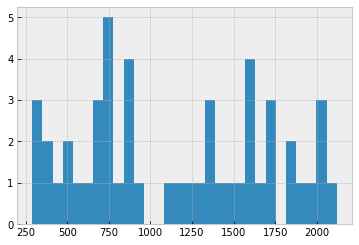

In [124]:
_ = hist(me['returns'], bins=30)

In [125]:
me2 = load_dataset(dataset_name='RoboschoolAnt-v1', dataset_dir=EXPERT_DATA_DIR)

loading dataset RoboschoolAnt-v1


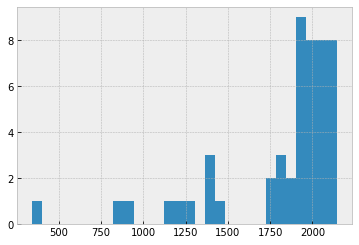

In [126]:
_ = hist(me2['returns'], bins=30)

In [3]:
import keras

In [7]:
import tensorflow as tf
from sklearn.metrics import mean_squared_error
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Embedding
from tensorflow.keras.callbacks import Callback, LambdaCallback, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import pickle

# Bayesian Methods for Hackers style sheet
plt.style.use('bmh')

def create_model(input_dim, output_dim, num_hidden=3, units=100, l2_reg=0.0001, 
                 dropout=None, use_batchnorm=True, **kwargs):
    """
    This method wraps the creation of a Keras fully connected model
    """
    input_layer = Input(shape=(input_dim, ), name="input")

    # Define model architecture 
    if use_batchnorm:
        layer = BatchNormalization()(input_layer)
    else:
        layer = input_layer

    if dropout is not None:
        # Add dropout layer
        layer = Dropout(dropout)(layer)

    for i in range(1, num_hidden+1):
        layer = Dense(units=units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(layer)
        if use_batchnorm:
            layer = BatchNormalization()(layer)

        # Add dropout layer
        if dropout is not None:
            layer = Dropout(dropout)(layer)

    # Add a prediction layer
    predictions = Dense(output_dim, activation=None)(layer)

    # Note using the input object 'page_id_mapping_input' not 'page_id_embedings'
    model = tf.keras.Model(inputs=[input_layer], outputs=predictions)
    return model


def get_model_name(dataset_name, input_dim, output_dim, units=100, layers=3, l2_reg=1e-04, 
                   lr=1e-03, dropout=None, use_batchnorm=False):
    """
    Defines a model name and creates relevant directories
    """
    model_name = "model_{dataset_name}__{lr}_lr_{dropout}_dropout_{layers}_layers_{units}_neurons_batch_norm_l2_{l2_reg}".format(**config_dict)
    model_path = "%s/%s" % (SAVED_MODELS_DIR, model_name)

    ! mkdir -p {model_path}

    filepath="%s/weights-improvement-dummy-{epoch:02d}-{val_loss:.2f}.hdf5" % model_path


    print("model_name='%s'" % model_name)
    print("model_path='%s'" % model_path)
    print("KerasTrainScope(model_name=model_name, history_dir=model_path).plt_history(start_epoch=5, metric_str='mean_squared_error', title='%s MSE')" % dataset_name)

    return model_name, model_path


def get_compiled_model(dataset_name, input_dim, output_dim, units=100, layers=3, l2_reg=1e-04, 
                   lr=1e-03, dropout=None, use_batchnorm=False):
    
    # Get model names
    model_name, model_path = get_model_name(dataset_name=dataset_name, input_dim=input_dim, 
                                            output_dim=output_dim, units=units, layers=layers, 
                                            l2_reg=l2_reg, lr=lr, dropout=dropout, use_batchnorm=use_batchnorm)
    
    # Create a model
    model = create_model(input_dim=input_dim, output_dim=output_dim, num_hidden=layers, units=units, 
                         l2_reg=l2_reg, dropout=dropout, use_batchnorm=use_batchnorm)
    
    
    # Compile the model
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])
    
    return model, model_name, model_path
    

def calc_mse(model, dataset_name, X_train, X_val, X_test, y_train, y_val, y_test):
    """Helper function that calculates the MSE for each of the train/validation/test sets"""
    y_pred_train = model.predict([X_train])
    train_mse = mean_squared_error(y_pred_train, y_train)

    y_pred_val = model.predict([X_val])
    val_mse = mean_squared_error(y_pred_val, y_val)

    y_pred_test = model.predict([X_test])
    test_mse = mean_squared_error(y_pred_test, y_test)

    return dict(dataset_name=dataset_name, train_mse=train_mse, val_mse=val_mse, test_mse=test_mse)


In [8]:
import pydot

In [9]:
# Define model
config_dict = dict(
    input_dim=20,
    output_dim=3,
    units=100,
    layers = 3,
    l2_reg = 1e-04,
    lr = 1e-03,
    dropout=None,
    use_batchnorm=False)

model = create_model(**config_dict)

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

NameError: name 'SVG' is not defined

### Datasets load methods

In [106]:
EXPERT_DATA_DIR = os.path.join(os.getcwd().replace('/notebooks', ''), 'expert_data')
datasets = ['RoboschoolAnt-v1', 'RoboschoolHumanoid-v1', 'RoboschoolHalfCheetah-v1', 'RoboschoolReacher-v1', 'RoboschoolHopper-v1', 'RoboschoolWalker2d-v1']
print(datasets)

['RoboschoolAnt-v1', 'RoboschoolHumanoid-v1', 'RoboschoolHalfCheetah-v1', 'RoboschoolReacher-v1', 'RoboschoolHopper-v1', 'RoboschoolWalker2d-v1']


In [102]:
from sklearn.model_selection import train_test_split


def load_dataset(dataset_name, dataset_dir):
    print("loading dataset %s" % dataset_name)
    pickle_filename = '%s.pkl' % dataset_name
    with open(os.path.join(dataset_dir, pickle_filename), 'rb') as f:
        expert_data = pickle.load(f)
    return expert_data


def get_datasets(dataset_name, dataset_dir):
    expert_data = load_dataset(dataset_name=dataset_name, dataset_dir=dataset_dir)
    X = expert_data['observations']
    y = expert_data['actions']
    
    # Use 80% of the samples as the train set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    # Leave 10% for each validation/test set
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)
    print("Domain name: %s" % dataset_name)
    print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)
    return X_train, X_val, X_test, y_train, y_val, y_test


# Train a model

In [ ]:
TENSORBOARD_COMMAND = "tensorboard --logdir=notebooks/logs"
TENSORBOARD_COMMAND

In [6]:
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Embedding
from tensorflow.keras.callbacks import Callback, LambdaCallback, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import pickle

# Bayesian Methods for Hackers style sheet
plt.style.use('bmh')

In [7]:
import os
import pickle
import matplotlib.pyplot as plt


class KerasTrainStats():
    """
    Helper class that defines the training history object for each model

    The class pickles and saves the history object to disk
    """
    def __init__(self, model_name, history_dir):
        # Local import of a Keras package
        from keras.callbacks import LambdaCallback

        # Try loading history if the file exists
        history = self.load_model_history(model_name, history_dir)

        # Else, create an empty history dict
        if not history:
            history = {'loss': [],  # training loss at the end of each epoch of training
                       'val_loss': []  # validation (eval) loss at the end of each epoch of training
                       }

        self.history = history
        self.history_dir = history_dir
        self.model_name = model_name

        # Define the LambdaCallback
        self.print_callback = LambdaCallback(on_epoch_end=self.on_epoch_end)

    def on_epoch_end(self, epoch, logs):
        # Function invoked at end of each epoch.
        # It appends the 'loss', 'val_loss' and any other key found in logs to the history and save to a file
        # TODO while training in a different window a notebook to see a plot 'loss' and 'val_loss' vs. number of epochs. look at 171219-plot for an example

        for k, v in logs.items():
            self.history[k] = self.history.get(k, []) + [v]

        history_filename = '%s/history.%s.pkl' % (self.history_dir, self.model_name)
        with open(history_filename, 'wb') as fp:
            pickle.dump(self.history, fp, -1)

    @staticmethod
    def load_model_history(model_name, history_dir):
        history_filename = '%s/history.%s.pkl' % (history_dir, model_name)

        if not os.path.isfile(history_filename):
            return False

        with open(history_filename, 'rb') as f:
            return pickle.load(f)

    def plt_history(self, start_epoch=0, figsize=(20, 10), model_name=None, history_dir=None, title=None, metric_str='loss'):
        """Plot the train/validation loss values"""
        if history_dir is None:
            history_dir = self.history_dir


        if model_name is None:
            # Try to load the history from a file before using self.history. This is ment for the usecase that a model
            # is trained in a different process/notebook and we want to present the latest history.
            history = self.load_model_history(self.model_name, history_dir=history_dir) or self.history
        else:
            # If model_name is given, load the history from a file
            history = self.load_model_history(model_name, history_dir=history_dir)
            if not history:
                raise Exception("Cannot find history object for model_name={model_name}".format(model_name))

        plt.figure(figsize=figsize)
        _loss = history[metric_str][start_epoch:]
        _val_loss = history['val_%s' % metric_str][start_epoch:]

        train_loss_plot, = plt.plot(range(start_epoch + 1, start_epoch + len(_loss) + 1), _loss, label='Train %s' % metric_str)
        val_loss_plot, = plt.plot(range(start_epoch + 1, start_epoch + len(_val_loss) + 1), _val_loss,
                                  label='Validation %s' % metric_str)

        plt.legend(handles=[train_loss_plot, val_loss_plot])
        plt.xlabel("epoch")
        plt.ylabel(metric_str)

        if title is not None:
            _ = plt.title(title)
            

In [11]:
import tensorflow as tf
from sklearn.metrics import mean_squared_error


def create_model(input_dim, output_dim, num_hidden=3, units=100, l2_reg=0.0001, 
                 dropout=None, use_batchnorm=True, **kwargs):
    """
    This method wraps the creation of a Keras fully connected model
    """
    input_layer = Input(shape=(input_dim, ), name="input")

    # Define model architecture 
    if use_batchnorm:
        layer = BatchNormalization()(input_layer)
    else:
        layer = input_layer

    if dropout is not None:
        # Add dropout layer
        layer = Dropout(dropout)(layer)

    for i in range(1, num_hidden+1):
        layer = Dense(units=units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(layer)
        if use_batchnorm:
            layer = BatchNormalization()(layer)

        # Add dropout layer
        if dropout is not None:
            layer = Dropout(dropout)(layer)

    # Add a prediction layer
    predictions = Dense(output_dim, activation=None)(layer)

    # Note using the input object 'page_id_mapping_input' not 'page_id_embedings'
    model = tf.keras.Model(inputs=[input_layer], outputs=predictions)
    return model


def get_model_name(dataset_name, input_dim, output_dim, units=100, layers=3, l2_reg=1e-04, 
                   lr=1e-03, dropout=None, use_batchnorm=False):
    """
    Defines a model name and creates relevant directories
    """
    model_name = "model_{dataset_name}__{lr}_lr_{dropout}_dropout_{layers}_layers_{units}_neurons_batch_norm_l2_{l2_reg}".format(**config_dict)
    model_path = "%s/%s" % (SAVED_MODELS_DIR, model_name)

    ! mkdir -p {model_path}

    filepath="%s/weights-improvement-dummy-{epoch:02d}-{val_loss:.2f}.hdf5" % model_path


    print("model_name='%s'" % model_name)
    print("model_path='%s'" % model_path)
    print("KerasTrainScope(model_name=model_name, history_dir=model_path).plt_history(start_epoch=5, metric_str='mean_squared_error', title='%s MSE')" % dataset_name)

    return model_name, model_path


def get_compiled_model(dataset_name, input_dim, output_dim, units=100, layers=3, l2_reg=1e-04, 
                   lr=1e-03, dropout=None, use_batchnorm=False):
    
    # Get model names
    model_name, model_path = get_model_name(dataset_name=dataset_name, input_dim=input_dim, 
                                            output_dim=output_dim, units=units, layers=layers, 
                                            l2_reg=l2_reg, lr=lr, dropout=dropout, use_batchnorm=use_batchnorm)
    
    # Create a model
    model = create_model(input_dim=input_dim, output_dim=output_dim, num_hidden=layers, units=units, 
                         l2_reg=l2_reg, dropout=dropout, use_batchnorm=use_batchnorm)
    
    
    # Compile the model
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])
    
    return model, model_name, model_path
    

def calc_mse(model, dataset_name, X_train, X_val, X_test, y_train, y_val, y_test):
    """Helper function that calculates the MSE for each of the train/validation/test sets"""
    y_pred_train = model.predict([X_train])
    train_mse = mean_squared_error(y_pred_train, y_train)

    y_pred_val = model.predict([X_val])
    val_mse = mean_squared_error(y_pred_val, y_val)

    y_pred_test = model.predict([X_test])
    test_mse = mean_squared_error(y_pred_test, y_test)

    return dict(dataset_name=dataset_name, train_mse=train_mse, val_mse=val_mse, test_mse=test_mse)


In [46]:
# pip install --user pydot

In [47]:
# tf.keras.utils.plot_model(model, 'my_first_model.png')

In [48]:
# from IPython.display import SVG
# from tensorflow.keras.utils import model_to_dot

# SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [49]:
SAVED_MODELS_DIR = '/tf/srv/hw1/notebooks'

In [50]:
dataset_name = 'RoboschoolAnt-v1'
X_train, X_val, X_test, y_train, y_val, y_test = get_datasets(dataset_name=dataset_name)
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

loading dataset RoboschoolAnt-v1
(40000, 28) (5000, 28) (5000, 28) (40000, 8) (5000, 8) (5000, 8)


In [81]:
# Define model
config_dict = dict(
    input_dim=X_train.shape[1],
    output_dim=y_train.shape[1],
    units=100,
    layers = 3,
    l2_reg = 1e-04,
    lr = 1e-03,
    dropout=None,
    use_batchnorm=False)


model_name = "model_task_1__{lr}_lr_{dropout}_dropout_{layers}_layers_{units}_neurons_batch_norm_l2_{l2_reg}".format(**config_dict)
model_path = "%s/%s" % (SAVED_MODELS_DIR, model_name)

! mkdir -p {model_path}

filepath="%s/weights-improvement-dummy-{epoch:02d}-{val_loss:.2f}.hdf5" % model_path


print("model_name='%s'" % model_name)
print("model_path='%s'" % model_path)
print("KerasTrainScope(model_name=model_name, history_dir=model_path).plt_history(start_epoch=5, metric_str='mean_squared_error')")

model_name='model_task_1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001'
model_path='/tf/srv/hw1/notebooks/model_task_1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001'
KerasTrainScope(model_name=model_name, history_dir=model_path).plt_history(start_epoch=5)


In [83]:
model = create_model(**config_dict)

# Callbacks
#checkpoint = ModelCheckpoint(filepath, monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_mean_squared_error', factor=0.5, patience=5, verbose=1)
tf_board = TensorBoard()


# Compile the model
optimizer = tf.keras.optimizers.Adam()
model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])

# Define a scope object
scope = KerasTrainScope(model_name=model_name, history_dir=model_path)


# Train the model
batch_size = 64
epochs = 200

In [84]:
_ = model.fit([X_train], y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=[scope.print_callback, reduce_lr, tf_board],
          validation_data=([X_val], y_val)
          )

Train on 40000 samples, validate on 5000 samples
Epoch 1/200
40000/40000 [==============================] - 2s 42us/sample - loss: 0.3940 - mean_squared_error: 0.3671 - val_loss: 0.2368 - val_mean_squared_error: 0.2075
Epoch 2/200
40000/40000 [==============================] - 1s 34us/sample - loss: 0.2028 - mean_squared_error: 0.1725 - val_loss: 0.1945 - val_mean_squared_error: 0.1637
Epoch 3/200
40000/40000 [==============================] - 1s 35us/sample - loss: 0.1712 - mean_squared_error: 0.1399 - val_loss: 0.1695 - val_mean_squared_error: 0.1379
Epoch 4/200
40000/40000 [==============================] - 1s 34us/sample - loss: 0.1546 - mean_squared_error: 0.1229 - val_loss: 0.1550 - val_mean_squared_error: 0.1232
Epoch 5/200
40000/40000 [==============================] - 1s 33us/sample - loss: 0.1421 - mean_squared_error: 0.1103 - val_loss: 0.1471 - val_mean_squared_error: 0.1153
Epoch 6/200
40000/40000 [==============================] - 1s 35us/sample - loss: 0.1347 - mean_squar

Epoch 91/200
40000/40000 [==============================] - 1s 33us/sample - loss: 0.0607 - mean_squared_error: 0.0393 - val_loss: 0.0706 - val_mean_squared_error: 0.0492
Epoch 92/200
40000/40000 [==============================] - 1s 33us/sample - loss: 0.0607 - mean_squared_error: 0.0393 - val_loss: 0.0707 - val_mean_squared_error: 0.0493
Epoch 93/200
40000/40000 [==============================] - 1s 34us/sample - loss: 0.0607 - mean_squared_error: 0.0393 - val_loss: 0.0706 - val_mean_squared_error: 0.0492
Epoch 94/200
40000/40000 [==============================] - 1s 34us/sample - loss: 0.0607 - mean_squared_error: 0.0393 - val_loss: 0.0707 - val_mean_squared_error: 0.0493
Epoch 95/200
40000/40000 [==============================] - 1s 33us/sample - loss: 0.0606 - mean_squared_error: 0.0392 - val_loss: 0.0708 - val_mean_squared_error: 0.0495
Epoch 96/200
38848/40000 [============================>.] - ETA: 0s - loss: 0.0606 - mean_squared_error: 0.0392
Epoch 00096: ReduceLROnPlateau re

40000/40000 [==============================] - 2s 42us/sample - loss: 0.0599 - mean_squared_error: 0.0386 - val_loss: 0.0702 - val_mean_squared_error: 0.0489
Epoch 171/200
40000/40000 [==============================] - 2s 55us/sample - loss: 0.0599 - mean_squared_error: 0.0386 - val_loss: 0.0702 - val_mean_squared_error: 0.0489
Epoch 172/200
40000/40000 [==============================] - 2s 43us/sample - loss: 0.0599 - mean_squared_error: 0.0386 - val_loss: 0.0702 - val_mean_squared_error: 0.0489
Epoch 173/200
40000/40000 [==============================] - 2s 52us/sample - loss: 0.0599 - mean_squared_error: 0.0386 - val_loss: 0.0702 - val_mean_squared_error: 0.0489
Epoch 174/200
39936/40000 [============================>.] - ETA: 0s - loss: 0.0599 - mean_squared_error: 0.0386
Epoch 00174: ReduceLROnPlateau reducing learning rate to 4.768371808516747e-10.
40000/40000 [==============================] - 2s 38us/sample - loss: 0.0599 - mean_squared_error: 0.0386 - val_loss: 0.0702 - val_me

In [ ]:
scope.plt_history()

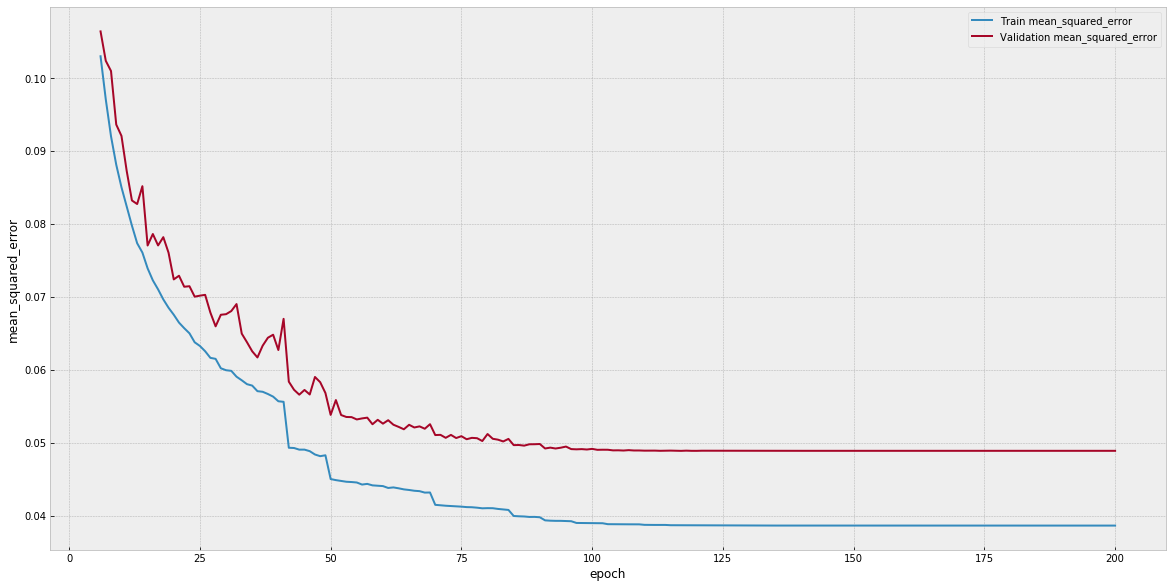

In [132]:
model_name='model_task_1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001'
model_path='/tf/srv/hw1/notebooks/model_task_1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001'
KerasTrainScope(model_name=model_name, history_dir=model_path).plt_history(start_epoch=5, metric_str='mean_squared_error')

In [91]:
model_filename = os.path.join(model_path, model_name)
model.save(model_filename)
print(model_filename)

/tf/srv/hw1/notebooks/model_task_1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001/model_task_1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001


In [98]:
#!pip install sklearn --user

In [104]:
%time res = calc_results(model, X_train, X_val, X_test, y_train, y_val, y_test)

CPU times: user 970 ms, sys: 220 ms, total: 1.19 s
Wall time: 933 ms


In [105]:
res

{'test_mse': 0.0462646886159824,
 'train_mse': 0.03862083526901778,
 'val_mse': 0.04887514734632932}

# Train a model for each domain

In [118]:
print(datasets)

['RoboschoolAnt-v1', 'RoboschoolHumanoid-v1', 'RoboschoolHalfCheetah-v1', 'RoboschoolReacher-v1', 'RoboschoolHopper-v1', 'RoboschoolWalker2d-v1']


In [103]:
expert_data = load_dataset(dataset_name='RoboschoolHumanoid-v1', dataset_dir=EXPERT_DATA_DIR)

loading dataset RoboschoolHumanoid-v1


In [104]:
expert_data['observations'].shape

(44444, 44)

In [107]:
for name in datasets:
    print(name)
    expert_data = load_dataset(dataset_name=name, dataset_dir=EXPERT_DATA_DIR)
    print(expert_data['observations'].shape, expert_data['actions'].shape)

RoboschoolAnt-v1
loading dataset RoboschoolAnt-v1


FileNotFoundError: [Errno 2] No such file or directory: '/tf/srv/expert_data/RoboschoolAnt-v1.pkl'

## RoboschoolHumanoid-v1

In [126]:
dataset_name = 'RoboschoolHumanoid-v1'
X_train, X_val, X_test, y_train, y_val, y_test = get_datasets(dataset_name)

loading dataset RoboschoolHumanoid-v1
DOmain name: RoboschoolHumanoid-v1
(35581, 44) (4448, 44) (4448, 44) (35581, 17) (4448, 17) (4448, 17)


In [127]:
# Define model
config_dict = dict(
    dataset_name=dataset_name,
    input_dim=X_train.shape[1],
    output_dim=y_train.shape[1],
    units=100,
    layers = 3,
    l2_reg = 1e-04,
    lr = 1e-03,
    dropout=None,
    use_batchnorm=False)


model_name = "model_{dataset_name}__{lr}_lr_{dropout}_dropout_{layers}_layers_{units}_neurons_batch_norm_l2_{l2_reg}".format(**config_dict)
model_path = "%s/%s" % (SAVED_MODELS_DIR, model_name)

! mkdir -p {model_path}

filepath="%s/weights-improvement-dummy-{epoch:02d}-{val_loss:.2f}.hdf5" % model_path


print("model_name='%s'" % model_name)
print("model_path='%s'" % model_path)
print("KerasTrainScope(model_name=model_name, history_dir=model_path).plt_history(start_epoch=5)")

model_name='model_RoboschoolHumanoid-v1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001'
model_path='/tf/srv/hw1/notebooks/model_RoboschoolHumanoid-v1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001'
KerasTrainScope(model_name=model_name, history_dir=model_path).plt_history(start_epoch=5)


In [128]:
model = create_model(**config_dict)

# Callbacks
#checkpoint = ModelCheckpoint(filepath, monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_mean_squared_error', factor=0.5, patience=5, verbose=1)
tf_board = TensorBoard()


# Compile the model
optimizer = tf.keras.optimizers.Adam()
model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])

# Define a scope object
scope = KerasTrainScope(model_name=model_name, history_dir=model_path)


# Train the model
batch_size = 64
epochs = 200

In [129]:
_ = model.fit([X_train], y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=[scope.print_callback, reduce_lr, tf_board],
          validation_data=([X_val], y_val)
          )

Train on 35581 samples, validate on 4448 samples
Epoch 1/200
35581/35581 [==============================] - 2s 50us/sample - loss: 0.0836 - mean_squared_error: 0.0646 - val_loss: 0.0571 - val_mean_squared_error: 0.0397
Epoch 2/200
35581/35581 [==============================] - 1s 36us/sample - loss: 0.0533 - mean_squared_error: 0.0365 - val_loss: 0.0495 - val_mean_squared_error: 0.0333
Epoch 3/200
35581/35581 [==============================] - 1s 36us/sample - loss: 0.0471 - mean_squared_error: 0.0314 - val_loss: 0.0445 - val_mean_squared_error: 0.0293
Epoch 4/200
35581/35581 [==============================] - 1s 35us/sample - loss: 0.0437 - mean_squared_error: 0.0289 - val_loss: 0.0428 - val_mean_squared_error: 0.0283
Epoch 5/200
35581/35581 [==============================] - 1s 36us/sample - loss: 0.0415 - mean_squared_error: 0.0273 - val_loss: 0.0402 - val_mean_squared_error: 0.0264
Epoch 6/200
35581/35581 [==============================] - 1s 35us/sample - loss: 0.0395 - mean_squar

Epoch 47/200
35581/35581 [==============================] - 1s 36us/sample - loss: 0.0231 - mean_squared_error: 0.0147 - val_loss: 0.0243 - val_mean_squared_error: 0.0159
Epoch 48/200
35581/35581 [==============================] - 1s 37us/sample - loss: 0.0231 - mean_squared_error: 0.0147 - val_loss: 0.0243 - val_mean_squared_error: 0.0159
Epoch 49/200
35581/35581 [==============================] - 1s 34us/sample - loss: 0.0230 - mean_squared_error: 0.0147 - val_loss: 0.0246 - val_mean_squared_error: 0.0162
Epoch 50/200
35581/35581 [==============================] - 1s 36us/sample - loss: 0.0230 - mean_squared_error: 0.0146 - val_loss: 0.0241 - val_mean_squared_error: 0.0158
Epoch 51/200
35581/35581 [==============================] - 1s 36us/sample - loss: 0.0229 - mean_squared_error: 0.0146 - val_loss: 0.0243 - val_mean_squared_error: 0.0160
Epoch 52/200
35581/35581 [==============================] - 1s 36us/sample - loss: 0.0229 - mean_squared_error: 0.0145 - val_loss: 0.0245 - val_m

35581/35581 [==============================] - 1s 34us/sample - loss: 0.0213 - mean_squared_error: 0.0132 - val_loss: 0.0229 - val_mean_squared_error: 0.0149
Epoch 130/200
35581/35581 [==============================] - 1s 34us/sample - loss: 0.0213 - mean_squared_error: 0.0132 - val_loss: 0.0229 - val_mean_squared_error: 0.0149
Epoch 131/200
34304/35581 [===========================>..] - ETA: 0s - loss: 0.0213 - mean_squared_error: 0.0132
Epoch 00131: ReduceLROnPlateau reducing learning rate to 3.051757957450718e-08.
35581/35581 [==============================] - 1s 35us/sample - loss: 0.0213 - mean_squared_error: 0.0132 - val_loss: 0.0229 - val_mean_squared_error: 0.0149
Epoch 132/200
35581/35581 [==============================] - 1s 35us/sample - loss: 0.0213 - mean_squared_error: 0.0132 - val_loss: 0.0229 - val_mean_squared_error: 0.0149
Epoch 133/200
35581/35581 [==============================] - 1s 35us/sample - loss: 0.0213 - mean_squared_error: 0.0132 - val_loss: 0.0229 - val_me

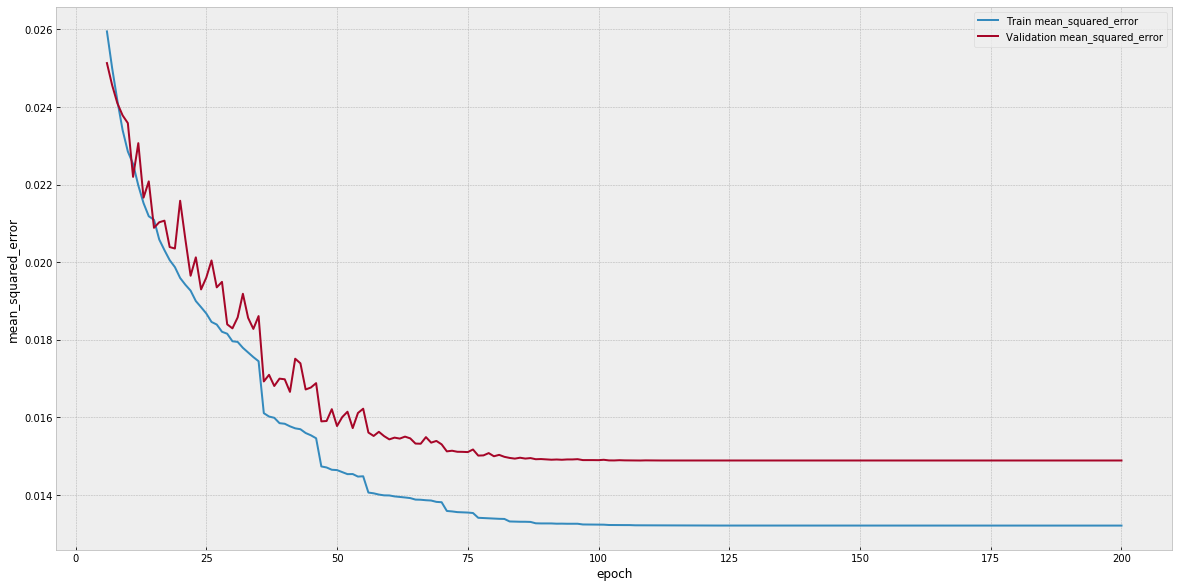

In [133]:
model_name='model_RoboschoolHumanoid-v1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001'
model_path='/tf/srv/hw1/notebooks/model_RoboschoolHumanoid-v1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001'
KerasTrainScope(model_name=model_name, history_dir=model_path).plt_history(start_epoch=5, metric_str='mean_squared_error')

In [130]:
model_filename = os.path.join(model_path, model_name)
model.save(model_filename)
print(model_filename)

/tf/srv/hw1/notebooks/model_RoboschoolHumanoid-v1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001/model_RoboschoolHumanoid-v1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001


In [131]:
calc_results(model, X_train, X_val, X_test, y_train, y_val, y_test)

{'test_mse': 0.01429732729699864,
 'train_mse': 0.013212775651986579,
 'val_mse': 0.014890401553409038}

## RoboschoolHalfCheetah-v1

In [154]:
#! mkdir -p {model_path}

In [159]:
# Get the datasets
dataset_name = 'RoboschoolHalfCheetah-v1'
X_train, X_val, X_test, y_train, y_val, y_test = get_datasets(dataset_name)


# Define model
config_dict = dict(
    dataset_name=dataset_name,
    input_dim=X_train.shape[1],
    output_dim=y_train.shape[1],
    units=100,
    layers = 3,
    l2_reg = 1e-04,
    lr = 1e-03,
    dropout=None,
    use_batchnorm=False)

model, model_name, model_path = get_compiled_model(**config_dict)


### Callbacks
# Reduce learning rate dynamically
reduce_lr = ReduceLROnPlateau(monitor='val_mean_squared_error', factor=0.5, patience=5, verbose=1)
tf_board = TensorBoard()

# Define a scope object
scope = KerasTrainScope(model_name=model_name, history_dir=model_path)

# Train the model
batch_size = 64
epochs = 100

loading dataset RoboschoolHalfCheetah-v1
DOmain name: RoboschoolHalfCheetah-v1
(35689, 26) (4462, 26) (4461, 26) (35689, 6) (4462, 6) (4461, 6)
model_name='model_RoboschoolHalfCheetah-v1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001'
model_path='/tf/srv/hw1/notebooks/model_RoboschoolHalfCheetah-v1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001'
KerasTrainScope(model_name=model_name, history_dir=model_path).plt_history(start_epoch=5, metric_str='mean_squared_error', title='RoboschoolHalfCheetah-v1 MSE')


In [160]:
_ = model.fit([X_train], y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=[scope.print_callback, reduce_lr, tf_board],
          validation_data=([X_val], y_val)
          )

Train on 35689 samples, validate on 4462 samples
Epoch 1/100
35689/35689 [==============================] - 3s 73us/sample - loss: 0.2269 - mean_squared_error: 0.2040 - val_loss: 0.1073 - val_mean_squared_error: 0.0835
Epoch 2/100
35689/35689 [==============================] - 1s 40us/sample - loss: 0.0940 - mean_squared_error: 0.0698 - val_loss: 0.0821 - val_mean_squared_error: 0.0576
Epoch 3/100
35689/35689 [==============================] - 2s 51us/sample - loss: 0.0758 - mean_squared_error: 0.0513 - val_loss: 0.0696 - val_mean_squared_error: 0.0452
Epoch 4/100
35689/35689 [==============================] - 1s 40us/sample - loss: 0.0670 - mean_squared_error: 0.0428 - val_loss: 0.0658 - val_mean_squared_error: 0.0418
Epoch 5/100
35689/35689 [==============================] - 2s 49us/sample - loss: 0.0616 - mean_squared_error: 0.0380 - val_loss: 0.0645 - val_mean_squared_error: 0.0411
Epoch 6/100
35689/35689 [==============================] - 2s 45us/sample - loss: 0.0574 - mean_squar

Epoch 49/100
35689/35689 [==============================] - 1s 39us/sample - loss: 0.0271 - mean_squared_error: 0.0153 - val_loss: 0.0283 - val_mean_squared_error: 0.0165
Epoch 50/100
35689/35689 [==============================] - 1s 40us/sample - loss: 0.0267 - mean_squared_error: 0.0150 - val_loss: 0.0301 - val_mean_squared_error: 0.0184
Epoch 51/100
35264/35689 [============================>.] - ETA: 0s - loss: 0.0269 - mean_squared_error: 0.0153
Epoch 00051: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
35689/35689 [==============================] - 2s 53us/sample - loss: 0.0270 - mean_squared_error: 0.0153 - val_loss: 0.0281 - val_mean_squared_error: 0.0165
Epoch 52/100
35689/35689 [==============================] - 1s 38us/sample - loss: 0.0240 - mean_squared_error: 0.0125 - val_loss: 0.0257 - val_mean_squared_error: 0.0142
Epoch 53/100
35689/35689 [==============================] - 1s 40us/sample - loss: 0.0240 - mean_squared_error: 0.0125 - val_loss: 0.0251

Epoch 92/100
35689/35689 [==============================] - 1s 36us/sample - loss: 0.0195 - mean_squared_error: 0.0091 - val_loss: 0.0216 - val_mean_squared_error: 0.0112
Epoch 93/100
35689/35689 [==============================] - 1s 39us/sample - loss: 0.0195 - mean_squared_error: 0.0091 - val_loss: 0.0216 - val_mean_squared_error: 0.0112
Epoch 94/100
35689/35689 [==============================] - 2s 42us/sample - loss: 0.0195 - mean_squared_error: 0.0091 - val_loss: 0.0216 - val_mean_squared_error: 0.0112
Epoch 95/100
35689/35689 [==============================] - 1s 39us/sample - loss: 0.0195 - mean_squared_error: 0.0091 - val_loss: 0.0216 - val_mean_squared_error: 0.0112
Epoch 96/100
34112/35689 [===========================>..] - ETA: 0s - loss: 0.0195 - mean_squared_error: 0.0091
Epoch 00096: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
35689/35689 [==============================] - 1s 37us/sample - loss: 0.0195 - mean_squared_error: 0.0091 - val_loss: 0.021

In [162]:
model_filename = os.path.join(model_path, model_name)
model.save(model_filename)
print("Saved model for %s: %s" % (dataset_name, model_filename))

Saved model for RoboschoolHalfCheetah-v1: /tf/srv/hw1/notebooks/model_RoboschoolHalfCheetah-v1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001/model_RoboschoolHalfCheetah-v1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001


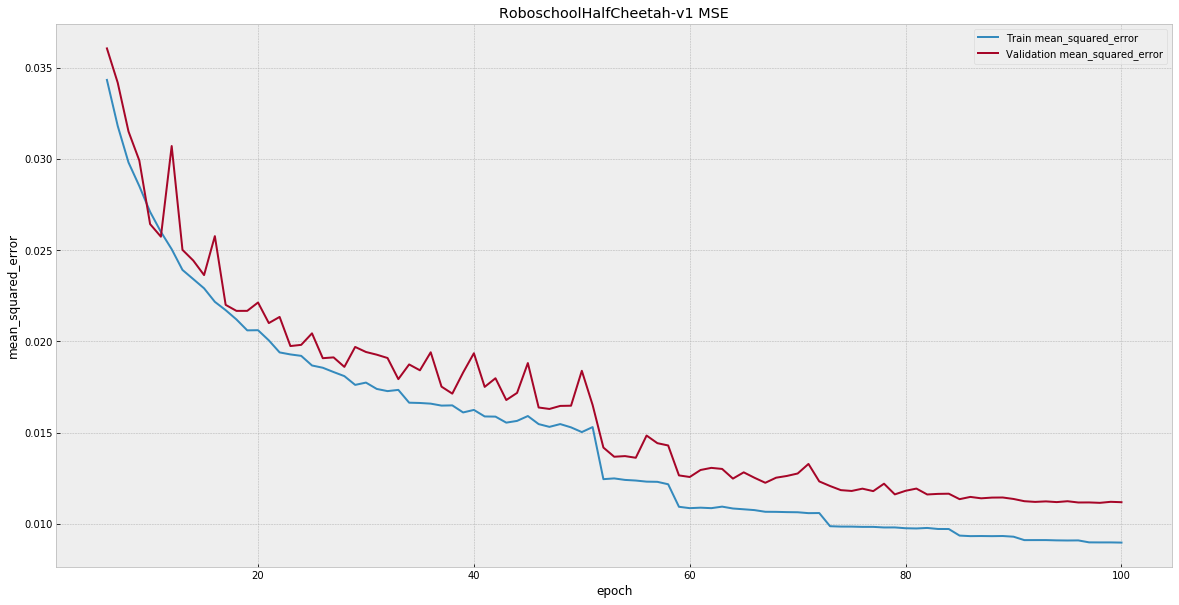

In [161]:
KerasTrainScope(model_name=model_name, history_dir=model_path).plt_history(start_epoch=5, metric_str='mean_squared_error', title='RoboschoolHalfCheetah-v1 MSE')


In [164]:
res = calc_mse(model, dataset_name, X_train, X_val, X_test, y_train, y_val, y_test)

In [165]:
res

{'dataset_name': 'RoboschoolHalfCheetah-v1',
 'test_mse': 0.011333423760387033,
 'train_mse': 0.008962756900149079,
 'val_mse': 0.011190289824628143}

## RoboschoolReacher-v1

In [167]:
# Get the datasets
dataset_name = 'RoboschoolReacher-v1'
X_train, X_val, X_test, y_train, y_val, y_test = get_datasets(dataset_name)


# Define model
config_dict = dict(
    dataset_name=dataset_name,
    input_dim=X_train.shape[1],
    output_dim=y_train.shape[1],
    units=100,
    layers = 3,
    l2_reg = 1e-04,
    lr = 1e-03,
    dropout=None,
    use_batchnorm=False)

model, model_name, model_path = get_compiled_model(**config_dict)


### Callbacks
# Reduce learning rate dynamically
reduce_lr = ReduceLROnPlateau(monitor='val_mean_squared_error', factor=0.5, patience=5, verbose=1)
tf_board = TensorBoard()

# Define a scope object
scope = KerasTrainScope(model_name=model_name, history_dir=model_path)

# Train the model
batch_size = 64
epochs = 100

loading dataset RoboschoolReacher-v1
DOmain name: RoboschoolReacher-v1
(6000, 9) (750, 9) (750, 9) (6000, 2) (750, 2) (750, 2)
model_name='model_RoboschoolReacher-v1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001'
model_path='/tf/srv/hw1/notebooks/model_RoboschoolReacher-v1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001'
KerasTrainScope(model_name=model_name, history_dir=model_path).plt_history(start_epoch=5, metric_str='mean_squared_error', title='RoboschoolReacher-v1 MSE')


In [168]:
_ = model.fit([X_train], y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=[scope.print_callback, reduce_lr, tf_board],
          validation_data=([X_val], y_val)
          )

model_filename = os.path.join(model_path, model_name)
model.save(model_filename)
print("Saved model for %s: %s" % (dataset_name, model_filename))

Train on 6000 samples, validate on 750 samples
Epoch 1/100
6000/6000 [==============================] - 1s 189us/sample - loss: 0.1177 - mean_squared_error: 0.0987 - val_loss: 0.1005 - val_mean_squared_error: 0.0830
Epoch 2/100
6000/6000 [==============================] - 0s 51us/sample - loss: 0.0964 - mean_squared_error: 0.0794 - val_loss: 0.0884 - val_mean_squared_error: 0.0717
Epoch 3/100
6000/6000 [==============================] - 0s 57us/sample - loss: 0.0827 - mean_squared_error: 0.0662 - val_loss: 0.0761 - val_mean_squared_error: 0.0595
Epoch 4/100
6000/6000 [==============================] - 0s 55us/sample - loss: 0.0692 - mean_squared_error: 0.0527 - val_loss: 0.0691 - val_mean_squared_error: 0.0526
Epoch 5/100
6000/6000 [==============================] - 0s 43us/sample - loss: 0.0625 - mean_squared_error: 0.0460 - val_loss: 0.0602 - val_mean_squared_error: 0.0438
Epoch 6/100
6000/6000 [==============================] - 0s 44us/sample - loss: 0.0569 - mean_squared_error: 0.0

Epoch 90/100
6000/6000 [==============================] - 0s 44us/sample - loss: 0.0142 - mean_squared_error: 0.0035 - val_loss: 0.0190 - val_mean_squared_error: 0.0082
Epoch 91/100
6000/6000 [==============================] - 0s 45us/sample - loss: 0.0142 - mean_squared_error: 0.0034 - val_loss: 0.0189 - val_mean_squared_error: 0.0082
Epoch 92/100
6000/6000 [==============================] - 0s 42us/sample - loss: 0.0142 - mean_squared_error: 0.0034 - val_loss: 0.0190 - val_mean_squared_error: 0.0082
Epoch 93/100
6000/6000 [==============================] - 0s 43us/sample - loss: 0.0142 - mean_squared_error: 0.0034 - val_loss: 0.0189 - val_mean_squared_error: 0.0082
Epoch 94/100
5248/6000 [=========================>....] - ETA: 0s - loss: 0.0141 - mean_squared_error: 0.0034
Epoch 00094: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
6000/6000 [==============================] - 0s 45us/sample - loss: 0.0142 - mean_squared_error: 0.0034 - val_loss: 0.0189 - val_mean

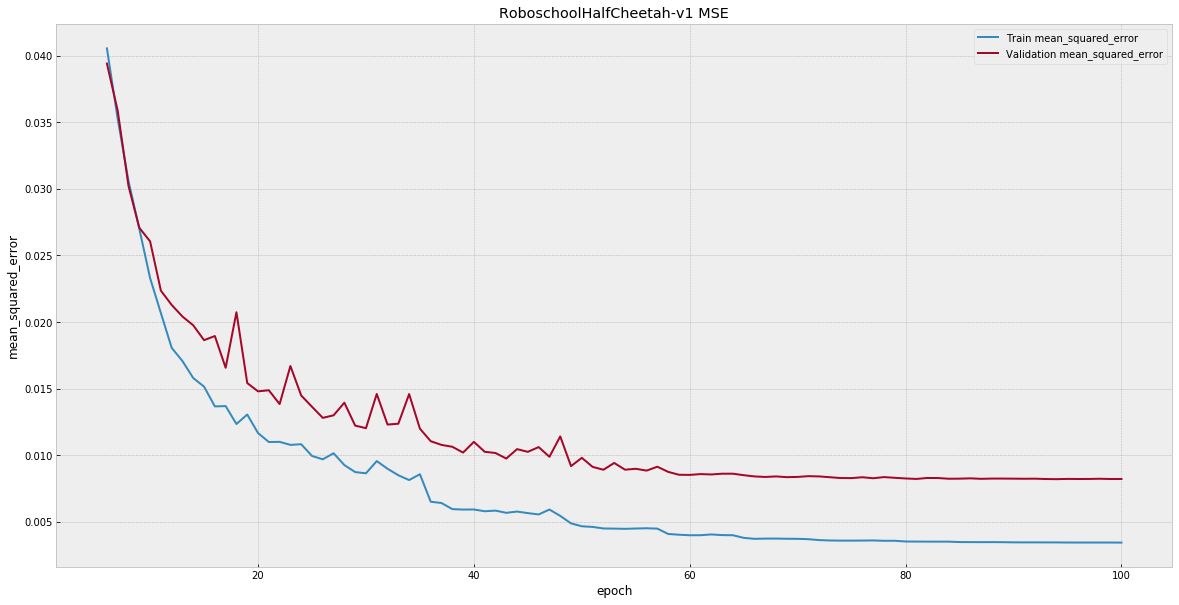

In [169]:
KerasTrainScope(model_name=model_name, history_dir=model_path).plt_history(start_epoch=5, metric_str='mean_squared_error', title='RoboschoolHalfCheetah-v1 MSE')


In [170]:
res = calc_mse(model, dataset_name, X_train, X_val, X_test, y_train, y_val, y_test)
res

{'dataset_name': 'RoboschoolReacher-v1',
 'test_mse': 0.011196816612996997,
 'train_mse': 0.003426155398305948,
 'val_mse': 0.008209465235887255}

## RoboschoolHopper-v1

In [172]:
# Get the datasets
dataset_name = 'RoboschoolHopper-v1'
X_train, X_val, X_test, y_train, y_val, y_test = get_datasets(dataset_name)


# Define model
config_dict = dict(
    dataset_name=dataset_name,
    input_dim=X_train.shape[1],
    output_dim=y_train.shape[1],
    units=100,
    layers = 3,
    l2_reg = 1e-04,
    lr = 1e-03,
    dropout=None,
    use_batchnorm=False)

model, model_name, model_path = get_compiled_model(**config_dict)


### Callbacks
# Reduce learning rate dynamically
reduce_lr = ReduceLROnPlateau(monitor='val_mean_squared_error', factor=0.5, patience=5, verbose=1)
tf_board = TensorBoard()

# Define a scope object
scope = KerasTrainScope(model_name=model_name, history_dir=model_path)

# Train the model
batch_size = 64
epochs = 100

loading dataset RoboschoolHopper-v1
DOmain name: RoboschoolHopper-v1
(29718, 15) (3715, 15) (3715, 15) (29718, 3) (3715, 3) (3715, 3)
model_name='model_RoboschoolHopper-v1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001'
model_path='/tf/srv/hw1/notebooks/model_RoboschoolHopper-v1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001'
KerasTrainScope(model_name=model_name, history_dir=model_path).plt_history(start_epoch=5, metric_str='mean_squared_error', title='RoboschoolHopper-v1 MSE')


In [173]:
_ = model.fit([X_train], y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=[scope.print_callback, reduce_lr, tf_board],
          validation_data=([X_val], y_val)
          )

model_filename = os.path.join(model_path, model_name)
model.save(model_filename)
print("Saved model for %s: %s" % (dataset_name, model_filename))

Train on 29718 samples, validate on 3715 samples
Epoch 1/100
29718/29718 [==============================] - 2s 69us/sample - loss: 0.3090 - mean_squared_error: 0.2899 - val_loss: 0.1196 - val_mean_squared_error: 0.0996
Epoch 2/100
29718/29718 [==============================] - 1s 40us/sample - loss: 0.0951 - mean_squared_error: 0.0744 - val_loss: 0.0806 - val_mean_squared_error: 0.0593
Epoch 3/100
29718/29718 [==============================] - 1s 44us/sample - loss: 0.0697 - mean_squared_error: 0.0482 - val_loss: 0.0639 - val_mean_squared_error: 0.0423
Epoch 4/100
29718/29718 [==============================] - 1s 41us/sample - loss: 0.0585 - mean_squared_error: 0.0370 - val_loss: 0.0541 - val_mean_squared_error: 0.0326
Epoch 5/100
29718/29718 [==============================] - 1s 43us/sample - loss: 0.0523 - mean_squared_error: 0.0310 - val_loss: 0.0497 - val_mean_squared_error: 0.0286
Epoch 6/100
29718/29718 [==============================] - 1s 45us/sample - loss: 0.0475 - mean_squar

29718/29718 [==============================] - 1s 43us/sample - loss: 0.0160 - mean_squared_error: 0.0057 - val_loss: 0.0182 - val_mean_squared_error: 0.0078
Epoch 90/100
29718/29718 [==============================] - 1s 41us/sample - loss: 0.0160 - mean_squared_error: 0.0057 - val_loss: 0.0182 - val_mean_squared_error: 0.0078
Epoch 91/100
29718/29718 [==============================] - 1s 43us/sample - loss: 0.0160 - mean_squared_error: 0.0057 - val_loss: 0.0182 - val_mean_squared_error: 0.0078
Epoch 92/100
29718/29718 [==============================] - 1s 44us/sample - loss: 0.0160 - mean_squared_error: 0.0057 - val_loss: 0.0182 - val_mean_squared_error: 0.0079
Epoch 93/100
28928/29718 [============================>.] - ETA: 0s - loss: 0.0160 - mean_squared_error: 0.0056
Epoch 00093: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
29718/29718 [==============================] - 1s 42us/sample - loss: 0.0160 - mean_squared_error: 0.0057 - val_loss: 0.0182 - val_mean_s

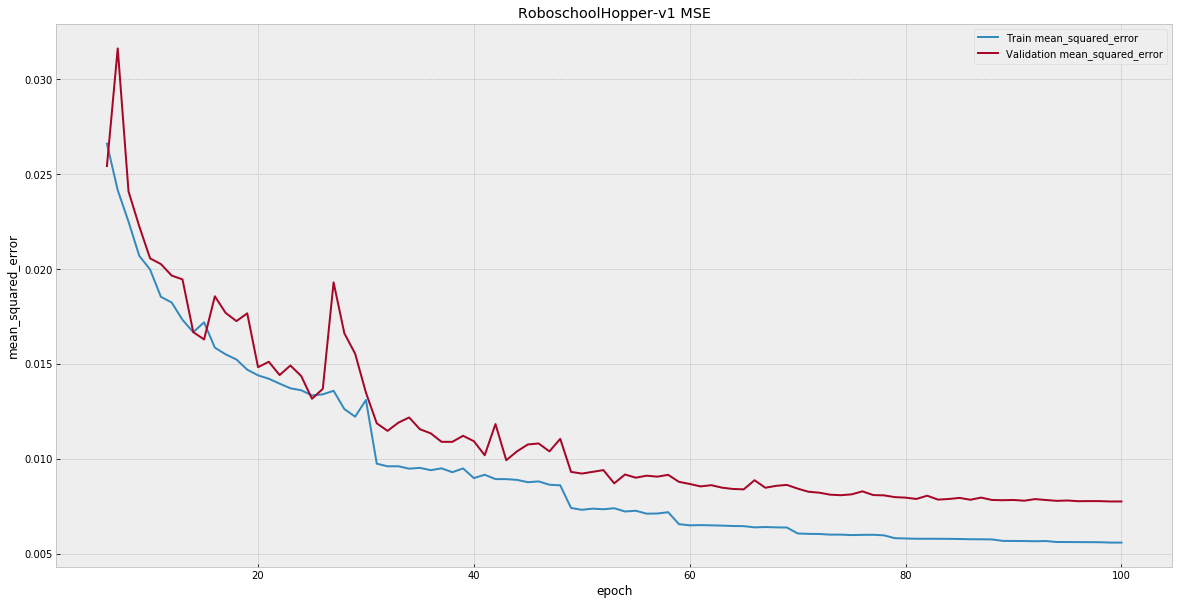

In [186]:
KerasTrainScope(model_name=model_name, history_dir=model_path).plt_history(start_epoch=5, metric_str='mean_squared_error', title='RoboschoolHopper-v1 MSE')

In [175]:
res = calc_mse(model, dataset_name, X_train, X_val, X_test, y_train, y_val, y_test)
res

{'dataset_name': 'RoboschoolHopper-v1',
 'test_mse': 0.007527259528122922,
 'train_mse': 0.0055560871057687795,
 'val_mse': 0.007748533566072244}

In [184]:
y_train.max(axis=0), y_train.min(axis=0)

(array([ 7.97332513,  9.66824644, 11.36994428]),
 array([-3.12346591, -5.6478762 , -5.78081917]))

In [195]:
history = KerasTrainScope(model_name=model_name, history_dir=model_path).history

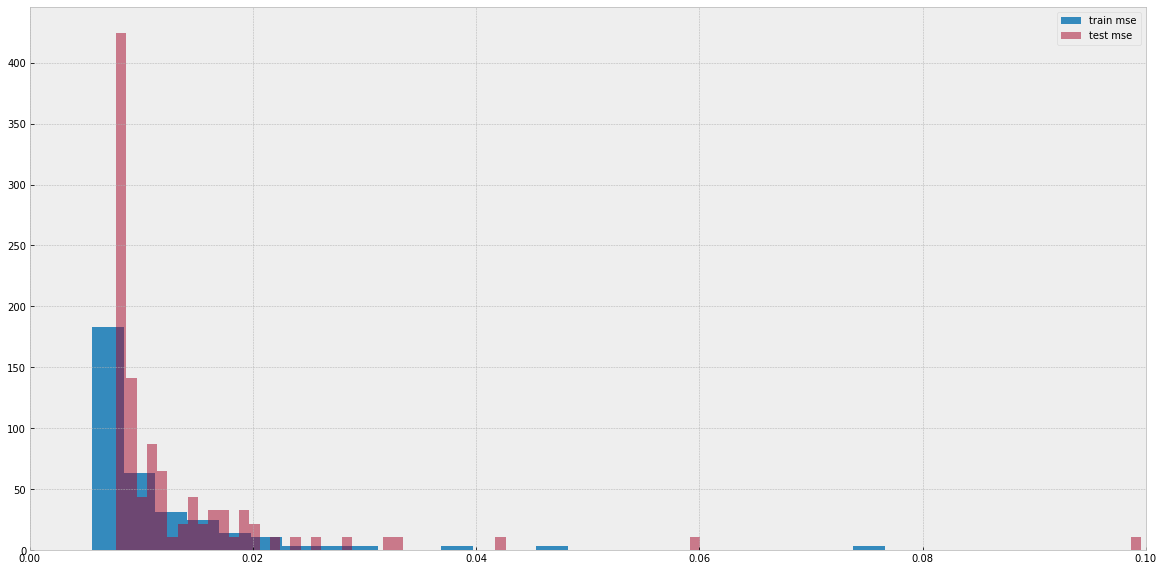

In [219]:
plt.figure(figsize=(20,10))
plt.hist(history['mean_squared_error'], bins=100, label='train mse', density=True)
plt.hist(history['val_mean_squared_error'], bins=100, label='test mse', alpha=0.5, density=True)
plt.xlim(0, 0.1)
plt.legend()
plt.show()

## RoboschoolWalker2d-v1

In [227]:
# Get the datasets
dataset_name = 'RoboschoolWalker2d-v1'
X_train, X_val, X_test, y_train, y_val, y_test = get_datasets(dataset_name)


# Define model
config_dict = dict(
    dataset_name=dataset_name,
    input_dim=X_train.shape[1],
    output_dim=y_train.shape[1],
    units=100,
    layers = 3,
    l2_reg = 1e-04,
    lr = 1e-03,
    dropout=None,
    use_batchnorm=False)

model, model_name, model_path = get_compiled_model(**config_dict)


### Callbacks
# Reduce learning rate dynamically
reduce_lr = ReduceLROnPlateau(monitor='val_mean_squared_error', factor=0.5, patience=5, verbose=1)
tf_board = TensorBoard()

# Define a scope object
scope = KerasTrainScope(model_name=model_name, history_dir=model_path)

# Train the model
batch_size = 64
epochs = 100

loading dataset RoboschoolWalker2d-v1
DOmain name: RoboschoolWalker2d-v1
(39312, 22) (4914, 22) (4914, 22) (39312, 6) (4914, 6) (4914, 6)
model_name='model_RoboschoolWalker2d-v1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001'
model_path='/tf/srv/hw1/notebooks/model_RoboschoolWalker2d-v1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001'
KerasTrainScope(model_name=model_name, history_dir=model_path).plt_history(start_epoch=5, metric_str='mean_squared_error', title='RoboschoolWalker2d-v1 MSE')


In [228]:
_ = model.fit([X_train], y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=[scope.print_callback, reduce_lr, tf_board],
          validation_data=([X_val], y_val)
          )

model_filename = os.path.join(model_path, model_name)
model.save(model_filename)
print("Saved model for %s: %s" % (dataset_name, model_filename))

Train on 39312 samples, validate on 4914 samples
Epoch 1/100
39312/39312 [==============================] - 3s 72us/sample - loss: 0.1222 - mean_squared_error: 0.1030 - val_loss: 0.0645 - val_mean_squared_error: 0.0449
Epoch 2/100
39312/39312 [==============================] - 2s 39us/sample - loss: 0.0553 - mean_squared_error: 0.0358 - val_loss: 0.0493 - val_mean_squared_error: 0.0299
Epoch 3/100
39312/39312 [==============================] - 1s 38us/sample - loss: 0.0462 - mean_squared_error: 0.0271 - val_loss: 0.0436 - val_mean_squared_error: 0.0249
Epoch 4/100
39312/39312 [==============================] - 1s 38us/sample - loss: 0.0416 - mean_squared_error: 0.0233 - val_loss: 0.0404 - val_mean_squared_error: 0.0226
Epoch 5/100
39312/39312 [==============================] - 1s 38us/sample - loss: 0.0380 - mean_squared_error: 0.0205 - val_loss: 0.0365 - val_mean_squared_error: 0.0194
Epoch 6/100
39312/39312 [==============================] - 1s 38us/sample - loss: 0.0356 - mean_squar

Epoch 88/100
39312/39312 [==============================] - 2s 41us/sample - loss: 0.0144 - mean_squared_error: 0.0062 - val_loss: 0.0149 - val_mean_squared_error: 0.0067
Epoch 89/100
39312/39312 [==============================] - 2s 41us/sample - loss: 0.0144 - mean_squared_error: 0.0062 - val_loss: 0.0149 - val_mean_squared_error: 0.0067
Epoch 90/100
39312/39312 [==============================] - 2s 42us/sample - loss: 0.0144 - mean_squared_error: 0.0062 - val_loss: 0.0149 - val_mean_squared_error: 0.0067
Epoch 91/100
39312/39312 [==============================] - 2s 41us/sample - loss: 0.0144 - mean_squared_error: 0.0062 - val_loss: 0.0149 - val_mean_squared_error: 0.0067
Epoch 92/100
39040/39312 [============================>.] - ETA: 0s - loss: 0.0144 - mean_squared_error: 0.0062
Epoch 00092: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
39312/39312 [==============================] - 2s 40us/sample - loss: 0.0144 - mean_squared_error: 0.0062 - val_loss: 0.014

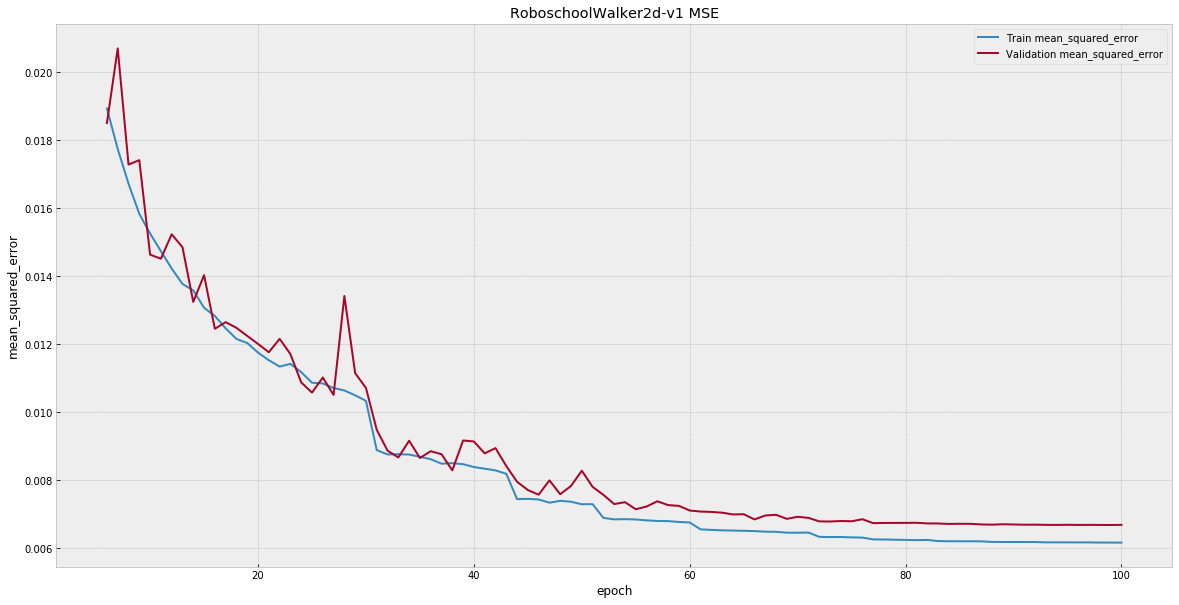

In [229]:
KerasTrainScope(model_name=model_name, history_dir=model_path).plt_history(start_epoch=5, metric_str='mean_squared_error', title='RoboschoolWalker2d-v1 MSE')


In [230]:
res = calc_mse(model, dataset_name, X_train, X_val, X_test, y_train, y_val, y_test)
res

{'dataset_name': 'RoboschoolWalker2d-v1',
 'test_mse': 0.00652572098632578,
 'train_mse': 0.006158397129541189,
 'val_mse': 0.006682982918667695}

So far we have trained a model for each task. Lets train them agains an expert

# Run trained agents

In [10]:
import tensorflow as tf

In [48]:
env_to_model = {
    'RoboschoolAnt-v1': '/tf/srv/hw1/notebooks/model_task_1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001/model_task_1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001',
    'RoboschoolHumanoid-v1': '/tf/srv/hw1/notebooks/model_RoboschoolHumanoid-v1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001/model_RoboschoolHumanoid-v1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001',
    'RoboschoolReacher-v1': '/tf/srv/hw1/notebooks/model_RoboschoolReacher-v1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001/model_RoboschoolReacher-v1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001',
    'RoboschoolHopper-v1': '/tf/srv/hw1/notebooks/model_RoboschoolHopper-v1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001/model_RoboschoolHopper-v1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001',
    'RoboschoolWalker2d-v1': '/tf/srv/hw1/notebooks/model_RoboschoolWalker2d-v1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001/model_RoboschoolWalker2d-v1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001',
}

In [14]:
module_name = 'RoboschoolWalker2d-v1'
model_filename = env_to_model[module_name]

model = tf.keras.models.load_model(model_filename)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [ ]:
import gym
import roboschool
module_name = 'RoboschoolWalker2d-v1'
env = gym.make(module_name)

In [15]:
import gym
import roboschool
env = gym.make(module_name)

/.local/lib/python3.5/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [16]:
state = env.reset()

In [22]:
state.shape[0]

(22,)

In [36]:
class Agent():
    def __init__(self, module_name):
        self._module_name = module_name
        model_filename = env_to_model[module_name]
        self._model = tf.keras.models.load_model(model_filename)
        
    def act(self, ob):
        action = model.predict(ob.reshape(1, ob.shape[0]))
        return action[0]

In [37]:
#agent = Agent(module_name)

In [38]:
ob = env.reset()

In [39]:
done = False
reward = 0
action = agent.act(ob)

In [43]:
action[0]

array([-0.88038486, -1.5795506 ,  1.0640422 ,  0.9625253 , -0.01311826,
        0.90140086], dtype=float32)

In [44]:
ob, reward, done, _ = env.step(action[0])

In [45]:
ob

array([-0.00148367,  0.        ,  1.        , -0.07704903,  0.        ,
       -0.07407972,  0.        , -0.00638885,  1.035067  ,  0.        ,
        0.92176765, -0.2730872 , -0.03594019,  0.42815846,  0.9351618 ,
        0.04873459,  0.95061046, -0.30241162,  0.15511477,  0.3764817 ,
        0.        ,  0.        ], dtype=float32)

In [46]:
reward

0.35228758559387646

In [28]:
action = model.predict(state.reshape(1, state.shape[0]))

In [29]:
action

array([[-0.88038486, -1.5795506 ,  1.0640422 ,  0.9625253 , -0.01311826,
         0.90140086]], dtype=float32)

In [49]:
import gym
import roboschool
import tensorflow as tf

env_to_model = {
    'RoboschoolAnt-v1': '/tf/srv/hw1/notebooks/model_task_1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001/model_task_1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001',
    'RoboschoolHumanoid-v1': '/tf/srv/hw1/notebooks/model_RoboschoolHumanoid-v1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001/model_RoboschoolHumanoid-v1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001',
    'RoboschoolReacher-v1': '/tf/srv/hw1/notebooks/model_RoboschoolReacher-v1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001/model_RoboschoolReacher-v1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001',
    'RoboschoolHopper-v1': '/tf/srv/hw1/notebooks/model_RoboschoolHopper-v1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001/model_RoboschoolHopper-v1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001',
    'RoboschoolWalker2d-v1': '/tf/srv/hw1/notebooks/model_RoboschoolWalker2d-v1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001/model_RoboschoolWalker2d-v1__0.001_lr_None_dropout_3_layers_100_neurons_batch_norm_l2_0.0001',
}


In [ ]:
module_name = [i for i in env_to_model.keys()][0]
#module_name = 'RoboschoolWalker2d-v1'
env = gym.make(module_name)
agent = Agent(module_name)

episode_count = 1
reward = 0
done = False

for i in range(episode_count):
    ob = env.reset()
    env.render()
    while True:
        action = agent.act(ob)
        ob, reward, done, _ = env.step(action)
        if done:
            break

In [ ]:
episode_count = 1
reward = 0
done = False

for i in range(episode_count):
    ob = env.reset()
    while True:
        action = agent.act(ob)
        ob, reward, done, _ = env.step(action)
        if done:
            break

In [8]:
env.reset()

array([ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  1.0401742 ,  0.        ,
        1.0358782 ,  0.        ,  0.09403914,  0.        ,  0.9861809 ,
        0.        ,  1.0021865 ,  0.        ,  0.00988968,  0.        ,
        0.        ,  0.        ], dtype=float32)

In [6]:
env.step()

TypeError: step() missing 1 required positional argument: 'action'

In [239]:
import gym
policy_module = importlib.import_module(module_name)

env, policy = policy_module.get_env_and_policy()
#max_steps = args.max_timesteps or env.spec.timestep_limit

ImportError: No module named 'RoboschoolWalker2d-v1'

In [231]:
X_train[0]

array([-0.29719454,  0.        ,  1.        ,  0.5148433 ,  0.        ,
       -0.05942878,  0.        , -0.85780895,  1.0010046 , -0.00782464,
        0.07210448,  0.0862384 ,  0.8365169 , -0.17222126,  0.10294461,
       -0.10733211,  0.4205966 , -0.27900338,  0.74042314, -0.44582543,
        1.        ,  1.        ], dtype=float32)

In [234]:
model.predict([X_train[0:1, :]])

array([[ 1.4610083 ,  0.52578616,  1.0755655 ,  0.98221153,  0.6696826 ,
        -0.33750072]], dtype=float32)

In [235]:
X_train[0:1, :].shape

(1, 22)